In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
from IPython.display import display



# Coordinates transformation

In [2]:
#Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

# Open/Read file



Read data:
- Input: 1 row of data_file.txt, e.g. 1 event, passed as a list
- Output: pandas dataframe as in the Data Format paragraph, Number of the Event, Number of hits in the Event

This function takes in input one event at time, and then outputs a pandas dataframe as described in the previous section. In addition, the transformation from local to global coordinates is performed.

In [3]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    if hits_number == 0:
        hit       = [np.nan]
        chamber   = [np.nan]
        layer     = [np.nan]
        xl_local  = [np.nan]
        xr_local  = [np.nan]
        z_local   = [np.nan]
        time      = [np.nan]
        xl_global = [np.nan]
        xr_global = [np.nan]
        z_global  = [np.nan]
    else:
        hit       = np.arange(hits_number)
        chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
        layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
        xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
        xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
        z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
        time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
        xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
        xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
        z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
        
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })

        
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number


"""come aprire un pacco di eventi e farli processare:

data_file ="/Users/federicob/Documents/data/calibration/Run000262/data_000000.txt"
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        #print(event)
        ev, evNumber, hits = read_data(event)
        ......................................
        .....richiami alle altri funzioni.....
        ......................................
        """





'come aprire un pacco di eventi e farli processare:\n\ndata_file ="/Users/federicob/Documents/data/calibration/Run000262/data_000000.txt"\nwith open(data_file) as f:\n    for line in f:\n        event = line.split()\n        event = [float(i) for i in event]\n        #print(event)\n        ev, evNumber, hits = read_data(event)\n        ......................................\n        .....richiami alle altri funzioni.....\n        ......................................\n        '

# Task 1/2: display the events
### both local and global display


Plot background
- Input: None
- Output: list[pyplot Axes] (global image + 4 detectors zooms)
The input of the function is the pandas dataframe made by the Read Data function. Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).
Instead of having 4 different 2D numpy arrays with the coordinates of the vertices of the 4 chambers, we create a pandas DataFrame with the following columns:

| chamber | x_vertices | y_vertices |

where x_vertices, y_vertices contain a list with the four x/y coordinates of the 4 vertices of the chamber.

In [4]:
def plot_background():
    # create Pandas DataFrame for the cambers positions
    chamber_position = pd.DataFrame({
    'chamber' : [i for i in range(4)],
    'x_vertices' : [(global_x_shifts[i], global_x_shifts[i] - 720, global_x_shifts[i] - 720, global_x_shifts[i])
                    for i in range(4)],
    'y_vertices' : [(global_z_shifts[i], global_z_shifts[i], global_z_shifts[i] + 52, global_z_shifts[i] + 52)
                    for i in range(4)],
    })
    x_lim = [[-1000, 1000], # global detector
             [    0, 1000], # chamber 0
             [    0, 1000], # chamber 1
             [-1000,    0], # chamber 2
             [-1000,    0]] # chamber 3
    y_lim = [[-100, 1000],  # global detector
             [800 ,  900],  # chamber 0
             [ -25,   75],  # chamber 1
             [ 800,  900],  # chamber 2
             [ -25,   75]]  # chamber 3
    title = ["DETECTOR", "Chamber 0", "Chamber 1", "Chamber 2", "Chamber 3"]
    # create pyplot 'Axes' objects
    ax_global = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax_0 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1) # top-right
    ax_1 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1) # bottom-right
    ax_2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1) # top-left
    ax_3 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1) # bottom-left
    
    axes = [ax_global, ax_0, ax_1, ax_2, ax_3]
    for index, ax in enumerate(axes):
        ax.set_xlim(x_lim[index])
        ax.set_ylim(y_lim[index])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("z [mm]")
        if index == 0: ax.set_title(title[index])
        else: ax.set_title(title[index], pad=-20)
        # plot the 4 chambers in each 'Axes'
        for j in range(4):
            chamber = chamber_position[chamber_position["chamber"] == j]
            ax.fill(chamber["x_vertices"].values[0], chamber["y_vertices"].values[0], color='gray', fill=False)
    return axes

Plot events:

- Input: Pandas DataFrame (1 event) + event number
- Output: list[pyplot Axes] (global image + 4 detectors zooms)

The input of the function is the Pandas DataFrame made by the Read Data function, and the event number (this is due to the fact that, if the are no hits, the DataFrame is empty, and therefore we can't get the Event number from that). Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

In [5]:
def plot_events(dataframe, evNumber):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})
    if dataframe.empty == False:
        xL = dataframe["XL_global"]
        xR = dataframe["XR_global"]
        z  = dataframe["Z_global"]
        for index, image in enumerate(plots):     
            image.plot(xL, z, "bo", markersize=3)
            image.plot(xR, z, "ro", markersize=3)
    return plots


"""come chiamare le ultime due funzioni:

gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, evNumber)
plt.show()
"""


'come chiamare le ultime due funzioni:\n\ngridsize = (5, 2)\nfig = plt.figure(figsize = (12, 24))\naxes = plot_background()\naxes = plot_events(ev, evNumber)\nplt.show()\n'

# Task 3: event selection



- Input: Pandas DataFrame
- Output: True/False, list with involved chambers numbers, list with number of different layers per chamber

The input of the function is the Pandas DataFrame made by the Read Data function. The output is a boolean value, which labels the good calibration events, a list with the number of the chambers involved (0,1) or (2,3), and a list with the number of hit layers for each chamber.
Good events requires at least 3 hits in different layers for each chamber, either in the left or in the right side of the detector.

In [6]:
def select_events(dataframe,hits_number):
        
        
        
        if (hits_number < 6 or hits_number > 20):
            select=False
            chambers=[]
            n_layer=[]
            return select, chambers, n_layer 

        else:
            #hits only in the right side
            if((dataframe['Chamber']<=1).all()):
                chambers=[0,1]
                #compute number of different layers in each chamber
                n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
                n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
                
                n_layer=[n_layer_ch0, n_layer_ch1]
                
                #require at least 3 different layers for each chamber
                if(n_layer_ch0>=3 and n_layer_ch1>=3):
                    select=True
                    return select, chambers, n_layer
                else:
                    select=False
                    return select, chambers, n_layer
                
            #hits only in the left side
            elif((dataframe['Chamber']>=2).all()):
                chambers=[2,3]
                #compute number of different layers in each chamber
                n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
                n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
                
                n_layer=[n_layer_ch2, n_layer_ch3]
                
                #require at least 3 different layers for each chamber
                if(n_layer_ch2>=3 and n_layer_ch3>=3):
                    select=True
                    return select, chambers, n_layer
                else:
                    select=False
                    return select, chambers, n_layer
            
            #hits in both left and right side
            else:
                select=False
                chambers=[]
                n_layer=[]
                return select, chambers, n_layer 
        
        
        
"""come chiamare la funzione:
print(select_events(ev,hits))            
print(ev)
condition, chambers, n_layers= select_events(ev)
print(condition)
"""

'come chiamare la funzione:\nprint(select_events(ev,hits))            \nprint(ev)\ncondition, chambers, n_layers= select_events(ev)\nprint(condition)\n'

# Task 4: local linear fit

- Input: Pandas DataFrame, list with involved chambers numbers, list with number of different layers per chamber
- Output: list of 2 dictionaries, one for each chamber, containing fit results

The input of the function are the Pandas DataFrame made by the read_data function, and the two list returned by the select_events function. The output is a list of 2 dictionaries, one for each chamber, containing slope, intercept, numpy array with best combination of points and number of the excluded layer.
The best combination of points is the one with the least Chi Squared.

In [7]:
import random
from scipy import stats

def local_fit(dataframe, list_chambers, list_layers):
    #list to store results for each chamber
    results=[]
    #loop over the (two) chambers
    for i in range(0,len(list_chambers)):
       #if we have 4 different layers we randomly select a layer to be excluded
       #we will use the point from the excluded layer to check the goodness of the global fit
        if(list_layers[i]==4):
            rand_layer=random.randint(1,4)
        else:
            rand_layer=0 #layers are 1,2,3,4: excluding layer 0 is equivalent to keeping them all
        
        #create dataframe_cl filtered by chamber and excluded layer
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[i]] #dataframe filtered by chamber
        dataframe_cl = dataframe_c[dataframe_c['Layer']!=rand_layer]    #filtered by chamber and excluded layer
        
        # Z local coordinates corresponding to the 4 different layers
        Z=[6.5,19.5, 32.5, 45.5]
        
        #create a list l containing 3 lists of points (z,x), one for each selected layer
        l=[]
        
        #loop over selected layers and fill l
        for layer_index in dataframe_cl['Layer'].unique():
            XR=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XR_local'])
            XL=np.array(dataframe_cl[dataframe_cl['Layer']==layer_index]['XL_local'])
            
            z=Z[(layer_index-1)] #layer_index is in range [1,4], list index must be in range [0,3]
            l_temp=[]
            
            for x in XR:
                l_temp.append((z,x))
            for x in XL:
                l_temp.append((z,x)) 
            l.append(l_temp) 
            
        #create numpy array with all possible combinations of 3 points p1,p2,p3
        combinations=np.array([(p1,p2,p3) for p1 in l[0] for p2 in l[1] for p3 in l[2]])
        
        #interpolate each combination and select the combination with least chi squared
        min_chisq=100000 #to store minimum chisq
        optimal_comb=np.zeros((3,2)) #to store best combination of points
        slope_opt=0 #to store slope obtained with the best combination
        intercept_opt=0 #to store intercept obtained with the best combination
        for points in combinations:
            #linear regression
            slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
            #compute expected x using the interpolating function
            expect_x=intercept+slope*(points[:,0])
            #compute chi squared
            chisq, p_value=stats.chisquare(points[:,1],expect_x)
            #eventually update min_chisq and optimal_comb
            if(chisq<min_chisq):
                min_chisq=chisq
                optimal_comb=points
                slope_opt=slope
                intercept_opt=intercept
            else:
                continue
                  
        
        #add to results: results is a list of 2 dictionaries, one for each chamber       
        results.append({"slope":slope_opt, 
                        "intercept":intercept_opt, 
                        "optimal_comb": optimal_comb, 
                        "excl_layer": rand_layer})
                   
    return results



"""come chiamare la funzione:
lf_results=local_fit(ev, chambers, n_layers)
print("Prima camera\n",lf_results[0])
print("Seconda camera\n", lf_results[1])
"""

'come chiamare la funzione:\nlf_results=local_fit(ev, chambers, n_layers)\nprint("Prima camera\n",lf_results[0])\nprint("Seconda camera\n", lf_results[1])\n'

# Task 5: global linear fit

- Input: Pandas DataFrame, list with involved chambers numbers, output list of local_fit function
- Output: Dictionary containing fit results

The input of the function are the Pandas DataFrame made by the read_data function, the list with involved chambers numbers returned by the select_events function and the list of 2 dictionaries returned by the local_fit function. The output is a dictionary containing slope, intercept and a numpy array with residuals computed for the eventual test layers. Praticamente prende i tre migliori di ognuna delle due camere e fa il fit globale con questi 3.




#### La valeria aveva scritto questo anche se non capisco molto perchè non vada bene visto che i fit escono.
Nota provvisoria: in questo caso non credo si possa calcolare il chi quadro poiché le x possono essere negative. Per il test del chi quadro il valore atteso deve essere positivo (di solito sono frequenze), altrimenti viene un chi quadro negativo (??)



In [8]:
from math import fabs

def global_fit(dataframe, list_chambers, lfit_results):
    
    #TRANSFORM LOCAL COORDINATES IN GLOBAL COORDINATES
    
    #First chamber:
    global_z_ch1 = global_z_shifts[list_chambers[0]]+lfit_results[0]["optimal_comb"][:,0]
    global_x_ch1 = global_x_shifts[list_chambers[0]]-lfit_results[0]["optimal_comb"][:,1]
    global_ch1=np.column_stack((global_z_ch1, global_x_ch1))
    
    #Second chamber:
    global_z_ch2 = global_z_shifts[list_chambers[1]]+lfit_results[1]["optimal_comb"][:,0]
    global_x_ch2 = global_x_shifts[list_chambers[1]]-lfit_results[1]["optimal_comb"][:,1]
    global_ch2=np.column_stack((global_z_ch2, global_x_ch2))
    
    points=np.concatenate((global_ch1, global_ch2))
    #print(points)
    #LINEAR REGRESSION
    slope, intercept, r_value, p_value, std_err=stats.linregress(points[:,0],points[:,1])
    
    #compute expected x using the interpolating function
    expect_x=intercept+slope*(points[:,0])
        
    #COMPUTE RESIDUALS USING TEST LAYER (layer excluded in local fit function)
    # Z local coordinates corresponding to the 4 different layers
    Z_local=[6.5,19.5, 32.5, 45.5]
    #list to store residuals
    res=[]
    #compute residuals for each chamber
    for c in range(0,len(list_chambers)):
        dataframe_c = dataframe[dataframe['Chamber']==list_chambers[c]] #dataframe filtered by chamber
        res_temp=[]
        excl_layer=lfit_results[c]["excl_layer"]
        #test layer Z global coordinate 
        Z_test_layer=global_z_shifts[c]+Z_local[(excl_layer-1)]
        #if there were only 3 layers, excl_layer was set to 0:
        if(excl_layer!=0): 
            expect_x=intercept+slope*(Z_test_layer)
            XR=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XR_global'])
            XL=np.array(dataframe_c[dataframe_c['Layer']==excl_layer]['XL_global'])
            for i in range(0,XR.size):
                res_temp.append(XR[i]-expect_x)
            for i in range(0,XL.size):
                res_temp.append(XL[i]-expect_x)
                
            res_temp.sort(key=fabs) #we want the smallest residual in absolute value
            res.append(res_temp[0])
        else:
            res=[]
    #convert list res in numpy array  
    res=np.array(res) 
    #plt.plot(points[:,0],points[:,1], 'o')
    #plt.plot(points[:,0],intercept+slope*points[:,0], 'r')
    #plt.show()
    return {"slope": slope, "intercept": intercept, "residuals": res }
    
"""come chiamare la funzione:
gf_results=global_fit(ev, chambers, lf_results)
print(gf_results)
"""

'come chiamare la funzione:\ngf_results=global_fit(ev, chambers, lf_results)\nprint(gf_results)\n'

# Task 6: efficency

# Task 7: display the fit

#### la Valeria qui aveva scritto:
QUESTA FUNZIONE VA RIFATTA, E' UNA BOZZA CHE SERVIVA A ME PER VEDERE COME ERANO I FIT se deve funzionare come event display deve chiamare le funzioni select_events e local_fit e global_fit al suo interno e non prederne i risultati come argomento.

#### io dico: 
se gliela mettiamo di seguiti alle funzioni di selezione e di local/global fit secondo me si può lasciare così


In [9]:
def plot_fit(dataframe, evNumber, chambers, lf_results, gf_results):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots= plot_events(dataframe, evNumber)
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})    
    
    z_glob=[x for x in range(0,1001)]
    z_glob=np.array(z_glob)
    
    #print(chambers)
    #LOCAL FIT
    for i in range(0,len(chambers)):
        #slope
        slope_loc=-lf_results[i]['slope'] #in global coordinates the local slope takes a minus sign
        #print(slope_loc)
        #intercept in global coordinates
        intercept_loc=global_x_shifts[chambers[i]]-lf_results[i]['intercept']-slope_loc*global_z_shifts[chambers[i]]
        #print(intercept_loc)
        for index, image in enumerate(plots):
            image.plot(slope_loc*z_glob+intercept_loc,z_glob, '--', 'b')
        
                 
    #GLOBAL FIT
    slope=gf_results['slope']
    intercept=gf_results['intercept']
    for index, image in enumerate(plots):
        image.plot(slope*z_glob+intercept, z_glob, 'b')
        
    plt.show()
    
    return plots

"""per chiamare la funzione:
axes= plot_fit(ev, evNumber,chambers, lf_results, gf_results)
"""

'per chiamare la funzione:\naxes= plot_fit(ev, evNumber,chambers, lf_results, gf_results)\n'

# Prova di run

In [10]:
data_file ="/Users/federicob/Documents/Physics_of_data/final_p/data/data_merged/calibration/sinistra.txt"
count=0
tot=0
eventi_selezionati=0
eventi_totali=0
residuals=[]
x_punti_sopra=[]
x_punti_sotto=[]
#stampo un plot ogni 10
A=0
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        eventi_totali += 1
        
        
        #Open and read the event
        ev, evNumber, hits = read_data(event)
        
        #print(ev)
        #Select the event
        condition, chambers, n_layers= select_events(ev,hits)
        tot+=1
        
        if(condition==True):
            eventi_selezionati +=1

            
            #Local linear fit
            lf_results=local_fit(ev, chambers, n_layers)
            #Global linear fit
            gf_results=global_fit(ev, chambers, lf_results)
            residuals.append(gf_results["residuals"])
            count+=1
            
            
            #Creo i due array contenenti i 
            
            for j in lf_results[0]["optimal_comb"]:
                x_punti_sopra.append(j[1])
                
                
                
            for j in lf_results[1]["optimal_comb"]:
                x_punti_sotto.append(j[1])
                
                
            
            
            

            
            #questo serve a plottare
            """if (A//30)==0:
                #Plot selected event
                gridsize = (5, 2)
                fig = plt.figure(figsize = (12, 24))
                axes = plot_background()
                axes = plot_events(ev, evNumber)
                axes= plot_fit(ev, evNumber,chambers, lf_results, gf_results)
                plt.show()
            A += 1"""

            



Hist for the left chambers


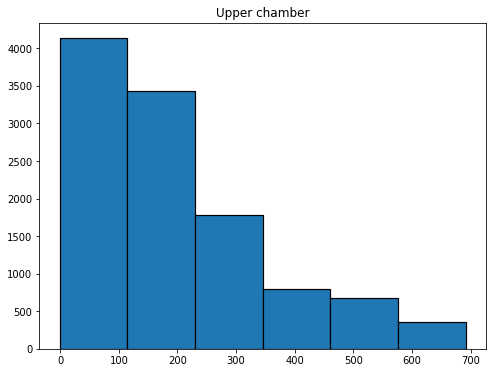

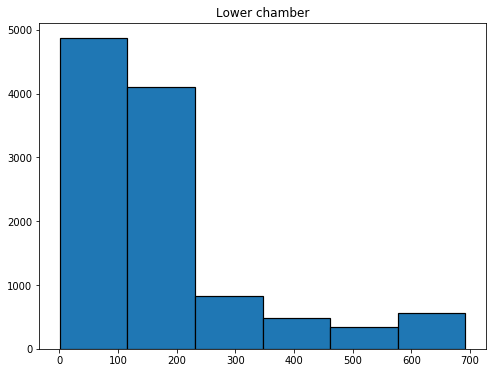

In [11]:
print("Hist for the left chambers")
            
plt.figure(figsize=(8, 6))
plt.title("Upper chamber")
plt.hist(x_punti_sopra,bins=6,edgecolor='black', linewidth=1.2)
plt.show()
            
plt.figure(figsize=(8, 6))
plt.title("Lower chamber")
plt.hist(x_punti_sotto,bins=6,edgecolor='black', linewidth=1.2)
plt.show()

percentuale  con 2 esclusi:  19.742489270386265  %
percentuale  con 1 esclusi:  15.370171673819744  %
percentuale  con 0 esclusi:  64.88733905579399  %


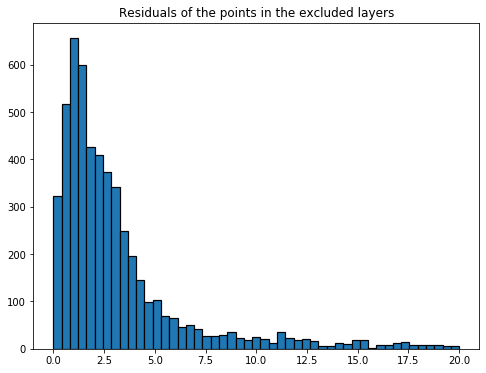

In [12]:
Hit_0=0
Hit_1=0
Hit_2=0
Tot_res=[]
for i in range(0,len(residuals)):
    if len(residuals[i])==0:
        Hit_0 +=1
    elif len(residuals[i])==1:
        Hit_1 +=1
        Tot_res.append(np.abs(residuals[i][0]))

    elif len(residuals[i])==2:
        Hit_2 +=1
        Tot_res.append(np.abs(residuals[i][0]))
        Tot_res.append(np.abs(residuals[i][1]))


print("percentuale  con 2 esclusi: ",Hit_0/len(residuals)*100," %")
print("percentuale  con 1 esclusi: ",Hit_1/len(residuals)*100," %")
print("percentuale  con 0 esclusi: ",Hit_2/len(residuals)*100," %")


plt.figure(figsize=(8, 6))
plt.title("Residuals of the points in the excluded layers")
plt.hist(Tot_res,bins=np.linspace(0,20,50),edgecolor='black', linewidth=1.2)
plt.show()

In [13]:
 data_file ="/Users/federicob/Documents/Physics_of_data/final_p/data/data_merged/calibration/destra.txt"
count=0
tot=0
eventi_selezionati=0
eventi_totali=0
residuals=[]
x_punti_sopra=[]
x_punti_sotto=[]
#stampo un plot ogni 10
A=0
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        eventi_totali += 1
        
        
        #Open and read the event
        ev, evNumber, hits = read_data(event)
        
        #print(ev)
        #Select the event
        condition, chambers, n_layers= select_events(ev,hits)
        tot+=1
        
        if(condition==True):
            eventi_selezionati +=1

            
            #Local linear fit
            lf_results=local_fit(ev, chambers, n_layers)
            #Global linear fit
            gf_results=global_fit(ev, chambers, lf_results)
            residuals.append(gf_results["residuals"])
            count+=1
            
            #Creo i due array contenenti i 
            
            for j in lf_results[0]["optimal_comb"]:
                x_punti_sopra.append(j[1])
                
                
                
            for j in lf_results[1]["optimal_comb"]:
                x_punti_sotto.append(j[1])
            
            
            


Hist for the right chambers


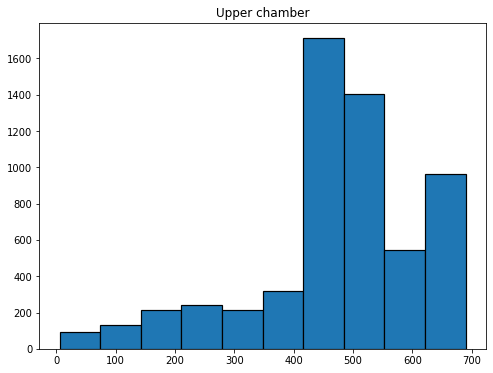

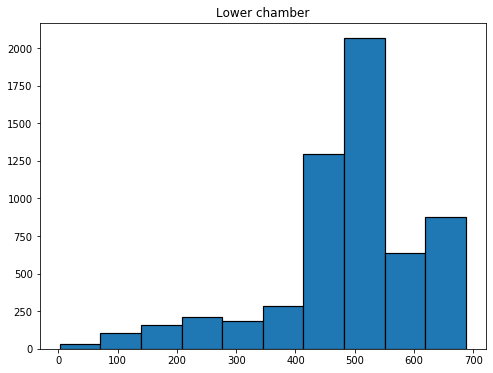

In [14]:
print("Hist for the right chambers")
            
plt.figure(figsize=(8, 6))
plt.title("Upper chamber")
plt.hist(x_punti_sopra,bins=10,edgecolor='black', linewidth=1.2)
plt.show()
            
plt.figure(figsize=(8, 6))
plt.title("Lower chamber")
plt.hist(x_punti_sotto,bins=10,edgecolor='black', linewidth=1.2)
plt.show()

percentuale  con 2 esclusi:  15.349075975359344  %
percentuale  con 1 esclusi:  27.46406570841889  %
percentuale  con 0 esclusi:  57.186858316221766  %


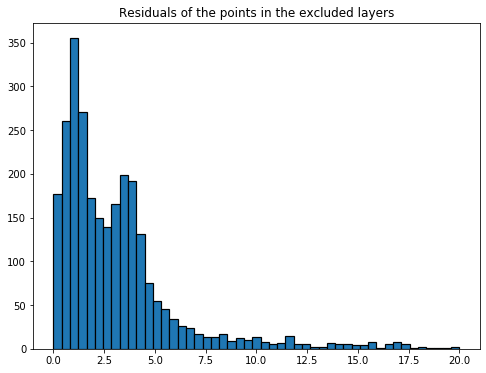

In [15]:
Hit_0=0
Hit_1=0
Hit_2=0
Tot_res=[]
for i in range(0,len(residuals)):
    if len(residuals[i])==0:
        Hit_0 +=1
    elif len(residuals[i])==1:
        Hit_1 +=1
        Tot_res.append(np.abs(residuals[i][0]))

    elif len(residuals[i])==2:
        Hit_2 +=1
        Tot_res.append(np.abs(residuals[i][0]))
        Tot_res.append(np.abs(residuals[i][1]))

print("percentuale  con 2 esclusi: ",Hit_0/len(residuals)*100," %")
print("percentuale  con 1 esclusi: ",Hit_1/len(residuals)*100," %")
print("percentuale  con 0 esclusi: ",Hit_2/len(residuals)*100," %")



plt.figure(figsize=(8, 6))
plt.title("Residuals of the points in the excluded layers")
plt.hist(Tot_res,bins=np.linspace(0,20,50),edgecolor='black', linewidth=1.2)
plt.show()

In [16]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    if hits_number == 0:
        hit       = [np.nan]
        chamber   = [np.nan]
        layer     = [np.nan]
        xl_local  = [np.nan]
        xr_local  = [np.nan]
        z_local   = [np.nan]
        time      = [np.nan]
        xl_global = [np.nan]
        xr_global = [np.nan]
        z_global  = [np.nan]
    else:
        hit       = np.arange(hits_number)
        chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
        layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
        xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
        xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
        z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
        time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
        xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
        xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
        z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
        
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })

        
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number



# Fisica

In [17]:
def filtro_punti(dataframe):
    
    dataframe_sinistro=dataframe[dataframe["Chamber"]>=2]
    dataframe1=dataframe_sinistro[dataframe_sinistro['XL_local']>=0]
    dataframe1=dataframe1[dataframe1["XR_local"]<=200]
    dataframe_destro=dataframe[dataframe["Chamber"]<=1]
    dataframe2=dataframe_destro[dataframe_destro['XL_local']>=540]
    dataframe2=dataframe2[dataframe2["XR_local"]<=720]
    dataframe_final=pd.concat([dataframe1,dataframe2])
    number_hits=len(dataframe_final)
    number_hits_s=len(dataframe1)
    number_hits_d=len(dataframe2)
    
    
    '''dataframe_final = dataframe completo
       dataframe1 = dataframe delle camere a sinistra
       dataframe2 = dataframe delle camere a destra
       lo stesso per i number of hits'''
    return dataframe_final,dataframe1,dataframe2,number_hits,number_hits_s,number_hits_d


In [18]:
def select_events(dataframe_final,dataframe1,dataframe2,number_hits,number_hits_s,number_hits_d):
    '''probabilmente  si può eliminare dataframe_final e number_hits'''
    
    select_d=False
    select_s=False
        
    '''parte sinistra'''
    if (number_hits_s < 6 or number_hits_s > 20):
        select_s=False
        chambers_s=[]
        n_layer_s=[]

    else:
        chambers_s=[0,1]
        #compute number of different layers in each chamber
        n_layer_ch0 = dataframe_s[dataframe_s['Chamber']==0]['Layer'].nunique()
        n_layer_ch1 = dataframe_s[dataframe_s['Chamber']==1]['Layer'].nunique()
        n_layer_s=[n_layer_ch0, n_layer_ch1]

        #require at least 3 different layers for each chamber
        if(n_layer_ch0>=3 and n_layer_ch1>=3):
            select_s=True
            '''select_s, chambers_s, n_layer_s  <- devo ricordarmi di ritornarmi questi'''


    '''parte destra'''
    if (number_hits_d < 6 or number_hits_d > 20):
        select_d=False
        chambers_d=[]
        n_layer_d=[]
    else:
        chambers_d=[2,3]
        #compute number of different layers in each chamber
        n_layer_ch2 = dataframe_d[dataframe_d['Chamber']==2]['Layer'].nunique()
        n_layer_ch3 = dataframe_d[dataframe_d['Chamber']==3]['Layer'].nunique() 
        n_layer_d=[n_layer_ch2, n_layer_ch3]

        #require at least 3 different layers for each chamber
        if(n_layer_ch2>=3 and n_layer_ch3>=3):
            select_d=True
            '''select_d, chambers_d, n_layer_d  <- devo ricordarmi di ritornarmi questi'''

    return select_s, chambers_s, n_layer_s, select_d, chambers_d, n_layer_d

        
        


In [19]:
data_file ="/Users/federicob/Documents/Physics_of_data/final_p/data/physics/Run000335/data_000035.txt"
count=0
tot=0
eventi_selezionati=0
eventi_totali=0
A=0
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        eventi_totali += 1
        
        
        #Open and read the event
        ev, evNumber, hits = read_data(event)
        dataframe_filtrato,dataframe_s,dataframe_d,number_hits,number_hits_s,number_hits_d = filtro_punti(ev)
        print("*************dataframe completo****************")
        display(ev)
        print("*************dataframe destro******************")
        display(dataframe_d)
        print("*************dataframe sinistro****************")
        display(dataframe_s)
    
        select_s, chambers_s, n_layer_s,select_d, chambers_d, n_layer_d = select_events(dataframe_filtrato,dataframe_s,dataframe_d,number_hits,number_hits_s,number_hits_d)
        
        #print(number_hits)
        #print(select_s,select_d)
        if (select_s == True  and select_d==True):
            eventi_selezionati +=1

        
print("frazione elementi selezionati: ", eventi_selezionati/eventi_totali *100)
            

        
        

        
       
        
        
        
        
        

*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1114,0,3,3,560.1,573.9,32.5,128.0,-821.6,-835.4,32.5
1,1114,1,3,4,579.9,596.1,45.5,150.5,-841.4,-857.6,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1115,0,2,4,371.0,385.0,45.5,130.5,-638.4,-652.4,869.0
1,1115,1,2,4,495.9,512.1,45.5,149.7,-763.3,-779.5,869.0
2,1115,2,2,1,512.9,537.1,6.5,225.5,-780.3,-804.5,830.0
3,1115,3,2,2,487.2,520.8,19.5,312.2,-754.6,-788.2,843.0
4,1115,4,2,3,508.6,541.5,32.5,305.5,-776.0,-808.9,856.0
5,1115,5,2,2,530.2,561.8,19.5,293.0,-797.6,-829.2,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1117,0,0,1,563.9,570.1,6.5,58.0,430.3,424.1,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1117,0,0,1,563.9,570.1,6.5,58.0,430.3,424.1,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1118,0,0,2,487.1,520.9,19.5,314.7,507.1,473.3,843.0
1,1118,1,1,4,583.9,592.1,45.5,76.3,363.5,355.3,45.5
2,1118,2,1,4,613.7,646.3,45.5,302.2,333.7,301.1,45.5
3,1118,3,1,4,570.6,605.4,45.5,323.0,376.8,342.0,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1118,1,1,4,583.9,592.1,45.5,76.3,363.5,355.3,45.5
2,1118,2,1,4,613.7,646.3,45.5,302.2,333.7,301.1,45.5
3,1118,3,1,4,570.6,605.4,45.5,323.0,376.8,342.0,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1120,0,0,2,669.900,674.10,19.5,39.7,324.300,320.10,843.0
1,1120,1,0,4,669.700,674.30,45.5,43.0,324.500,319.90,869.0
2,1120,2,0,1,639.500,662.50,6.5,213.0,354.700,331.70,830.0
3,1120,3,0,3,633.200,668.80,32.5,331.3,361.000,325.40,856.0
4,1120,4,1,2,617.200,642.80,19.5,237.2,330.200,304.60,19.5
5,1120,5,1,4,610.900,649.10,45.5,354.7,336.500,298.30,45.5
6,1120,6,2,4,247.800,256.20,45.5,78.0,-515.200,-523.60,869.0
7,1120,7,2,4,292.400,295.60,45.5,28.8,-559.800,-563.00,869.0
8,1120,8,2,3,438.900,443.10,32.5,38.8,-706.300,-710.50,856.0
9,1120,9,2,1,313.100,316.90,6.5,35.5,-580.500,-584.30,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1120,0,0,2,669.9,674.1,19.5,39.7,324.3,320.1,843.0
1,1120,1,0,4,669.7,674.3,45.5,43.0,324.5,319.9,869.0
2,1120,2,0,1,639.5,662.5,6.5,213.0,354.7,331.7,830.0
3,1120,3,0,3,633.2,668.8,32.5,331.3,361.0,325.4,856.0
4,1120,4,1,2,617.2,642.8,19.5,237.2,330.2,304.6,19.5
5,1120,5,1,4,610.9,649.1,45.5,354.7,336.5,298.3,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
19,1120,19,3,1,3.742,38.26,6.5,320.5,-265.242,-299.76,6.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1122,0,0,2,453.800,470.20,19.5,152.1,540.400,524.00,843.0
1,1122,1,0,4,665.200,678.80,45.5,125.5,329.000,315.40,869.0
2,1122,2,0,3,478.300,487.70,32.5,88.0,515.900,506.50,856.0
3,1122,3,0,1,641.400,660.60,6.5,178.0,352.800,333.60,830.0
4,1122,4,0,1,420.700,461.30,6.5,377.1,573.500,532.90,830.0
5,1122,5,0,1,461.300,504.70,6.5,403.0,532.900,489.50,830.0
6,1122,6,0,3,638.500,663.50,32.5,233.0,355.700,330.70,856.0
7,1122,7,2,1,18.950,23.05,6.5,38.0,-286.350,-290.45,830.0
8,1122,8,2,3,18.190,23.81,32.5,52.1,-285.590,-291.21,856.0
9,1122,9,2,2,39.370,44.63,19.5,48.8,-306.770,-312.03,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1122,1,0,4,665.2,678.8,45.5,125.5,329.0,315.4,869.0
3,1122,3,0,1,641.4,660.6,6.5,178.0,352.8,333.6,830.0
6,1122,6,0,3,638.5,663.5,32.5,233.0,355.7,330.7,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
7,1122,7,2,1,18.950,23.05,6.5,38.0,-286.350,-290.45,830.0
8,1122,8,2,3,18.190,23.81,32.5,52.1,-285.590,-291.21,856.0
9,1122,9,2,2,39.370,44.63,19.5,48.8,-306.770,-312.03,843.0
10,1122,10,2,2,67.460,100.50,19.5,307.1,-334.860,-367.90,843.0
11,1122,11,2,3,1.319,40.68,32.5,365.5,-268.719,-308.08,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1123,0,0,3,645.9,656.1,32.5,93.8,348.3,338.1,856.0
1,1123,1,3,2,150.4,185.6,19.5,327.1,-411.9,-447.1,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1123,0,0,3,645.9,656.1,32.5,93.8,348.3,338.1,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1123,1,3,2,150.4,185.6,19.5,327.1,-411.9,-447.1,19.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1124,0,2,2,669.70,674.30,19.5,43.0,-937.10,-941.70,843.0
1,1124,1,2,3,99.05,111.00,32.5,110.5,-366.45,-378.40,856.0
2,1124,2,2,4,497.70,510.30,45.5,116.3,-765.10,-777.70,869.0
3,1124,3,2,2,539.40,552.60,19.5,123.0,-806.80,-820.00,843.0
4,1124,4,2,2,69.35,98.65,19.5,272.1,-336.75,-366.05,843.0
5,1124,5,2,4,617.50,642.50,45.5,233.0,-884.90,-909.90,869.0
6,1124,6,2,4,65.17,102.80,45.5,349.6,-332.57,-370.20,869.0
7,1124,7,2,3,383.00,415.00,32.5,297.1,-650.40,-682.40,856.0
8,1124,8,2,3,169.50,208.50,32.5,361.3,-436.90,-475.90,856.0
9,1124,9,2,1,470.80,495.20,6.5,227.1,-738.20,-762.60,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1124,1,2,3,99.05,111.00,32.5,110.5,-366.45,-378.40,856.0
4,1124,4,2,2,69.35,98.65,19.5,272.1,-336.75,-366.05,843.0
6,1124,6,2,4,65.17,102.80,45.5,349.6,-332.57,-370.20,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1125,0,0,2,624.4,635.6,19.5,103.8,369.8,358.6,843.0
1,1125,1,0,1,647.6,654.4,6.5,63.8,346.6,339.8,830.0
2,1125,2,0,3,645.6,656.4,32.5,99.7,348.6,337.8,856.0
3,1125,3,0,4,569.8,606.2,45.5,337.2,424.4,388.0,869.0
4,1125,4,0,2,653.9,690.1,19.5,336.3,340.3,304.1,843.0
5,1125,5,0,4,611.4,648.6,45.5,345.5,382.8,345.6,869.0
6,1125,6,0,4,657.3,686.7,45.5,273.0,336.9,307.5,869.0
7,1125,7,0,1,588.3,629.7,6.5,384.7,405.9,364.5,830.0
8,1125,8,1,4,624.5,635.5,45.5,103.0,322.9,311.9,45.5
9,1125,9,2,4,166.3,169.7,45.5,32.2,-433.7,-437.1,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1125,0,0,2,624.4,635.6,19.5,103.8,369.8,358.6,843.0
1,1125,1,0,1,647.6,654.4,6.5,63.8,346.6,339.8,830.0
2,1125,2,0,3,645.6,656.4,32.5,99.7,348.6,337.8,856.0
3,1125,3,0,4,569.8,606.2,45.5,337.2,424.4,388.0,869.0
4,1125,4,0,2,653.9,690.1,19.5,336.3,340.3,304.1,843.0
5,1125,5,0,4,611.4,648.6,45.5,345.5,382.8,345.6,869.0
6,1125,6,0,4,657.3,686.7,45.5,273.0,336.9,307.5,869.0
7,1125,7,0,1,588.3,629.7,6.5,384.7,405.9,364.5,830.0
8,1125,8,1,4,624.5,635.5,45.5,103.0,322.9,311.9,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
9,1125,9,2,4,166.3,169.7,45.5,32.2,-433.7,-437.1,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1126,0,0,3,560.2,573.8,32.5,126.3,434.0,420.4,856.0
1,1126,1,0,3,424.8,457.2,32.5,300.5,569.4,537.0,856.0
2,1126,2,0,4,443.4,480.6,45.5,346.3,550.8,513.6,869.0
3,1126,3,0,1,556.2,577.8,6.5,200.5,438.0,416.4,830.0
4,1126,4,0,4,569.3,606.7,45.5,348.0,424.9,387.5,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1126,0,0,3,560.2,573.8,32.5,126.3,434.0,420.4,856.0
3,1126,3,0,1,556.2,577.8,6.5,200.5,438.0,416.4,830.0
4,1126,4,0,4,569.3,606.7,45.5,348.0,424.9,387.5,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1127,0,0,1,565.80,568.20,6.5,23.0,428.40,426.00,830.0
1,1127,1,0,3,607.40,610.60,32.5,28.9,386.80,383.60,856.0
2,1127,2,0,1,229.10,232.90,6.5,34.7,765.10,761.30,830.0
3,1127,3,0,4,670.60,673.40,45.5,25.5,323.60,320.80,869.0
4,1127,4,0,2,372.60,383.40,19.5,100.5,621.60,610.80,843.0
5,1127,5,0,3,439.00,443.00,32.5,38.0,555.20,551.20,856.0
6,1127,6,0,3,222.40,239.60,32.5,158.9,771.80,754.60,856.0
7,1127,7,0,3,563.40,570.60,32.5,67.2,430.80,423.60,856.0
8,1127,8,0,4,325.20,346.80,45.5,201.4,669.00,647.40,869.0
9,1127,9,0,2,628.00,632.00,19.5,36.4,366.20,362.20,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1127,0,0,1,565.8,568.2,6.5,23.0,428.4,426.0,830.0
1,1127,1,0,3,607.4,610.6,32.5,28.9,386.8,383.6,856.0
3,1127,3,0,4,670.6,673.4,45.5,25.5,323.6,320.8,869.0
7,1127,7,0,3,563.4,570.6,32.5,67.2,430.8,423.6,856.0
9,1127,9,0,2,628.0,632.0,19.5,36.4,366.2,362.2,843.0
11,1127,11,0,1,648.0,654.0,6.5,55.5,346.2,340.2,830.0
16,1127,16,0,4,581.8,594.2,45.5,115.5,412.4,400.0,869.0
17,1127,17,0,2,670.0,674.0,19.5,37.2,324.2,320.2,843.0
19,1127,19,0,1,607.4,610.6,6.5,30.5,386.8,383.6,830.0
20,1127,20,0,3,631.5,670.5,32.5,362.2,362.7,323.7,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
32,1127,32,2,3,144.90,149.10,32.5,38.9,-412.30,-416.50,856.0
37,1127,37,2,4,42.00,42.00,45.5,-3.6,-309.40,-309.40,869.0
39,1127,39,2,4,121.90,130.10,45.5,76.4,-389.30,-397.50,869.0
40,1127,40,2,2,166.00,170.00,19.5,36.4,-433.40,-437.40,843.0
44,1127,44,2,1,15.32,26.68,6.5,105.5,-282.72,-294.08,830.0
47,1127,47,2,4,105.40,146.60,45.5,382.2,-372.80,-414.00,869.0
48,1127,48,2,4,149.00,187.00,45.5,353.0,-416.40,-454.40,869.0
50,1127,50,2,1,126.50,167.50,6.5,380.5,-393.90,-434.90,830.0
51,1127,51,3,4,38.47,45.53,45.5,65.5,-299.97,-307.03,45.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1128,0,0,2,618.40,641.60,19.5,214.7,375.80,352.60,843.0
1,1128,1,0,2,530.30,561.70,19.5,291.3,463.90,432.50,843.0
2,1128,2,0,4,625.00,635.00,45.5,92.2,369.20,359.20,869.0
3,1128,3,0,2,660.40,683.60,19.5,215.5,333.80,310.60,843.0
4,1128,4,0,1,554.50,579.50,6.5,232.2,439.70,414.70,830.0
5,1128,5,0,3,592.70,625.30,32.5,302.2,401.50,368.90,856.0
6,1128,6,0,4,657.90,686.10,45.5,261.3,336.30,308.10,869.0
7,1128,7,0,4,612.70,647.30,45.5,321.3,381.50,346.90,869.0
8,1128,8,0,1,629.70,672.30,6.5,396.3,364.50,321.90,830.0
9,1128,9,0,1,586.10,631.90,6.5,424.7,408.10,362.30,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1128,0,0,2,618.4,641.6,19.5,214.7,375.8,352.6,843.0
2,1128,2,0,4,625.0,635.0,45.5,92.2,369.2,359.2,869.0
3,1128,3,0,2,660.4,683.6,19.5,215.5,333.8,310.6,843.0
4,1128,4,0,1,554.5,579.5,6.5,232.2,439.7,414.7,830.0
5,1128,5,0,3,592.7,625.3,32.5,302.2,401.5,368.9,856.0
6,1128,6,0,4,657.9,686.1,45.5,261.3,336.3,308.1,869.0
7,1128,7,0,4,612.7,647.3,45.5,321.3,381.5,346.9,869.0
8,1128,8,0,1,629.7,672.3,6.5,396.3,364.5,321.9,830.0
9,1128,9,0,1,586.1,631.9,6.5,424.7,408.1,362.3,830.0
10,1128,10,0,3,627.5,674.5,32.5,437.2,366.7,319.7,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
11,1128,11,2,1,46.68,79.32,6.5,303.0,-314.08,-346.72,830.0
13,1128,13,2,4,21.56,62.44,45.5,379.7,-288.96,-329.84,869.0
14,1128,14,2,3,41.88,84.12,32.5,392.2,-309.28,-351.52,856.0
15,1128,15,2,2,16.98,67.02,19.5,464.7,-284.38,-334.42,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1130,0,0,3,647.400,654.60,32.5,67.2,346.800,339.60,856.0
1,1130,1,0,2,667.900,676.10,19.5,75.5,326.300,318.10,843.0
2,1130,2,0,4,664.300,679.70,45.5,142.2,329.900,314.50,869.0
3,1130,3,0,1,637.400,664.60,6.5,252.2,356.800,329.60,830.0
4,1130,4,2,1,60.510,65.49,6.5,46.3,-327.910,-332.89,830.0
5,1130,5,2,3,60.730,65.27,32.5,42.2,-328.130,-332.67,856.0
6,1130,6,2,2,65.260,102.70,19.5,348.0,-332.660,-370.10,843.0
7,1130,7,2,4,64.320,103.70,45.5,365.5,-331.720,-371.10,869.0
8,1130,8,3,1,13.390,28.61,6.5,141.3,-274.890,-290.11,6.5
9,1130,9,3,2,32.780,51.22,19.5,171.3,-294.280,-312.72,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1130,0,0,3,647.4,654.6,32.5,67.2,346.8,339.6,856.0
1,1130,1,0,2,667.9,676.1,19.5,75.5,326.3,318.1,843.0
2,1130,2,0,4,664.3,679.7,45.5,142.2,329.9,314.5,869.0
3,1130,3,0,1,637.4,664.6,6.5,252.2,356.8,329.6,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
4,1130,4,2,1,60.510,65.49,6.5,46.3,-327.910,-332.89,830.0
5,1130,5,2,3,60.730,65.27,32.5,42.2,-328.130,-332.67,856.0
6,1130,6,2,2,65.260,102.70,19.5,348.0,-332.660,-370.10,843.0
7,1130,7,2,4,64.320,103.70,45.5,365.5,-331.720,-371.10,869.0
8,1130,8,3,1,13.390,28.61,6.5,141.3,-274.890,-290.11,6.5
9,1130,9,3,2,32.780,51.22,19.5,171.3,-294.280,-312.72,19.5
10,1130,10,3,3,10.110,31.89,32.5,202.2,-271.610,-293.39,32.5
11,1130,11,3,4,31.470,52.53,45.5,195.5,-292.970,-314.03,45.5
12,1130,12,3,3,2.709,39.29,32.5,339.7,-264.209,-300.79,32.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1131,0,0,2,327.8,344.2,19.5,153.0,666.4,650.0,843.0
1,1131,1,0,1,346.2,367.8,6.5,199.7,648.0,626.4,830.0
2,1131,2,0,2,321.2,350.8,19.5,274.7,673.0,643.4,843.0
3,1131,3,0,4,317.0,355.0,45.5,353.0,677.2,639.2,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1132,0,2,4,458.6,465.4,45.5,63.0,-726.0,-732.8,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1133,0,0,4,665.20,678.80,45.5,127.2,329.00,315.40,869.0
1,1133,1,0,1,520.60,529.40,6.5,82.2,473.60,464.80,830.0
2,1133,2,0,1,631.30,670.70,6.5,366.3,362.90,323.50,830.0
3,1133,3,0,2,536.50,555.50,19.5,175.5,457.70,438.70,843.0
4,1133,4,0,3,505.10,545.00,32.5,370.5,489.10,449.20,856.0
5,1133,5,1,2,622.40,637.60,19.5,141.3,325.00,309.80,19.5
6,1133,6,2,3,17.34,24.66,32.5,68.0,-284.74,-292.06,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1133,0,0,4,665.2,678.8,45.5,127.2,329.0,315.4,869.0
2,1133,2,0,1,631.3,670.7,6.5,366.3,362.9,323.5,830.0
5,1133,5,1,2,622.4,637.6,19.5,141.3,325.0,309.8,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1133,6,2,3,17.34,24.66,32.5,68.0,-284.74,-292.06,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1134,0,0,2,629.300,630.70,19.5,12.1,364.900,363.50,843.0
1,1134,1,0,3,438.900,443.10,32.5,39.6,555.300,551.10,856.0
2,1134,2,0,4,626.000,634.00,45.5,73.8,368.200,360.20,869.0
3,1134,3,0,2,668.200,675.80,19.5,71.3,326.000,318.40,843.0
4,1134,4,0,4,667.400,676.60,45.5,84.6,326.800,317.60,869.0
5,1134,5,1,4,586.300,589.70,45.5,32.1,361.100,357.70,45.5
6,1134,6,1,3,562.400,571.60,32.5,86.3,385.000,375.80,32.5
7,1134,7,1,3,508.300,541.70,32.5,309.6,439.100,405.70,32.5
8,1134,8,2,4,83.750,84.25,45.5,4.6,-351.150,-351.65,869.0
9,1134,9,2,1,13.260,28.74,6.5,143.8,-280.660,-296.14,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1134,0,0,2,629.3,630.7,19.5,12.1,364.9,363.5,843.0
2,1134,2,0,4,626.0,634.0,45.5,73.8,368.2,360.2,869.0
3,1134,3,0,2,668.2,675.8,19.5,71.3,326.0,318.4,843.0
4,1134,4,0,4,667.4,676.6,45.5,84.6,326.8,317.6,869.0
5,1134,5,1,4,586.3,589.7,45.5,32.1,361.1,357.7,45.5
6,1134,6,1,3,562.4,571.6,32.5,86.3,385.0,375.8,32.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
8,1134,8,2,4,83.750,84.25,45.5,4.6,-351.150,-351.65,869.0
9,1134,9,2,1,13.260,28.74,6.5,143.8,-280.660,-296.14,830.0
10,1134,10,2,2,120.900,131.10,19.5,93.8,-388.300,-398.50,843.0
11,1134,11,2,3,7.424,34.58,32.5,252.1,-274.824,-301.98,856.0
12,1134,12,2,3,94.560,115.40,32.5,193.8,-361.960,-382.80,856.0
13,1134,13,2,2,112.800,139.20,19.5,244.6,-380.200,-406.60,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1135,0,0,1,95.51,114.5,6.5,176.3,898.69,879.7,830.0
1,1135,1,0,3,91.24,118.8,32.5,255.5,902.96,875.4,856.0
2,1135,2,0,2,109.70,142.3,19.5,303.0,884.50,851.9,843.0
3,1135,3,1,4,628.20,631.8,45.5,33.8,319.20,315.6,45.5
4,1135,4,1,3,609.00,609.0,32.5,-0.3,338.40,338.4,32.5
5,1135,5,2,2,540.70,551.3,19.5,98.8,-808.10,-818.7,843.0
6,1135,6,2,4,542.10,549.9,45.5,73.0,-809.50,-817.3,869.0
7,1135,7,2,3,554.10,579.9,32.5,238.8,-821.50,-847.3,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1135,3,1,4,628.2,631.8,45.5,33.8,319.2,315.6,45.5
4,1135,4,1,3,609.0,609.0,32.5,-0.3,338.4,338.4,32.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1136,0,0,2,670.400,673.60,19.5,30.5,323.800,320.60,843.0
1,1136,1,0,1,558.200,575.80,6.5,163.0,436.000,418.40,830.0
2,1136,2,0,2,241.900,262.10,19.5,187.1,752.300,732.10,843.0
3,1136,3,0,1,600.100,617.90,6.5,164.6,394.100,376.30,830.0
4,1136,4,0,3,264.900,281.10,32.5,150.5,729.300,713.10,856.0
5,1136,5,0,4,668.600,675.40,45.5,63.0,325.600,318.80,869.0
6,1136,6,0,4,241.300,262.70,45.5,198.8,752.900,731.50,869.0
7,1136,7,0,3,600.100,617.90,32.5,164.6,394.100,376.30,856.0
8,1136,8,0,2,617.800,642.20,19.5,226.3,376.400,352.00,843.0
9,1136,9,0,4,615.500,644.50,45.5,268.8,378.700,349.70,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1136,0,0,2,670.4,673.6,19.5,30.5,323.8,320.6,843.0
1,1136,1,0,1,558.2,575.8,6.5,163.0,436.0,418.4,830.0
3,1136,3,0,1,600.1,617.9,6.5,164.6,394.1,376.3,830.0
5,1136,5,0,4,668.6,675.4,45.5,63.0,325.6,318.8,869.0
7,1136,7,0,3,600.1,617.9,32.5,164.6,394.1,376.3,856.0
8,1136,8,0,2,617.8,642.2,19.5,226.3,376.4,352.0,843.0
9,1136,9,0,4,615.5,644.5,45.5,268.8,378.7,349.7,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
10,1136,10,2,4,166.300,169.70,45.5,32.1,-433.700,-437.10,869.0
14,1136,14,2,3,14.830,27.17,32.5,114.6,-282.230,-294.57,856.0
15,1136,15,2,4,124.500,127.50,45.5,28.0,-391.900,-394.90,869.0
17,1136,17,2,3,142.900,151.10,32.5,75.5,-410.300,-418.50,856.0
25,1136,25,2,1,13.210,28.79,6.5,144.6,-280.610,-296.19,830.0
27,1136,27,2,3,102.400,107.60,32.5,48.8,-369.800,-375.00,856.0
29,1136,29,2,2,154.900,181.10,19.5,243.0,-422.300,-448.50,843.0
33,1136,33,2,3,5.987,36.01,32.5,278.8,-273.387,-303.41,856.0
34,1136,34,2,2,119.300,132.70,19.5,123.8,-386.700,-400.10,843.0
35,1136,35,2,3,130.600,163.40,32.5,304.6,-398.000,-430.80,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1137,0,0,1,353.5,360.5,6.5,64.7,640.7,633.7,830.0
1,1137,1,0,4,365.9,390.1,45.5,223.8,628.3,604.1,869.0
2,1137,2,0,2,359.0,397.0,19.5,352.2,635.2,597.2,843.0
3,1137,3,1,2,584.2,591.8,19.5,70.5,363.2,355.6,19.5
4,1137,4,1,3,593.2,624.8,32.5,293.8,354.2,322.6,32.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1137,3,1,2,584.2,591.8,19.5,70.5,363.2,355.6,19.5
4,1137,4,1,3,593.2,624.8,32.5,293.8,354.2,322.6,32.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1138,0,0,2,544.6,547.4,19.5,26.3,449.6,446.8,843.0
1,1138,1,0,3,562.4,571.6,32.5,85.5,431.8,422.6,856.0
2,1138,2,0,2,326.1,345.9,19.5,183.0,668.1,648.3,843.0
3,1138,3,0,4,579.0,597.0,45.5,166.3,415.2,397.2,869.0
4,1138,4,0,4,321.6,350.4,45.5,267.1,672.6,643.8,869.0
5,1138,5,0,1,514.5,535.5,6.5,195.5,479.7,458.7,830.0
6,1138,6,0,4,360.9,395.1,45.5,318.0,633.3,599.1,869.0
7,1138,7,1,4,617.0,643.0,45.5,242.1,330.4,304.4,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1138,0,0,2,544.6,547.4,19.5,26.3,449.6,446.8,843.0
1,1138,1,0,3,562.4,571.6,32.5,85.5,431.8,422.6,856.0
3,1138,3,0,4,579.0,597.0,45.5,166.3,415.2,397.2,869.0
7,1138,7,1,4,617.0,643.0,45.5,242.1,330.4,304.4,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1139,0,0,2,671.3,672.7,19.5,13.8,322.9,321.5,843.0
1,1139,1,0,4,656.8,687.2,45.5,282.2,337.4,307.0,869.0
2,1139,2,1,2,625.6,634.4,19.5,82.2,321.8,313.0,19.5
3,1139,3,1,2,614.7,645.3,19.5,283.8,332.7,302.1,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1139,0,0,2,671.3,672.7,19.5,13.8,322.9,321.5,843.0
1,1139,1,0,4,656.8,687.2,45.5,282.2,337.4,307.0,869.0
2,1139,2,1,2,625.6,634.4,19.5,82.2,321.8,313.0,19.5
3,1139,3,1,2,614.7,645.3,19.5,283.8,332.7,302.1,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1140,0,1,4,628.7,631.3,45.5,23.8,318.7,316.1,45.5
1,1140,1,1,4,618.9,641.1,45.5,205.5,328.5,306.3,45.5
2,1140,2,2,3,104.5,105.5,32.5,8.8,-371.9,-372.9,856.0
3,1140,3,2,4,493.3,514.7,45.5,198.0,-760.7,-782.1,869.0
4,1140,4,2,2,107.9,144.1,19.5,335.5,-375.3,-411.5,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1140,0,1,4,628.7,631.3,45.5,23.8,318.7,316.1,45.5
1,1140,1,1,4,618.9,641.1,45.5,205.5,328.5,306.3,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1140,2,2,3,104.5,105.5,32.5,8.8,-371.9,-372.9,856.0
4,1140,4,2,2,107.9,144.1,19.5,335.5,-375.3,-411.5,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1141,0,0,3,548.4,585.6,32.5,346.3,445.8,408.6,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1141,0,0,3,548.4,585.6,32.5,346.3,445.8,408.6,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1143,0,0,4,372.5,383.5,45.5,102.1,621.7,610.7,869.0
1,1143,1,0,4,418.0,422.0,45.5,36.3,576.2,572.2,869.0
2,1143,2,0,4,455.9,468.1,45.5,113.8,538.3,526.1,869.0
3,1143,3,2,1,181.4,196.6,6.5,141.3,-448.8,-464.0,830.0
4,1143,4,2,2,205.2,214.8,19.5,89.6,-472.6,-482.2,843.0
5,1143,5,2,3,173.1,204.9,32.5,295.5,-440.5,-472.3,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1143,3,2,1,181.4,196.6,6.5,141.3,-448.8,-464.0,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1144,0,0,4,167.100,168.90,45.5,16.4,827.100,825.30,869.0
1,1144,1,0,3,607.400,610.60,32.5,28.9,386.800,383.60,856.0
2,1144,2,0,1,649.100,652.90,6.5,35.5,345.100,341.30,830.0
3,1144,3,0,4,209.600,210.40,45.5,7.2,784.600,783.80,869.0
4,1144,4,0,1,562.800,571.20,6.5,77.2,431.400,423.00,830.0
5,1144,5,0,4,583.800,592.20,45.5,77.2,410.400,402.00,869.0
6,1144,6,0,2,204.000,216.00,19.5,112.2,790.200,778.20,843.0
7,1144,7,0,2,665.600,678.40,19.5,118.0,328.600,315.80,843.0
8,1144,8,0,1,220.100,241.90,6.5,202.2,774.100,752.30,830.0
9,1144,9,0,3,591.100,626.90,32.5,333.0,403.100,367.30,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1144,1,0,3,607.4,610.6,32.5,28.9,386.8,383.6,856.0
2,1144,2,0,1,649.1,652.9,6.5,35.5,345.1,341.3,830.0
4,1144,4,0,1,562.8,571.2,6.5,77.2,431.4,423.0,830.0
5,1144,5,0,4,583.8,592.2,45.5,77.2,410.4,402.0,869.0
7,1144,7,0,2,665.6,678.4,19.5,118.0,328.6,315.8,843.0
9,1144,9,0,3,591.1,626.9,32.5,333.0,403.1,367.3,856.0
10,1144,10,0,2,655.8,688.2,19.5,301.4,338.4,306.0,843.0
12,1144,12,0,2,613.0,647.0,19.5,315.5,381.2,347.2,843.0
13,1144,13,0,1,589.4,628.6,6.5,364.7,404.8,365.6,830.0
14,1144,14,1,2,628.3,631.7,19.5,32.2,319.1,315.7,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
16,1144,16,2,1,19.670,22.33,6.5,24.7,-287.070,-289.73,830.0
17,1144,17,2,3,16.570,25.43,32.5,82.2,-283.970,-292.83,856.0
19,1144,19,2,2,41.700,42.30,19.5,5.5,-309.100,-309.70,843.0
20,1144,20,2,1,60.860,65.14,6.5,39.7,-328.260,-332.54,830.0
21,1144,21,2,3,57.500,68.50,32.5,102.2,-324.900,-335.90,856.0
22,1144,22,2,4,33.490,50.51,45.5,158.0,-300.890,-317.91,869.0
23,1144,23,2,3,4.503,37.50,32.5,306.4,-271.903,-304.90,856.0
24,1144,24,2,2,23.980,60.02,19.5,334.7,-291.380,-327.42,843.0
25,1144,25,3,4,39.060,44.94,45.5,54.7,-300.560,-306.44,45.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1145,0,1,4,612.00,648.00,45.5,333.8,335.40,299.40,45.5
1,1145,1,2,4,242.20,261.80,45.5,181.3,-509.60,-529.20,869.0
2,1145,2,2,3,269.30,276.70,32.5,68.8,-536.70,-544.10,856.0
3,1145,3,2,3,12.94,29.06,32.5,149.7,-280.34,-296.46,856.0
4,1145,4,2,2,281.70,306.30,19.5,228.8,-549.10,-573.70,843.0
5,1145,5,2,2,316.50,355.50,19.5,361.3,-583.90,-622.90,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1145,0,1,4,612.0,648.0,45.5,333.8,335.4,299.4,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1145,3,2,3,12.94,29.06,32.5,149.7,-280.34,-296.46,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1146,0,0,1,104.50,105.50,6.5,9.6,889.70,888.70,830.0
1,1146,1,0,3,567.00,567.00,32.5,-14.5,427.20,427.20,856.0
2,1146,2,0,3,105.00,105.00,32.5,-2.9,889.20,889.20,856.0
3,1146,3,0,1,609.00,609.00,6.5,-15.4,385.20,385.20,830.0
4,1146,4,0,3,187.90,190.10,32.5,20.5,806.30,804.10,856.0
5,1146,5,0,3,651.00,651.00,32.5,-1.2,343.20,343.20,856.0
6,1146,6,0,1,348.90,365.10,6.5,151.3,645.30,629.10,830.0
7,1146,7,0,1,437.20,444.80,6.5,71.3,557.00,549.40,830.0
8,1146,8,0,2,120.30,131.70,19.5,105.5,873.90,862.50,843.0
9,1146,9,0,2,504.00,504.00,19.5,-6.2,490.20,490.20,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1146,1,0,3,567.0,567.0,32.5,-14.5,427.2,427.2,856.0
3,1146,3,0,1,609.0,609.0,6.5,-15.4,385.2,385.2,830.0
5,1146,5,0,3,651.0,651.0,32.5,-1.2,343.2,343.2,856.0
13,1146,13,0,3,608.8,609.2,32.5,3.0,385.4,385.0,856.0
15,1146,15,0,2,670.2,673.8,19.5,33.0,324.0,320.4,843.0
21,1146,21,0,2,630.0,630.0,19.5,-9.5,364.2,364.2,843.0
22,1146,22,0,4,671.8,672.2,45.5,3.0,322.4,322.0,869.0
25,1146,25,0,2,546.0,546.0,19.5,-11.2,448.2,448.2,843.0
26,1146,26,0,4,628.6,631.4,45.5,26.3,365.6,362.8,869.0
27,1146,27,0,1,648.0,654.0,6.5,55.5,346.2,340.2,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
53,1146,53,2,3,104.70,105.30,32.5,5.5,-372.10,-372.70,856.0
59,1146,59,2,4,40.63,43.37,45.5,25.5,-308.03,-310.77,869.0
61,1146,61,2,2,80.34,87.66,19.5,68.0,-347.74,-355.06,843.0
63,1146,63,2,3,187.80,190.20,32.5,22.1,-455.20,-457.60,856.0
68,1146,68,2,1,62.62,63.38,6.5,7.1,-330.02,-330.78,830.0
69,1146,69,2,4,78.64,89.36,45.5,99.6,-346.04,-356.76,869.0
70,1146,70,2,3,144.80,149.20,32.5,41.3,-412.20,-416.60,856.0
74,1146,74,2,2,30.08,53.92,19.5,221.3,-297.48,-321.32,843.0
75,1146,75,2,4,118.70,133.30,45.5,135.5,-386.10,-400.70,869.0
76,1146,76,2,2,159.00,177.00,19.5,167.1,-426.40,-444.40,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1147,0,2,4,165.0,171.0,45.5,56.4,-432.4,-438.4,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1147,0,2,4,165.0,171.0,45.5,56.4,-432.4,-438.4,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1148,0,0,2,376.0,380.0,19.5,38.0,618.2,614.2,843.0
1,1148,1,0,4,368.4,387.6,45.5,178.0,625.8,606.6,869.0
2,1148,2,0,1,379.7,418.3,6.5,358.0,614.5,575.9,830.0
3,1148,3,0,3,380.0,418.0,32.5,352.2,614.2,576.2,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1149,0,0,4,617.1,642.9,45.5,238.8,377.1,351.3,869.0
1,1149,1,0,4,450.2,473.8,45.5,218.8,544.0,520.4,869.0
2,1149,2,0,1,598.3,619.7,6.5,198.8,395.9,374.5,830.0
3,1149,3,0,1,424.0,458.0,6.5,315.5,570.2,536.2,830.0
4,1149,4,0,3,592.5,625.5,32.5,307.1,401.7,368.7,856.0
5,1149,5,0,2,612.3,647.7,19.5,329.6,381.9,346.5,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1149,0,0,4,617.1,642.9,45.5,238.8,377.1,351.3,869.0
2,1149,2,0,1,598.3,619.7,6.5,198.8,395.9,374.5,830.0
4,1149,4,0,3,592.5,625.5,32.5,307.1,401.7,368.7,856.0
5,1149,5,0,2,612.3,647.7,19.5,329.6,381.9,346.5,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1150,0,0,1,648.70,653.30,6.5,42.1,345.50,340.90,830.0
1,1150,1,0,1,560.20,573.80,6.5,126.3,434.00,420.40,830.0
2,1150,2,0,4,587.20,588.80,45.5,14.6,407.00,405.40,869.0
3,1150,3,0,3,649.20,652.80,32.5,33.0,345.00,341.40,856.0
4,1150,4,0,3,556.70,577.30,32.5,192.1,437.50,416.90,856.0
5,1150,5,0,1,605.20,612.80,6.5,70.5,389.00,381.40,830.0
6,1150,6,0,2,669.70,674.30,19.5,43.0,324.50,319.90,843.0
7,1150,7,0,3,606.40,611.60,32.5,48.0,387.80,382.60,856.0
8,1150,8,0,4,666.80,677.20,45.5,96.3,327.40,317.00,869.0
9,1150,9,0,2,623.00,637.00,19.5,130.5,371.20,357.20,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1150,0,0,1,648.7,653.3,6.5,42.1,345.5,340.9,830.0
1,1150,1,0,1,560.2,573.8,6.5,126.3,434.0,420.4,830.0
2,1150,2,0,4,587.2,588.8,45.5,14.6,407.0,405.4,869.0
3,1150,3,0,3,649.2,652.8,32.5,33.0,345.0,341.4,856.0
4,1150,4,0,3,556.7,577.3,32.5,192.1,437.5,416.9,856.0
5,1150,5,0,1,605.2,612.8,6.5,70.5,389.0,381.4,830.0
6,1150,6,0,2,669.7,674.3,19.5,43.0,324.5,319.9,843.0
7,1150,7,0,3,606.4,611.6,32.5,48.0,387.8,382.6,856.0
8,1150,8,0,4,666.8,677.2,45.5,96.3,327.4,317.0,869.0
9,1150,9,0,2,623.0,637.0,19.5,130.5,371.2,357.2,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
14,1150,14,2,3,20.12,21.88,32.5,16.3,-287.52,-289.28,856.0
15,1150,15,2,1,11.91,30.09,6.5,168.8,-279.31,-297.49,830.0
16,1150,16,2,3,11.78,30.22,32.5,171.3,-279.18,-297.62,856.0
17,1150,17,2,4,114.60,137.40,45.5,212.1,-382.00,-404.80,869.0
18,1150,18,2,4,149.80,186.20,45.5,338.0,-417.20,-453.60,869.0
19,1150,19,2,2,25.33,58.67,19.5,309.6,-292.73,-326.07,843.0
20,1150,20,3,1,93.31,116.70,6.5,217.1,-354.81,-378.20,6.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1151,0,0,2,652.000,692.00,19.5,372.1,342.200,302.20,843.0
1,1151,1,2,2,251.500,252.50,19.5,8.8,-518.900,-519.90,843.0
2,1151,2,2,4,249.400,254.60,45.5,48.0,-516.800,-522.00,869.0
3,1151,3,2,1,6.751,35.25,6.5,264.6,-274.151,-302.65,830.0
4,1151,4,2,3,257.000,289.00,32.5,297.1,-524.400,-556.40,856.0
5,1151,5,3,4,272.300,315.70,45.5,402.1,-533.800,-577.20,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1151,0,0,2,652.0,692.0,19.5,372.1,342.2,302.2,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1151,3,2,1,6.751,35.25,6.5,264.6,-274.151,-302.65,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1153,0,0,2,626.7,633.3,19.5,60.5,367.5,360.9,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1153,0,0,2,626.7,633.3,19.5,60.5,367.5,360.9,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1154,0,0,4,625.100,634.90,45.5,91.3,369.100,359.30,869.0
1,1154,1,0,1,602.800,615.20,6.5,114.7,391.400,379.00,830.0
2,1154,2,0,3,597.500,620.50,32.5,213.0,396.700,373.70,856.0
3,1154,3,0,2,655.700,688.30,19.5,302.2,338.500,305.90,843.0
4,1154,4,0,2,619.400,640.60,19.5,197.2,374.800,353.60,843.0
5,1154,5,1,4,614.500,645.50,45.5,287.2,332.900,301.90,45.5
6,1154,6,3,3,7.151,34.85,32.5,257.2,-268.651,-296.35,32.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1154,0,0,4,625.1,634.9,45.5,91.3,369.1,359.3,869.0
1,1154,1,0,1,602.8,615.2,6.5,114.7,391.4,379.0,830.0
2,1154,2,0,3,597.5,620.5,32.5,213.0,396.7,373.7,856.0
3,1154,3,0,2,655.7,688.3,19.5,302.2,338.5,305.9,843.0
4,1154,4,0,2,619.4,640.6,19.5,197.2,374.8,353.6,843.0
5,1154,5,1,4,614.5,645.5,45.5,287.2,332.9,301.9,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1154,6,3,3,7.151,34.85,32.5,257.2,-268.651,-296.35,32.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1155,0,0,2,653.3,690.7,19.5,347.2,340.9,303.5,843.0
1,1155,1,0,4,651.6,692.4,45.5,378.0,342.6,301.8,869.0
2,1155,2,1,2,621.9,638.1,19.5,149.7,325.5,309.3,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1155,0,0,2,653.3,690.7,19.5,347.2,340.9,303.5,843.0
1,1155,1,0,4,651.6,692.4,45.5,378.0,342.6,301.8,869.0
2,1155,2,1,2,621.9,638.1,19.5,149.7,325.5,309.3,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1156,0,0,2,623.60,636.40,19.5,118.0,370.60,357.80,843.0
1,1156,1,0,1,648.10,653.90,6.5,53.8,346.10,340.30,830.0
2,1156,2,0,4,623.40,636.60,45.5,122.1,370.80,357.60,869.0
3,1156,3,0,1,636.30,665.70,6.5,272.1,357.90,328.50,830.0
4,1156,4,0,3,636.50,665.50,32.5,269.6,357.70,328.70,856.0
5,1156,5,0,2,654.60,689.40,19.5,323.8,339.60,304.80,843.0
6,1156,6,0,4,652.30,691.70,45.5,366.3,341.90,302.50,869.0
7,1156,7,1,4,626.10,633.90,45.5,72.1,321.30,313.50,45.5
8,1156,8,1,4,615.20,644.80,45.5,275.5,332.20,302.60,45.5
9,1156,9,2,3,16.22,25.78,32.5,88.8,-283.62,-293.18,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1156,0,0,2,623.6,636.4,19.5,118.0,370.6,357.8,843.0
1,1156,1,0,1,648.1,653.9,6.5,53.8,346.1,340.3,830.0
2,1156,2,0,4,623.4,636.6,45.5,122.1,370.8,357.6,869.0
3,1156,3,0,1,636.3,665.7,6.5,272.1,357.9,328.5,830.0
4,1156,4,0,3,636.5,665.5,32.5,269.6,357.7,328.7,856.0
5,1156,5,0,2,654.6,689.4,19.5,323.8,339.6,304.8,843.0
6,1156,6,0,4,652.3,691.7,45.5,366.3,341.9,302.5,869.0
7,1156,7,1,4,626.1,633.9,45.5,72.1,321.3,313.5,45.5
8,1156,8,1,4,615.2,644.8,45.5,275.5,332.2,302.6,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
9,1156,9,2,3,16.22,25.78,32.5,88.8,-283.62,-293.18,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1157,0,0,2,499.0,509.0,19.5,92.2,495.2,485.2,843.0
1,1157,1,0,3,515.7,534.3,32.5,173.0,478.5,459.9,856.0
2,1157,2,0,3,385.7,412.3,32.5,246.4,608.5,581.9,856.0
3,1157,3,0,4,493.0,515.0,45.5,204.7,501.2,479.2,869.0
4,1157,4,0,1,509.3,540.7,6.5,292.2,484.9,453.5,830.0
5,1157,5,1,4,546.0,546.0,45.5,-7.8,401.4,401.4,45.5
6,1157,6,1,3,517.2,532.8,32.5,144.7,430.2,414.6,32.5
7,1157,7,1,1,557.6,576.4,6.5,174.7,389.8,371.0,6.5
8,1157,8,1,1,476.5,489.5,6.5,121.4,470.9,457.9,6.5
9,1157,9,2,1,441.0,441.0,6.5,-21.1,-708.4,-708.4,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1157,5,1,4,546.0,546.0,45.5,-7.8,401.4,401.4,45.5
7,1157,7,1,1,557.6,576.4,6.5,174.7,389.8,371.0,6.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1159,0,0,2,627.1,632.9,19.5,53.0,367.1,361.3,843.0
1,1159,1,0,4,625.4,634.6,45.5,84.6,368.8,359.6,869.0
2,1159,2,0,1,637.8,664.2,6.5,244.6,356.4,330.0,830.0
3,1159,3,0,3,635.4,666.6,32.5,289.6,358.8,327.6,856.0
4,1159,4,2,3,350.4,363.6,32.5,122.1,-617.8,-631.0,856.0
5,1159,5,2,4,360.2,395.8,45.5,330.5,-627.6,-663.2,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1159,0,0,2,627.1,632.9,19.5,53.0,367.1,361.3,843.0
1,1159,1,0,4,625.4,634.6,45.5,84.6,368.8,359.6,869.0
2,1159,2,0,1,637.8,664.2,6.5,244.6,356.4,330.0,830.0
3,1159,3,0,3,635.4,666.6,32.5,289.6,358.8,327.6,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1162,0,0,3,645.1,656.9,32.5,108.8,349.1,337.3,856.0
1,1162,1,0,2,616.2,643.8,19.5,256.3,378.0,350.4,843.0
2,1162,2,0,1,641.9,660.1,6.5,169.6,352.3,334.1,830.0
3,1162,3,0,4,613.6,646.4,45.5,304.6,380.6,347.8,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1162,0,0,3,645.1,656.9,32.5,108.8,349.1,337.3,856.0
1,1162,1,0,2,616.2,643.8,19.5,256.3,378.0,350.4,843.0
2,1162,2,0,1,641.9,660.1,6.5,169.6,352.3,334.1,830.0
3,1162,3,0,4,613.6,646.4,45.5,304.6,380.6,347.8,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1163,0,0,4,458.9000,465.10,45.5,57.2,535.3000,529.10,869.0
1,1163,1,0,4,664.4000,679.60,45.5,141.3,329.8000,314.60,869.0
2,1163,2,0,1,431.7000,450.30,6.5,173.0,562.5000,543.90,830.0
3,1163,3,0,2,454.3000,469.70,19.5,142.2,539.9000,524.50,843.0
4,1163,4,0,3,425.0000,457.00,32.5,298.0,569.2000,537.20,856.0
5,1163,5,0,2,649.7000,694.30,19.5,414.7,344.5000,299.90,843.0
6,1163,6,0,4,648.2000,695.80,45.5,442.2,346.0000,298.40,869.0
7,1163,7,2,3,17.1600,24.84,32.5,71.3,-284.5600,-292.24,856.0
8,1163,8,2,2,82.5800,85.42,19.5,26.3,-349.9800,-352.82,843.0
9,1163,9,2,2,39.3700,44.63,19.5,48.8,-306.7700,-312.03,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1163,1,0,4,664.4,679.6,45.5,141.3,329.8,314.6,869.0
5,1163,5,0,2,649.7,694.3,19.5,414.7,344.5,299.9,843.0
6,1163,6,0,4,648.2,695.8,45.5,442.2,346.0,298.4,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
7,1163,7,2,3,17.1600,24.84,32.5,71.3,-284.5600,-292.24,856.0
8,1163,8,2,2,82.5800,85.42,19.5,26.3,-349.9800,-352.82,843.0
9,1163,9,2,2,39.3700,44.63,19.5,48.8,-306.7700,-312.03,843.0
10,1163,10,2,4,76.1700,91.83,45.5,145.5,-343.5700,-359.23,869.0
11,1163,11,2,1,11.1900,30.81,6.5,182.2,-278.5900,-298.21,830.0
13,1163,13,2,4,34.1700,49.83,45.5,145.5,-301.5700,-317.23,869.0
14,1163,14,2,1,49.1100,76.89,6.5,258.0,-316.5100,-344.29,830.0
15,1163,15,2,3,47.2700,78.73,32.5,292.2,-314.6700,-346.13,856.0
16,1163,16,2,3,3.2950,38.71,32.5,328.8,-270.6950,-306.11,856.0
17,1163,17,2,2,20.7500,63.25,19.5,394.7,-288.1500,-330.65,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1164,0,2,2,82.670,85.33,19.5,24.6,-350.070,-352.73,843.0
1,1164,1,2,3,187.600,190.40,32.5,26.3,-455.000,-457.80,856.0
2,1164,2,2,3,101.700,108.30,32.5,61.3,-369.100,-375.70,856.0
3,1164,3,2,3,46.550,79.45,32.5,305.5,-313.950,-346.85,856.0
4,1164,4,2,4,76.430,91.57,45.5,140.5,-343.830,-358.97,869.0
5,1164,5,2,1,2.935,39.07,6.5,335.5,-270.335,-306.47,830.0
6,1164,6,2,2,110.000,142.00,19.5,297.1,-377.400,-409.40,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1164,0,2,2,82.670,85.33,19.5,24.6,-350.070,-352.73,843.0
1,1164,1,2,3,187.600,190.40,32.5,26.3,-455.000,-457.80,856.0
2,1164,2,2,3,101.700,108.30,32.5,61.3,-369.100,-375.70,856.0
3,1164,3,2,3,46.550,79.45,32.5,305.5,-313.950,-346.85,856.0
4,1164,4,2,4,76.430,91.57,45.5,140.5,-343.830,-358.97,869.0
5,1164,5,2,1,2.935,39.07,6.5,335.5,-270.335,-306.47,830.0
6,1164,6,2,2,110.000,142.00,19.5,297.1,-377.400,-409.40,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1165,0,0,2,628.60,631.40,19.5,25.5,365.60,362.80,843.0
1,1165,1,0,1,646.60,655.40,6.5,82.1,347.60,338.80,830.0
2,1165,2,0,4,626.00,634.00,45.5,73.8,368.20,360.20,869.0
3,1165,3,0,2,616.20,643.80,19.5,255.5,378.00,350.40,843.0
4,1165,4,0,4,661.70,682.30,45.5,190.5,332.50,311.90,869.0
5,1165,5,0,1,587.90,630.10,6.5,391.3,406.30,364.10,830.0
6,1165,6,0,1,632.50,669.50,6.5,343.0,361.70,324.70,830.0
7,1165,7,0,3,636.70,665.30,32.5,266.3,357.50,328.90,856.0
8,1165,8,2,1,19.27,22.73,6.5,32.1,-286.67,-290.13,830.0
9,1165,9,2,4,81.51,86.49,45.5,46.3,-348.91,-353.89,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1165,0,0,2,628.6,631.4,19.5,25.5,365.6,362.8,843.0
1,1165,1,0,1,646.6,655.4,6.5,82.1,347.6,338.8,830.0
2,1165,2,0,4,626.0,634.0,45.5,73.8,368.2,360.2,869.0
3,1165,3,0,2,616.2,643.8,19.5,255.5,378.0,350.4,843.0
4,1165,4,0,4,661.7,682.3,45.5,190.5,332.5,311.9,869.0
5,1165,5,0,1,587.9,630.1,6.5,391.3,406.3,364.1,830.0
6,1165,6,0,1,632.5,669.5,6.5,343.0,361.7,324.7,830.0
7,1165,7,0,3,636.7,665.3,32.5,266.3,357.5,328.9,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
8,1165,8,2,1,19.27,22.73,6.5,32.1,-286.67,-290.13,830.0
9,1165,9,2,4,81.51,86.49,45.5,46.3,-348.91,-353.89,869.0
10,1165,10,2,3,11.91,30.09,32.5,168.8,-279.31,-297.49,856.0
11,1165,11,2,2,32.42,51.58,19.5,178.0,-299.82,-318.98,843.0
12,1165,12,2,2,73.03,94.97,19.5,203.8,-340.43,-362.37,843.0
13,1165,13,2,4,35.24,48.76,45.5,125.5,-302.64,-316.16,869.0
14,1165,14,2,3,87.92,122.10,32.5,317.1,-355.32,-389.50,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1166,0,0,2,624.00,636.00,19.5,111.3,370.20,358.20,843.0
1,1166,1,0,4,578.70,597.30,45.5,173.0,415.50,396.90,869.0
2,1166,2,0,3,647.00,655.00,32.5,73.8,347.20,339.20,856.0
3,1166,3,0,1,546.00,588.00,6.5,389.7,448.20,406.20,830.0
4,1166,4,0,1,600.60,617.40,6.5,156.3,393.60,376.80,830.0
5,1166,5,0,2,663.80,680.20,19.5,152.2,330.40,314.00,843.0
6,1166,6,0,3,597.90,620.10,32.5,206.3,396.30,374.10,856.0
7,1166,7,0,1,638.10,663.90,6.5,238.8,356.10,330.30,830.0
8,1166,8,0,4,621.60,638.40,45.5,156.3,372.60,355.80,869.0
9,1166,9,0,2,657.60,686.40,19.5,267.2,336.60,307.80,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1166,0,0,2,624.0,636.0,19.5,111.3,370.2,358.2,843.0
1,1166,1,0,4,578.7,597.3,45.5,173.0,415.5,396.9,869.0
2,1166,2,0,3,647.0,655.0,32.5,73.8,347.2,339.2,856.0
3,1166,3,0,1,546.0,588.0,6.5,389.7,448.2,406.2,830.0
4,1166,4,0,1,600.6,617.4,6.5,156.3,393.6,376.8,830.0
5,1166,5,0,2,663.8,680.2,19.5,152.2,330.4,314.0,843.0
6,1166,6,0,3,597.9,620.1,32.5,206.3,396.3,374.1,856.0
7,1166,7,0,1,638.1,663.9,6.5,238.8,356.1,330.3,830.0
8,1166,8,0,4,621.6,638.4,45.5,156.3,372.6,355.8,869.0
9,1166,9,0,2,657.6,686.4,19.5,267.2,336.6,307.8,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
14,1166,14,2,1,19.27,22.73,6.5,32.2,-286.67,-290.13,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1167,0,3,2,487.60,520.50,19.5,305.5,-749.10,-782.00,19.5
1,1167,1,3,1,4.19,37.81,6.5,312.2,-265.69,-299.31,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1167,1,3,1,4.19,37.81,6.5,312.2,-265.69,-299.31,6.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1168,0,0,3,607.000,611.00,32.5,38.0,387.200,383.20,856.0
1,1168,1,0,2,499.500,508.50,19.5,83.9,494.700,485.70,843.0
2,1168,2,0,3,564.500,569.50,32.5,47.2,429.700,424.70,856.0
3,1168,3,0,2,323.600,348.40,19.5,229.7,670.600,645.80,843.0
4,1168,4,0,4,627.000,633.00,45.5,56.4,367.200,361.20,869.0
5,1168,5,0,1,254.800,291.20,6.5,338.9,739.400,703.00,830.0
6,1168,6,0,1,469.900,496.10,6.5,243.9,524.300,498.10,830.0
7,1168,7,0,4,317.100,354.90,45.5,350.5,677.100,639.30,869.0
8,1168,8,0,1,522.700,527.30,6.5,43.0,471.500,466.90,830.0
9,1168,9,0,4,586.400,589.60,45.5,30.5,407.800,404.60,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1168,0,0,3,607.0,611.0,32.5,38.0,387.2,383.2,856.0
2,1168,2,0,3,564.5,569.5,32.5,47.2,429.7,424.7,856.0
4,1168,4,0,4,627.0,633.0,45.5,56.4,367.2,361.2,869.0
9,1168,9,0,4,586.4,589.6,45.5,30.5,407.8,404.6,869.0
10,1168,10,0,2,660.5,683.5,19.5,213.9,333.7,310.7,843.0
13,1168,13,0,1,606.4,611.6,6.5,48.9,387.8,382.6,830.0
14,1168,14,0,4,658.5,685.5,45.5,251.4,335.7,308.7,869.0
16,1168,16,0,2,622.2,637.8,19.5,144.7,372.0,356.4,843.0
18,1168,18,0,1,547.8,586.2,6.5,356.4,446.4,408.0,830.0
19,1168,19,0,3,547.0,587.0,32.5,370.5,447.2,407.2,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
21,1168,21,2,1,63.000,63.00,6.5,-23.6,-330.400,-330.40,830.0
22,1168,22,2,4,82.810,85.19,45.5,22.2,-350.210,-352.59,869.0
25,1168,25,2,3,17.920,24.08,32.5,57.2,-285.320,-291.48,856.0
27,1168,27,2,1,7.868,34.13,6.5,243.9,-275.268,-301.53,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1169,0,1,4,611.1,648.9,45.5,351.3,336.3,298.5,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1169,0,1,4,611.1,648.9,45.5,351.3,336.3,298.5,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1171,0,0,3,607.700,610.30,32.5,23.9,386.500,383.90,856.0
1,1171,1,0,3,649.500,652.50,32.5,28.0,344.700,341.70,856.0
2,1171,2,0,2,499.400,508.60,19.5,85.5,494.800,485.60,843.0
3,1171,3,0,3,515.100,534.90,32.5,183.9,479.100,459.30,856.0
4,1171,4,0,1,251.500,294.50,6.5,398.9,742.700,699.70,830.0
5,1171,5,0,4,627.800,632.20,45.5,41.4,366.400,362.00,869.0
6,1171,6,0,2,666.400,677.60,19.5,103.9,327.800,316.60,843.0
7,1171,7,0,4,502.800,505.20,45.5,23.0,491.400,489.00,869.0
8,1171,8,0,2,539.700,552.30,19.5,117.2,454.500,441.90,843.0
9,1171,9,0,1,602.000,616.00,6.5,130.5,392.200,378.20,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1171,0,0,3,607.7,610.3,32.5,23.9,386.5,383.9,856.0
1,1171,1,0,3,649.5,652.5,32.5,28.0,344.7,341.7,856.0
5,1171,5,0,4,627.8,632.2,45.5,41.4,366.4,362.0,869.0
6,1171,6,0,2,666.4,677.6,19.5,103.9,327.8,316.6,843.0
9,1171,9,0,1,602.0,616.0,6.5,130.5,392.2,378.2,830.0
10,1171,10,0,4,658.3,685.7,45.5,253.9,335.9,308.5,869.0
12,1171,12,0,2,610.8,649.2,19.5,356.4,383.4,345.0,843.0
14,1171,14,1,4,627.9,632.1,45.5,39.7,319.5,315.3,45.5
15,1171,15,1,4,584.1,591.9,45.5,72.2,363.3,355.5,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
16,1171,16,2,2,168.000,168.00,19.5,-11.1,-435.400,-435.40,843.0
17,1171,17,2,4,162.500,173.50,45.5,103.0,-429.900,-440.90,869.0
18,1171,18,2,1,7.377,34.62,6.5,253.0,-274.777,-302.02,830.0
19,1171,19,2,3,133.000,161.00,32.5,260.5,-400.400,-428.40,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1172,0,0,4,630.0,630.0,45.5,-20.4,364.2,364.2,869.0
1,1172,1,0,4,495.5,512.5,45.5,157.1,498.7,481.7,869.0
2,1172,2,0,1,554.8,579.2,6.5,226.3,439.4,415.0,830.0
3,1172,3,0,3,597.5,620.5,32.5,213.0,396.7,373.7,856.0
4,1172,4,0,2,660.2,683.8,19.5,218.8,334.0,310.4,843.0
5,1172,5,0,4,573.7,602.3,45.5,265.5,420.5,391.9,869.0
6,1172,6,2,2,163.6,172.4,19.5,81.3,-431.0,-439.8,843.0
7,1172,7,2,4,166.4,169.6,45.5,28.8,-433.8,-437.0,869.0
8,1172,8,2,1,183.1,194.9,6.5,108.8,-450.5,-462.3,830.0
9,1172,9,2,4,530.9,561.1,45.5,281.3,-798.3,-828.5,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1172,0,0,4,630.0,630.0,45.5,-20.4,364.2,364.2,869.0
2,1172,2,0,1,554.8,579.2,6.5,226.3,439.4,415.0,830.0
3,1172,3,0,3,597.5,620.5,32.5,213.0,396.7,373.7,856.0
4,1172,4,0,2,660.2,683.8,19.5,218.8,334.0,310.4,843.0
5,1172,5,0,4,573.7,602.3,45.5,265.5,420.5,391.9,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1172,6,2,2,163.6,172.4,19.5,81.3,-431.0,-439.8,843.0
7,1172,7,2,4,166.4,169.6,45.5,28.8,-433.8,-437.0,869.0
8,1172,8,2,1,183.1,194.9,6.5,108.8,-450.5,-462.3,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1173,0,0,2,462.0000,462.00,19.5,-11.2,532.2000,532.20,843.0
1,1173,1,0,3,608.4000,609.60,32.5,11.3,385.8000,384.60,856.0
2,1173,2,0,2,670.2000,673.80,19.5,33.0,324.0000,320.40,843.0
3,1173,3,0,4,320.7000,351.30,45.5,283.8,673.5000,642.90,869.0
4,1173,4,0,4,456.8000,467.20,45.5,96.3,537.4000,527.00,869.0
5,1173,5,0,1,603.0000,615.00,6.5,111.3,391.2000,379.20,830.0
6,1173,6,0,4,670.3000,673.70,45.5,31.3,323.9000,320.50,869.0
7,1173,7,0,3,466.1000,499.90,32.5,313.0,528.1000,494.30,856.0
8,1173,8,0,4,614.0000,646.00,45.5,297.1,380.2000,348.20,869.0
9,1173,9,0,1,640.2000,661.80,6.5,201.3,354.0000,332.40,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1173,1,0,3,608.4,609.6,32.5,11.3,385.8,384.6,856.0
2,1173,2,0,2,670.2,673.8,19.5,33.0,324.0,320.4,843.0
5,1173,5,0,1,603.0,615.0,6.5,111.3,391.2,379.2,830.0
6,1173,6,0,4,670.3,673.7,45.5,31.3,323.9,320.5,869.0
8,1173,8,0,4,614.0,646.0,45.5,297.1,380.2,348.2,869.0
9,1173,9,0,1,640.2,661.8,6.5,201.3,354.0,332.4,830.0
11,1173,11,0,4,570.0,606.0,45.5,334.6,424.2,388.2,869.0
12,1173,12,0,3,637.2,664.8,32.5,256.3,357.0,329.4,856.0
13,1173,13,0,2,655.8,688.2,19.5,301.3,338.4,306.0,843.0
14,1173,14,1,4,627.0,633.0,45.5,55.5,320.4,314.4,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
18,1173,18,3,1,16.8900,25.11,6.5,76.3,-278.3900,-286.61,6.5
19,1173,19,3,1,0.3769,41.62,6.5,383.0,-261.8769,-303.12,6.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1174,0,0,3,603.40,614.60,32.5,103.8,390.80,379.60,856.0
1,1174,1,0,1,596.20,621.80,6.5,238.0,398.00,372.40,830.0
2,1174,2,0,4,616.20,643.80,45.5,257.1,378.00,350.40,869.0
3,1174,3,2,2,41.21,42.79,19.5,14.6,-308.61,-310.19,843.0
4,1174,4,2,3,12.27,29.73,32.5,162.1,-279.67,-297.13,856.0
5,1174,5,2,2,586.00,590.00,19.5,38.0,-853.40,-857.40,843.0
6,1174,6,2,4,576.80,599.20,45.5,207.1,-844.20,-866.60,869.0
7,1174,7,2,4,23.71,60.29,45.5,339.6,-291.11,-327.69,869.0
8,1174,8,2,3,552.40,581.60,32.5,271.3,-819.80,-849.00,856.0
9,1174,9,2,1,48.39,77.61,6.5,271.3,-315.79,-345.01,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1174,0,0,3,603.4,614.6,32.5,103.8,390.8,379.6,856.0
1,1174,1,0,1,596.2,621.8,6.5,238.0,398.0,372.4,830.0
2,1174,2,0,4,616.2,643.8,45.5,257.1,378.0,350.4,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1174,3,2,2,41.21,42.79,19.5,14.6,-308.61,-310.19,843.0
4,1174,4,2,3,12.27,29.73,32.5,162.1,-279.67,-297.13,856.0
7,1174,7,2,4,23.71,60.29,45.5,339.6,-291.11,-327.69,869.0
9,1174,9,2,1,48.39,77.61,6.5,271.3,-315.79,-345.01,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1175,0,0,4,612.60,647.40,45.5,323.8,381.60,346.80,869.0
1,1175,1,2,1,145.90,148.10,6.5,19.7,-413.30,-415.50,830.0
2,1175,2,2,2,113.00,139.00,19.5,242.2,-380.40,-406.40,843.0
3,1175,3,3,3,17.16,24.84,32.5,71.3,-278.66,-286.34,32.5
4,1175,4,3,1,14.20,27.80,6.5,126.3,-275.70,-289.30,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1175,0,0,4,612.6,647.4,45.5,323.8,381.6,346.8,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1175,1,2,1,145.90,148.10,6.5,19.7,-413.30,-415.50,830.0
2,1175,2,2,2,113.00,139.00,19.5,242.2,-380.40,-406.40,843.0
3,1175,3,3,3,17.16,24.84,32.5,71.3,-278.66,-286.34,32.5
4,1175,4,3,1,14.20,27.80,6.5,126.3,-275.70,-289.30,6.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1176,0,0,2,373.60,382.40,19.5,82.2,620.60,611.80,843.0
1,1176,1,0,4,669.90,674.10,45.5,38.9,324.30,320.10,869.0
2,1176,2,0,3,271.30,274.70,32.5,31.4,722.90,719.50,856.0
3,1176,3,0,2,457.70,466.30,19.5,79.7,536.50,527.90,843.0
4,1176,4,0,1,347.10,366.90,6.5,184.7,647.10,627.30,830.0
5,1176,5,0,2,624.50,635.50,19.5,102.2,369.70,358.70,843.0
6,1176,6,0,2,238.70,265.30,19.5,246.4,755.50,728.90,843.0
7,1176,7,0,1,649.80,652.20,6.5,22.2,344.40,342.00,830.0
8,1176,8,0,1,264.40,281.60,6.5,158.9,729.80,712.60,830.0
9,1176,9,0,4,453.30,470.70,45.5,161.4,540.90,523.50,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1176,1,0,4,669.9,674.1,45.5,38.9,324.3,320.1,869.0
5,1176,5,0,2,624.5,635.5,19.5,102.2,369.7,358.7,843.0
7,1176,7,0,1,649.8,652.2,6.5,22.2,344.4,342.0,830.0
11,1176,11,0,4,623.1,636.9,45.5,128.0,371.1,357.3,869.0
13,1176,13,0,3,647.8,654.2,32.5,58.9,346.4,340.0,856.0
16,1176,16,0,2,664.8,679.2,19.5,133.0,329.4,315.0,843.0
17,1176,17,0,1,639.3,662.7,6.5,216.4,354.9,331.5,830.0
18,1176,18,0,3,634.9,667.1,32.5,298.9,359.3,327.1,856.0
19,1176,19,0,2,657.1,686.9,19.5,276.4,337.1,307.3,843.0
20,1176,20,0,4,659.5,684.5,45.5,231.4,334.7,309.7,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
32,1176,32,2,1,16.35,25.65,6.5,86.4,-283.75,-293.05,830.0
34,1176,34,2,2,80.47,87.53,19.5,65.5,-347.87,-354.93,843.0
36,1176,36,2,1,142.20,151.80,6.5,89.7,-409.60,-419.20,830.0
40,1176,40,2,3,19.04,22.96,32.5,36.4,-286.44,-290.36,856.0
42,1176,42,2,4,83.12,84.88,45.5,16.4,-350.52,-352.28,869.0
44,1176,44,2,3,142.80,151.20,32.5,78.0,-410.20,-418.60,856.0
48,1176,48,2,2,40.98,43.02,19.5,18.9,-308.38,-310.42,843.0
50,1176,50,2,2,122.80,129.20,19.5,58.9,-390.20,-396.60,843.0
54,1176,54,2,4,31.79,52.21,45.5,189.7,-299.19,-319.61,869.0
56,1176,56,2,4,117.00,135.00,45.5,166.4,-384.40,-402.40,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1177,0,0,2,629.10,630.90,19.5,16.3,365.10,363.30,843.0
1,1177,1,0,3,565.90,568.10,32.5,20.5,428.30,426.10,856.0
2,1177,2,0,2,534.90,557.10,19.5,205.5,459.30,437.10,843.0
3,1177,3,0,4,578.00,598.00,45.5,185.5,416.20,396.20,869.0
4,1177,4,0,1,547.20,586.80,6.5,368.0,447.00,407.40,830.0
5,1177,5,2,1,18.73,23.27,6.5,42.2,-286.13,-290.67,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1177,0,0,2,629.1,630.9,19.5,16.3,365.1,363.3,843.0
1,1177,1,0,3,565.9,568.1,32.5,20.5,428.3,426.1,856.0
3,1177,3,0,4,578.0,598.0,45.5,185.5,416.2,396.2,869.0
4,1177,4,0,1,547.2,586.8,6.5,368.0,447.0,407.4,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1177,5,2,1,18.73,23.27,6.5,42.2,-286.13,-290.67,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1181,0,0,1,563.400,570.60,6.5,67.2,430.800,423.60,830.0
1,1181,1,0,3,60.230,65.77,32.5,51.4,933.970,928.43,856.0
2,1181,2,0,1,605.500,612.50,6.5,65.5,388.700,381.70,830.0
3,1181,3,0,1,48.300,77.70,6.5,273.0,945.900,916.50,830.0
4,1181,4,0,3,648.900,653.10,32.5,38.9,345.300,341.10,856.0
5,1181,5,0,3,565.400,568.60,32.5,28.9,428.800,425.60,856.0
6,1181,6,0,2,28.600,55.40,19.5,248.9,965.600,938.80,843.0
7,1181,7,0,2,626.700,633.30,19.5,62.2,367.500,360.90,843.0
8,1181,8,0,4,666.500,677.50,45.5,102.2,327.700,316.70,869.0
9,1181,9,0,3,521.500,528.50,32.5,64.7,472.700,465.70,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1181,0,0,1,563.4,570.6,6.5,67.2,430.8,423.6,830.0
2,1181,2,0,1,605.5,612.5,6.5,65.5,388.7,381.7,830.0
4,1181,4,0,3,648.9,653.1,32.5,38.9,345.3,341.1,856.0
5,1181,5,0,3,565.4,568.6,32.5,28.9,428.8,425.6,856.0
7,1181,7,0,2,626.7,633.3,19.5,62.2,367.5,360.9,843.0
8,1181,8,0,4,666.5,677.5,45.5,102.2,327.7,316.7,869.0
10,1181,10,0,4,578.4,597.6,45.5,178.0,415.8,396.6,869.0
11,1181,11,0,1,647.1,654.9,6.5,72.2,347.1,339.3,830.0
13,1181,13,0,3,596.0,622.0,32.5,240.5,398.2,372.2,856.0
14,1181,14,0,2,663.1,680.9,19.5,164.7,331.1,313.3,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
23,1181,23,2,1,5.671,36.33,6.5,284.7,-273.071,-303.73,830.0
24,1181,24,3,1,100.900,109.10,6.5,75.5,-362.400,-370.60,6.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1182,0,0,1,648.2,653.8,6.5,51.4,346.0,340.4,830.0
1,1182,1,0,1,634.6,667.4,6.5,303.9,359.6,326.8,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1182,0,0,1,648.2,653.8,6.5,51.4,346.0,340.4,830.0
1,1182,1,0,1,634.6,667.4,6.5,303.9,359.6,326.8,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1183,0,0,4,410.20,429.80,45.5,181.4,584.00,564.40,869.0
1,1183,1,0,3,432.00,450.00,32.5,166.4,562.20,544.20,856.0
2,1183,2,1,2,460.40,463.60,19.5,29.7,487.00,483.80,19.5
3,1183,3,1,2,450.30,473.70,19.5,218.0,497.10,473.70,19.5
4,1183,4,1,1,465.70,500.30,6.5,321.4,481.70,447.10,6.5
5,1183,5,2,3,15.63,26.37,32.5,99.7,-283.03,-293.77,856.0
6,1183,6,2,3,355.10,358.90,32.5,34.7,-622.50,-626.30,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1183,5,2,3,15.63,26.37,32.5,99.7,-283.03,-293.77,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1184,0,0,4,661.30,682.70,45.5,198.9,332.90,311.50,869.0
1,1184,1,0,1,641.90,660.10,6.5,169.7,352.30,334.10,830.0
2,1184,2,0,3,641.10,660.90,32.5,183.9,353.10,333.30,856.0
3,1184,3,0,2,661.70,682.30,19.5,190.5,332.50,311.90,843.0
4,1184,4,1,4,610.90,649.10,45.5,353.9,336.50,298.30,45.5
5,1184,5,1,2,611.50,648.50,19.5,343.9,335.90,298.90,19.5
6,1184,6,2,2,81.73,86.27,19.5,42.2,-349.13,-353.67,843.0
7,1184,7,2,4,82.85,85.15,45.5,21.4,-350.25,-352.55,869.0
8,1184,8,2,3,87.20,122.80,32.5,330.5,-354.60,-390.20,856.0
9,1184,9,3,2,31.88,52.12,19.5,188.0,-293.38,-313.62,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1184,0,0,4,661.3,682.7,45.5,198.9,332.9,311.5,869.0
1,1184,1,0,1,641.9,660.1,6.5,169.7,352.3,334.1,830.0
2,1184,2,0,3,641.1,660.9,32.5,183.9,353.1,333.3,856.0
3,1184,3,0,2,661.7,682.3,19.5,190.5,332.5,311.9,843.0
4,1184,4,1,4,610.9,649.1,45.5,353.9,336.5,298.3,45.5
5,1184,5,1,2,611.5,648.5,19.5,343.9,335.9,298.9,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1184,6,2,2,81.73,86.27,19.5,42.2,-349.13,-353.67,843.0
7,1184,7,2,4,82.85,85.15,45.5,21.4,-350.25,-352.55,869.0
8,1184,8,2,3,87.20,122.80,32.5,330.5,-354.60,-390.20,856.0
9,1184,9,3,2,31.88,52.12,19.5,188.0,-293.38,-313.62,19.5
10,1184,10,3,3,52.43,73.57,32.5,196.4,-313.93,-335.07,32.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1185,0,2,4,450.4,473.6,45.5,215.5,-717.8,-741.0,869.0
1,1185,1,3,1,522.0,528.0,6.5,56.4,-783.5,-789.5,6.5
2,1185,2,3,1,513.8,536.2,6.5,207.2,-775.3,-797.7,6.5
3,1185,3,3,4,445.4,478.6,45.5,308.9,-706.9,-740.1,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1186,0,2,1,563.9000,570.10,6.5,58.0,-831.3000,-837.50,830.0
1,1186,1,2,4,583.6000,592.40,45.5,81.3,-851.0000,-859.80,869.0
2,1186,2,2,1,-0.9692,42.97,6.5,408.0,-266.4308,-310.37,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1188,0,3,3,439.8,442.2,32.5,23.0,-701.3,-703.7,32.5
1,1188,1,3,4,241.9,262.1,45.5,188.0,-503.4,-523.6,45.5
2,1188,2,3,2,419.3,420.7,19.5,12.2,-680.8,-682.2,19.5
3,1188,3,3,1,436.1,445.9,6.5,91.3,-697.6,-707.4,6.5
4,1188,4,3,2,443.8,480.2,19.5,337.2,-705.3,-741.7,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1189,0,2,3,102.900,107.10,32.5,39.6,-370.300,-374.50,856.0
1,1189,1,2,1,13.970,28.03,6.5,130.5,-281.370,-295.43,830.0
2,1189,2,2,4,412.300,427.70,45.5,142.1,-679.700,-695.10,869.0
3,1189,3,2,3,8.366,33.63,32.5,234.6,-275.766,-301.03,856.0
4,1189,4,2,2,108.700,143.30,19.5,320.5,-376.100,-410.70,843.0
5,1189,5,2,4,110.700,141.30,45.5,283.8,-378.100,-408.70,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1189,0,2,3,102.900,107.10,32.5,39.6,-370.300,-374.50,856.0
1,1189,1,2,1,13.970,28.03,6.5,130.5,-281.370,-295.43,830.0
3,1189,3,2,3,8.366,33.63,32.5,234.6,-275.766,-301.03,856.0
4,1189,4,2,2,108.700,143.30,19.5,320.5,-376.100,-410.70,843.0
5,1189,5,2,4,110.700,141.30,45.5,283.8,-378.100,-408.70,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1191,0,0,3,394.10,403.90,32.5,90.5,600.10,590.30,856.0
1,1191,1,2,4,41.12,42.88,45.5,16.4,-308.52,-310.28,869.0
2,1191,2,2,4,123.20,128.80,45.5,52.2,-390.60,-396.20,869.0
3,1191,3,2,4,665.40,678.60,45.5,123.0,-932.80,-946.00,869.0
4,1191,4,2,4,166.40,169.60,45.5,29.7,-433.80,-437.00,869.0
5,1191,5,2,1,264.30,281.70,6.5,161.4,-531.70,-549.10,830.0
6,1191,6,2,4,489.80,518.20,45.5,263.9,-757.20,-785.60,869.0
7,1191,7,2,3,179.10,198.90,32.5,183.9,-446.50,-466.30,856.0
8,1191,8,2,2,276.90,311.10,19.5,318.0,-544.30,-578.50,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1191,1,2,4,41.12,42.88,45.5,16.4,-308.52,-310.28,869.0
2,1191,2,2,4,123.20,128.80,45.5,52.2,-390.60,-396.20,869.0
4,1191,4,2,4,166.40,169.60,45.5,29.7,-433.80,-437.00,869.0
7,1191,7,2,3,179.10,198.90,32.5,183.9,-446.50,-466.30,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1192,0,0,3,399.0,399.0,32.5,-7.0,595.2,595.2,856.0
1,1192,1,0,4,578.5,597.5,45.5,175.5,415.7,396.7,869.0
2,1192,2,0,2,661.2,682.8,19.5,200.5,333.0,311.4,843.0
3,1192,3,0,3,597.5,620.5,32.5,213.9,396.7,373.7,856.0
4,1192,4,0,4,661.0,683.0,45.5,203.9,333.2,311.2,869.0
5,1192,5,1,2,627.1,632.9,19.5,53.9,320.3,314.5,19.5
6,1192,6,1,4,625.7,634.3,45.5,79.7,321.7,313.1,45.5
7,1192,7,1,4,614.8,645.2,45.5,283.0,332.6,302.2,45.5
8,1192,8,1,2,611.9,648.1,19.5,335.5,335.5,299.3,19.5
9,1192,9,2,4,672.0,672.0,45.5,-3.6,-939.4,-939.4,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1192,1,0,4,578.5,597.5,45.5,175.5,415.7,396.7,869.0
2,1192,2,0,2,661.2,682.8,19.5,200.5,333.0,311.4,843.0
3,1192,3,0,3,597.5,620.5,32.5,213.9,396.7,373.7,856.0
4,1192,4,0,4,661.0,683.0,45.5,203.9,333.2,311.2,869.0
5,1192,5,1,2,627.1,632.9,19.5,53.9,320.3,314.5,19.5
6,1192,6,1,4,625.7,634.3,45.5,79.7,321.7,313.1,45.5
7,1192,7,1,4,614.8,645.2,45.5,283.0,332.6,302.2,45.5
8,1192,8,1,2,611.9,648.1,19.5,335.5,335.5,299.3,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1193,0,0,1,647.8,654.2,6.5,59.7,346.4,340.0,830.0
1,1193,1,0,3,609.0,609.0,32.5,-24.5,385.2,385.2,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1193,0,0,1,647.8,654.2,6.5,59.7,346.4,340.0,830.0
1,1193,1,0,3,609.0,609.0,32.5,-24.5,385.2,385.2,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1195,0,0,2,625.70,634.30,19.5,79.7,368.50,359.90,843.0
1,1195,1,0,4,627.90,632.10,45.5,39.7,366.30,362.10,869.0
2,1195,2,0,4,662.10,681.90,45.5,183.8,332.10,312.30,869.0
3,1195,3,0,1,595.50,622.50,6.5,250.5,398.70,371.70,830.0
4,1195,4,1,4,610.10,649.90,45.5,368.8,337.30,297.50,45.5
5,1195,5,2,4,126.00,126.00,45.5,-16.2,-393.40,-393.40,869.0
6,1195,6,2,1,398.00,400.00,6.5,18.8,-665.40,-667.40,830.0
7,1195,7,2,1,16.17,25.83,6.5,89.7,-283.57,-293.23,830.0
8,1195,8,2,3,104.00,106.00,32.5,18.0,-371.40,-373.40,856.0
9,1195,9,2,3,11.19,30.81,32.5,182.2,-278.59,-298.21,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1195,0,0,2,625.7,634.3,19.5,79.7,368.5,359.9,843.0
1,1195,1,0,4,627.9,632.1,45.5,39.7,366.3,362.1,869.0
2,1195,2,0,4,662.1,681.9,45.5,183.8,332.1,312.3,869.0
3,1195,3,0,1,595.5,622.5,6.5,250.5,398.7,371.7,830.0
4,1195,4,1,4,610.1,649.9,45.5,368.8,337.3,297.5,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1195,5,2,4,126.00,126.00,45.5,-16.2,-393.40,-393.40,869.0
7,1195,7,2,1,16.17,25.83,6.5,89.7,-283.57,-293.23,830.0
8,1195,8,2,3,104.00,106.00,32.5,18.0,-371.40,-373.40,856.0
9,1195,9,2,3,11.19,30.81,32.5,182.2,-278.59,-298.21,856.0
10,1195,10,2,2,116.90,135.10,19.5,169.7,-384.30,-402.50,843.0
11,1195,11,2,4,67.01,101.00,45.5,315.5,-334.41,-368.40,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1199,0,2,4,164.1,171.9,45.5,72.1,-431.5,-439.3,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1199,0,2,4,164.1,171.9,45.5,72.1,-431.5,-439.3,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1200,0,0,4,627.5,632.5,45.5,46.4,366.7,361.7,869.0
1,1200,1,0,3,591.7,626.3,32.5,322.2,402.5,367.9,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1200,0,0,4,627.5,632.5,45.5,46.4,366.7,361.7,869.0
1,1200,1,0,3,591.7,626.3,32.5,322.2,402.5,367.9,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1201,0,1,4,628.20,631.80,45.5,33.8,319.20,315.60,45.5
1,1201,1,2,4,81.82,86.18,45.5,40.5,-349.22,-353.58,869.0
2,1201,2,2,4,418.10,421.90,45.5,35.5,-685.50,-689.30,869.0
3,1201,3,2,3,343.10,370.90,32.5,258.8,-610.50,-638.30,856.0
4,1201,4,2,4,25.37,58.63,45.5,308.8,-292.77,-326.03,869.0
5,1201,5,2,4,402.70,437.30,45.5,321.3,-670.10,-704.70,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1201,0,1,4,628.2,631.8,45.5,33.8,319.2,315.6,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1201,1,2,4,81.82,86.18,45.5,40.5,-349.22,-353.58,869.0
4,1201,4,2,4,25.37,58.63,45.5,308.8,-292.77,-326.03,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1202,0,0,1,604.30,613.70,6.5,87.2,389.90,380.50,830.0
1,1202,1,0,1,355.80,358.20,6.5,23.0,638.40,636.00,830.0
2,1202,2,0,3,605.20,612.80,32.5,70.5,389.00,381.40,856.0
3,1202,3,0,4,374.40,381.60,45.5,66.3,619.80,612.60,869.0
4,1202,4,0,2,652.90,691.10,19.5,354.7,341.30,303.10,843.0
5,1202,5,0,2,362.50,393.50,19.5,288.0,631.70,600.70,843.0
6,1202,6,1,2,629.20,630.80,19.5,15.5,318.20,316.60,19.5
7,1202,7,1,4,620.60,639.40,45.5,174.7,326.80,308.00,45.5
8,1202,8,1,1,593.40,624.60,6.5,288.8,354.00,322.80,6.5
9,1202,9,2,3,18.86,23.14,32.5,39.7,-286.26,-290.54,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1202,0,0,1,604.3,613.7,6.5,87.2,389.9,380.5,830.0
2,1202,2,0,3,605.2,612.8,32.5,70.5,389.0,381.4,856.0
4,1202,4,0,2,652.9,691.1,19.5,354.7,341.3,303.1,843.0
6,1202,6,1,2,629.2,630.8,19.5,15.5,318.2,316.6,19.5
7,1202,7,1,4,620.6,639.4,45.5,174.7,326.8,308.0,45.5
8,1202,8,1,1,593.4,624.6,6.5,288.8,354.0,322.8,6.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
9,1202,9,2,3,18.86,23.14,32.5,39.7,-286.26,-290.54,856.0
10,1202,10,2,3,100.40,109.60,32.5,86.3,-367.80,-377.00,856.0
11,1202,11,2,1,17.20,24.80,6.5,70.5,-284.60,-292.20,830.0
12,1202,12,2,2,23.04,60.96,19.5,352.2,-290.44,-328.36,843.0
13,1202,13,2,4,71.05,96.95,45.5,240.5,-338.45,-364.35,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1203,0,0,4,614.8,645.2,45.5,282.2,379.4,349.0,869.0
1,1203,1,1,1,602.2,615.8,6.5,126.4,345.2,331.6,6.5
2,1203,2,1,2,621.2,638.8,19.5,163.0,326.2,308.6,19.5
3,1203,3,1,4,617.5,642.5,45.5,232.2,329.9,304.9,45.5
4,1203,4,2,3,140.9,153.1,32.5,113.9,-408.3,-420.5,856.0
5,1203,5,2,2,158.9,177.1,19.5,169.7,-426.3,-444.5,843.0
6,1203,6,2,1,131.2,162.8,6.5,293.0,-398.6,-430.2,830.0
7,1203,7,2,4,149.8,186.2,45.5,338.0,-417.2,-453.6,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1203,0,0,4,614.8,645.2,45.5,282.2,379.4,349.0,869.0
1,1203,1,1,1,602.2,615.8,6.5,126.4,345.2,331.6,6.5
2,1203,2,1,2,621.2,638.8,19.5,163.0,326.2,308.6,19.5
3,1203,3,1,4,617.5,642.5,45.5,232.2,329.9,304.9,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
4,1203,4,2,3,140.9,153.1,32.5,113.9,-408.3,-420.5,856.0
5,1203,5,2,2,158.9,177.1,19.5,169.7,-426.3,-444.5,843.0
6,1203,6,2,1,131.2,162.8,6.5,293.0,-398.6,-430.2,830.0
7,1203,7,2,4,149.8,186.2,45.5,338.0,-417.2,-453.6,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1204,0,0,2,546.00,546.00,19.5,0.5,448.20,448.20,843.0
1,1204,1,0,4,167.70,168.30,45.5,4.7,826.50,825.90,869.0
2,1204,2,0,1,522.30,527.70,6.5,50.5,471.90,466.50,830.0
3,1204,3,0,1,145.10,148.90,6.5,34.7,849.10,845.30,830.0
4,1204,4,0,3,650.50,651.50,32.5,8.8,343.70,342.70,856.0
5,1204,5,0,1,346.00,368.00,6.5,203.8,648.20,626.20,830.0
6,1204,6,0,2,496.10,511.90,19.5,147.2,498.10,482.30,843.0
7,1204,7,0,2,322.20,349.80,19.5,256.3,672.00,644.40,843.0
8,1204,8,0,3,525.00,525.00,32.5,-8.7,469.20,469.20,856.0
9,1204,9,0,2,617.50,642.50,19.5,233.0,376.70,351.70,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1204,0,0,2,546.0,546.0,19.5,0.5,448.2,448.2,843.0
4,1204,4,0,3,650.5,651.5,32.5,8.8,343.7,342.7,856.0
9,1204,9,0,2,617.5,642.5,19.5,233.0,376.7,351.7,843.0
10,1204,10,0,4,666.9,677.1,45.5,94.7,327.3,317.1,869.0
13,1204,13,0,4,617.0,643.0,45.5,242.2,377.2,351.2,869.0
14,1204,14,0,2,656.9,687.1,19.5,280.5,337.3,307.1,843.0
16,1204,16,0,3,547.9,586.1,32.5,353.8,446.3,408.1,856.0
17,1204,17,0,4,656.7,687.3,45.5,284.7,337.5,306.9,869.0
18,1204,18,1,3,561.4,572.6,32.5,104.7,386.0,374.8,32.5
19,1204,19,1,4,625.0,635.0,45.5,93.0,322.4,312.4,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
24,1204,24,2,4,83.93,84.07,45.5,1.3,-351.33,-351.47,869.0
25,1204,25,2,3,144.40,149.60,32.5,48.8,-411.80,-417.00,856.0
27,1204,27,2,1,57.32,68.68,6.5,105.5,-324.72,-336.08,830.0
28,1204,28,2,2,78.63,89.37,19.5,99.7,-346.03,-356.77,843.0
30,1204,30,2,1,11.64,30.36,6.5,173.8,-279.04,-297.76,830.0
31,1204,31,2,3,87.03,123.00,32.5,333.8,-354.43,-390.40,856.0
32,1204,32,2,4,150.60,185.40,45.5,323.8,-418.00,-452.80,869.0
34,1204,34,2,3,15.32,26.68,32.5,105.5,-282.72,-294.08,856.0
36,1204,36,2,2,33.13,50.87,19.5,164.7,-300.53,-318.27,843.0
37,1204,37,2,4,26.45,57.55,45.5,288.8,-293.85,-324.95,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1205,0,0,4,370.200,385.80,45.5,145.5,624.000,608.40,869.0
1,1205,1,0,2,670.500,673.50,19.5,28.0,323.700,320.70,843.0
2,1205,2,0,4,660.900,683.10,45.5,205.5,333.300,311.10,869.0
3,1205,3,0,2,654.300,689.70,19.5,328.0,339.900,304.50,843.0
4,1205,4,2,4,206.300,213.70,45.5,68.8,-473.700,-481.10,869.0
5,1205,5,2,3,308.700,321.30,32.5,117.1,-576.100,-588.70,856.0
6,1205,6,2,1,5.001,37.00,6.5,297.1,-272.401,-304.40,830.0
7,1205,7,2,3,7.646,34.35,32.5,248.0,-275.046,-301.75,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1205,1,0,2,670.5,673.5,19.5,28.0,323.7,320.7,843.0
2,1205,2,0,4,660.9,683.1,45.5,205.5,333.3,311.1,869.0
3,1205,3,0,2,654.3,689.7,19.5,328.0,339.9,304.5,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1205,6,2,1,5.001,37.00,6.5,297.1,-272.401,-304.40,830.0
7,1205,7,2,3,7.646,34.35,32.5,248.0,-275.046,-301.75,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1206,0,0,2,461.800,462.20,19.5,3.0,532.400,532.00,843.0
1,1206,1,0,2,624.500,635.50,19.5,101.3,369.700,358.70,843.0
2,1206,2,0,4,420.000,420.00,45.5,-16.2,574.200,574.20,869.0
3,1206,3,0,4,621.100,638.90,45.5,164.7,373.100,355.30,869.0
4,1206,4,0,1,636.400,665.60,6.5,270.5,357.800,328.60,830.0
5,1206,5,0,1,435.500,446.50,6.5,101.3,558.700,547.70,830.0
6,1206,6,0,4,447.300,476.70,45.5,272.2,546.900,517.50,869.0
7,1206,7,0,3,640.100,661.90,32.5,202.2,354.100,332.30,856.0
8,1206,8,0,1,385.200,412.80,6.5,255.5,609.000,581.40,830.0
9,1206,9,0,3,381.600,416.40,32.5,323.0,612.600,577.80,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1206,1,0,2,624.5,635.5,19.5,101.3,369.7,358.7,843.0
3,1206,3,0,4,621.1,638.9,45.5,164.7,373.1,355.3,869.0
4,1206,4,0,1,636.4,665.6,6.5,270.5,357.8,328.6,830.0
7,1206,7,0,3,640.1,661.9,32.5,202.2,354.1,332.3,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
10,1206,10,2,3,21.000,21.00,32.5,-15.3,-288.400,-288.40,856.0
12,1206,12,2,3,14.690,27.31,32.5,117.2,-282.090,-294.71,856.0
16,1206,16,2,3,4.055,37.94,32.5,314.7,-271.455,-305.34,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1208,0,0,2,627.90,632.10,19.5,39.7,366.30,362.10,843.0
1,1208,1,0,4,671.20,672.80,45.5,14.7,323.00,321.40,869.0
2,1208,2,0,3,437.50,444.50,32.5,64.7,556.70,549.70,856.0
3,1208,3,0,1,523.50,526.50,6.5,27.2,470.70,467.70,830.0
4,1208,4,0,4,629.00,631.00,45.5,18.0,365.20,363.20,869.0
5,1208,5,0,1,647.70,654.30,6.5,61.4,346.50,339.90,830.0
6,1208,6,0,1,435.50,446.50,6.5,103.0,558.70,547.70,830.0
7,1208,7,0,3,646.80,655.20,32.5,78.0,347.40,339.00,856.0
8,1208,8,0,2,443.90,480.10,19.5,336.4,550.30,514.10,843.0
9,1208,9,0,1,591.70,626.30,6.5,321.4,402.50,367.90,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1208,0,0,2,627.9,632.1,19.5,39.7,366.3,362.1,843.0
1,1208,1,0,4,671.2,672.8,45.5,14.7,323.0,321.4,869.0
4,1208,4,0,4,629.0,631.0,45.5,18.0,365.2,363.2,869.0
5,1208,5,0,1,647.7,654.3,6.5,61.4,346.5,339.9,830.0
7,1208,7,0,3,646.8,655.2,32.5,78.0,347.4,339.0,856.0
9,1208,9,0,1,591.7,626.3,6.5,321.4,402.5,367.9,830.0
10,1208,10,0,2,670.9,673.1,19.5,19.7,323.3,321.1,843.0
12,1208,12,0,3,589.2,628.8,32.5,368.0,405.0,365.4,856.0
13,1208,13,0,2,658.6,685.4,19.5,248.0,335.6,308.8,843.0
14,1208,14,0,1,630.8,671.2,6.5,375.5,363.4,323.0,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
28,1208,28,2,3,102.10,107.90,32.5,53.0,-369.50,-375.30,856.0
30,1208,30,2,1,145.90,148.10,6.5,20.5,-413.30,-415.50,830.0
34,1208,34,2,4,40.45,43.55,45.5,28.9,-307.85,-310.95,869.0
35,1208,35,2,2,124.20,127.80,19.5,33.0,-391.60,-395.20,843.0
38,1208,38,2,1,60.01,65.99,6.5,55.5,-327.41,-333.39,830.0
39,1208,39,2,4,73.38,94.62,45.5,197.2,-340.78,-362.02,869.0
41,1208,41,2,3,59.70,66.30,32.5,61.4,-327.10,-333.70,856.0
42,1208,42,2,3,90.79,119.20,32.5,263.9,-358.19,-386.60,856.0
43,1208,43,2,1,127.10,166.90,6.5,368.9,-394.50,-434.30,830.0
45,1208,45,2,2,22.63,61.37,19.5,359.7,-290.03,-328.77,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1210,0,2,4,410.7,429.3,45.5,172.2,-678.1,-696.7,869.0
1,1210,1,2,4,448.3,475.7,45.5,253.9,-715.7,-743.1,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1212,0,0,1,561.5,572.5,6.5,101.3,432.7,421.7,830.0
1,1212,1,0,4,585.9,590.1,45.5,39.7,408.3,404.1,869.0
2,1212,2,0,4,671.0,673.0,45.5,18.0,323.2,321.2,869.0
3,1212,3,0,3,550.6,583.4,32.5,303.8,443.6,410.8,856.0
4,1212,4,2,4,333.0,339.0,45.5,56.3,-600.4,-606.4,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1212,0,0,1,561.5,572.5,6.5,101.3,432.7,421.7,830.0
1,1212,1,0,4,585.9,590.1,45.5,39.7,408.3,404.1,869.0
2,1212,2,0,4,671.0,673.0,45.5,18.0,323.2,321.2,869.0
3,1212,3,0,3,550.6,583.4,32.5,303.8,443.6,410.8,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1213,0,0,3,596.90,621.10,32.5,225.5,397.30,373.10,856.0
1,1213,1,0,4,621.90,638.10,45.5,149.7,372.30,356.10,869.0
2,1213,2,0,3,639.70,662.30,32.5,209.7,354.50,331.90,856.0
3,1213,3,2,2,159.40,176.60,19.5,158.9,-426.80,-444.00,843.0
4,1213,4,2,1,132.90,161.10,6.5,261.4,-400.30,-428.50,830.0
5,1213,5,2,3,136.60,157.40,32.5,193.0,-404.00,-424.80,856.0
6,1213,6,2,4,156.10,179.90,45.5,220.5,-423.50,-447.30,869.0
7,1213,7,3,2,38.11,45.89,19.5,72.2,-299.61,-307.39,19.5
8,1213,8,3,4,40.98,43.02,45.5,18.9,-302.48,-304.52,45.5
9,1213,9,3,1,48.52,77.48,6.5,268.9,-310.02,-338.98,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1213,0,0,3,596.9,621.1,32.5,225.5,397.3,373.1,856.0
1,1213,1,0,4,621.9,638.1,45.5,149.7,372.3,356.1,869.0
2,1213,2,0,3,639.7,662.3,32.5,209.7,354.5,331.9,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1213,3,2,2,159.40,176.60,19.5,158.9,-426.80,-444.00,843.0
4,1213,4,2,1,132.90,161.10,6.5,261.4,-400.30,-428.50,830.0
5,1213,5,2,3,136.60,157.40,32.5,193.0,-404.00,-424.80,856.0
6,1213,6,2,4,156.10,179.90,45.5,220.5,-423.50,-447.30,869.0
7,1213,7,3,2,38.11,45.89,19.5,72.2,-299.61,-307.39,19.5
8,1213,8,3,4,40.98,43.02,45.5,18.9,-302.48,-304.52,45.5
9,1213,9,3,1,48.52,77.48,6.5,268.9,-310.02,-338.98,6.5
10,1213,10,3,3,43.90,82.10,32.5,354.7,-305.40,-343.60,32.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1215,0,0,2,668.4,675.6,19.5,66.4,325.8,318.6,843.0
1,1215,1,0,4,243.0,261.0,45.5,168.0,751.2,733.2,869.0
2,1215,2,0,4,663.7,680.3,45.5,154.7,330.5,313.9,869.0
3,1215,3,0,3,639.3,662.7,32.5,217.2,354.9,331.5,856.0
4,1215,4,0,1,633.0,669.0,6.5,333.9,361.2,325.2,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1215,0,0,2,668.4,675.6,19.5,66.4,325.8,318.6,843.0
2,1215,2,0,4,663.7,680.3,45.5,154.7,330.5,313.9,869.0
3,1215,3,0,3,639.3,662.7,32.5,217.2,354.9,331.5,856.0
4,1215,4,0,1,633.0,669.0,6.5,333.9,361.2,325.2,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1216,0,0,2,629.10,630.90,19.5,16.3,365.10,363.30,843.0
1,1216,1,0,1,648.60,653.40,6.5,43.8,345.60,340.80,830.0
2,1216,2,0,4,292.10,295.90,45.5,34.6,702.10,698.30,869.0
3,1216,3,0,3,519.30,530.70,32.5,106.3,474.90,463.50,856.0
4,1216,4,0,2,330.80,341.20,19.5,96.3,663.40,653.00,843.0
5,1216,5,0,4,626.90,633.10,45.5,58.0,367.30,361.10,869.0
6,1216,6,0,4,320.20,351.80,45.5,293.0,674.00,642.40,869.0
7,1216,7,0,2,670.00,674.00,19.5,37.1,324.20,320.20,843.0
8,1216,8,0,1,335.90,378.10,6.5,392.1,658.30,616.10,830.0
9,1216,9,0,2,542.10,549.90,19.5,73.0,452.10,444.30,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1216,0,0,2,629.1,630.9,19.5,16.3,365.1,363.3,843.0
1,1216,1,0,1,648.6,653.4,6.5,43.8,345.6,340.8,830.0
5,1216,5,0,4,626.9,633.1,45.5,58.0,367.3,361.1,869.0
7,1216,7,0,2,670.0,674.0,19.5,37.1,324.2,320.2,843.0
9,1216,9,0,2,542.1,549.9,19.5,73.0,452.1,444.3,843.0
10,1216,10,0,4,669.5,674.5,45.5,47.1,324.7,319.7,869.0
12,1216,12,0,3,555.6,578.4,32.5,211.3,438.6,415.8,856.0
13,1216,13,0,1,589.2,628.8,6.5,367.1,405.0,365.4,830.0
14,1216,14,0,3,639.8,662.2,32.5,208.0,354.4,332.0,856.0
17,1216,17,0,4,655.0,689.0,45.5,315.5,339.2,305.2,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
26,1216,26,2,4,81.01,86.99,45.5,55.5,-348.41,-354.39,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1217,0,1,4,237.6,266.4,45.5,268.0,709.8,681.0,45.5
1,1217,1,1,4,274.1,313.9,45.5,368.9,673.3,633.5,45.5
2,1217,2,2,3,393.9,404.1,32.5,94.7,-661.3,-671.5,856.0
3,1217,3,2,4,408.0,432.0,45.5,223.0,-675.4,-699.4,869.0
4,1217,4,3,1,396.2,401.8,6.5,52.2,-657.7,-663.3,6.5
5,1217,5,3,4,501.8,506.2,45.5,40.5,-763.3,-767.7,45.5
6,1217,6,3,4,371.6,384.4,45.5,118.0,-633.1,-645.9,45.5
7,1217,7,3,3,380.5,417.5,32.5,343.9,-642.0,-679.0,32.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1218,0,0,2,670.9,673.1,19.5,20.5,323.3,321.1,843.0
1,1218,1,0,4,653.7,690.3,45.5,340.5,340.5,303.9,869.0
2,1218,2,1,1,560.9,573.1,6.5,113.8,386.5,374.3,6.5
3,1218,3,1,2,526.4,565.6,19.5,363.8,421.0,381.8,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1218,0,0,2,670.9,673.1,19.5,20.5,323.3,321.1,843.0
1,1218,1,0,4,653.7,690.3,45.5,340.5,340.5,303.9,869.0
2,1218,2,1,1,560.9,573.1,6.5,113.8,386.5,374.3,6.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1219,0,2,1,55.70,70.30,6.5,135.5,-323.10,-337.70,830.0
1,1219,1,2,3,56.47,69.53,32.5,121.3,-323.87,-336.93,856.0
2,1219,2,2,2,62.84,105.20,19.5,393.0,-330.24,-372.60,843.0
3,1219,3,2,4,60.64,107.40,45.5,433.8,-328.04,-374.80,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1219,0,2,1,55.70,70.30,6.5,135.5,-323.10,-337.70,830.0
1,1219,1,2,3,56.47,69.53,32.5,121.3,-323.87,-336.93,856.0
2,1219,2,2,2,62.84,105.20,19.5,393.0,-330.24,-372.60,843.0
3,1219,3,2,4,60.64,107.40,45.5,433.8,-328.04,-374.80,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1221,0,1,4,538.7,553.3,45.5,136.4,408.7,394.1,45.5
1,1221,1,2,1,433.7,448.3,6.5,135.5,-701.1,-715.7,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1222,0,0,2,671.0,673.0,19.5,18.8,323.2,321.2,843.0
1,1222,1,0,1,604.6,613.4,6.5,82.1,389.6,380.8,830.0
2,1222,2,0,4,669.1,674.9,45.5,53.0,325.1,319.3,869.0
3,1222,3,0,3,600.0,618.0,32.5,166.3,394.2,376.2,856.0
4,1222,4,0,1,635.7,666.3,6.5,283.8,358.5,327.9,830.0
5,1222,5,0,4,575.6,600.4,45.5,230.5,418.6,393.8,869.0
6,1222,6,0,3,632.4,669.6,32.5,346.3,361.8,324.6,856.0
7,1222,7,2,3,143.1,150.9,32.5,72.1,-410.5,-418.3,856.0
8,1222,8,2,4,115.0,137.0,45.5,204.6,-382.4,-404.4,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1222,0,0,2,671.0,673.0,19.5,18.8,323.2,321.2,843.0
1,1222,1,0,1,604.6,613.4,6.5,82.1,389.6,380.8,830.0
2,1222,2,0,4,669.1,674.9,45.5,53.0,325.1,319.3,869.0
3,1222,3,0,3,600.0,618.0,32.5,166.3,394.2,376.2,856.0
4,1222,4,0,1,635.7,666.3,6.5,283.8,358.5,327.9,830.0
5,1222,5,0,4,575.6,600.4,45.5,230.5,418.6,393.8,869.0
6,1222,6,0,3,632.4,669.6,32.5,346.3,361.8,324.6,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
7,1222,7,2,3,143.1,150.9,32.5,72.1,-410.5,-418.3,856.0
8,1222,8,2,4,115.0,137.0,45.5,204.6,-382.4,-404.4,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1223,0,0,3,607.60,610.40,32.5,25.5,386.60,383.80,856.0
1,1223,1,0,2,668.00,676.00,19.5,74.7,326.20,318.20,843.0
2,1223,2,0,2,453.00,471.00,19.5,166.3,541.20,523.20,843.0
3,1223,3,0,1,553.30,580.70,6.5,254.7,440.90,413.50,830.0
4,1223,4,0,3,597.60,620.40,32.5,212.2,396.60,373.80,856.0
5,1223,5,0,4,663.40,680.60,45.5,160.5,330.80,313.60,869.0
6,1223,6,0,3,471.40,494.60,32.5,214.7,522.80,499.60,856.0
7,1223,7,0,4,615.10,644.90,45.5,277.2,379.10,349.30,869.0
8,1223,8,0,1,465.10,500.90,6.5,332.2,529.10,493.30,830.0
9,1223,9,0,4,576.20,599.80,45.5,218.8,418.00,394.40,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1223,0,0,3,607.6,610.4,32.5,25.5,386.6,383.8,856.0
1,1223,1,0,2,668.0,676.0,19.5,74.7,326.2,318.2,843.0
3,1223,3,0,1,553.3,580.7,6.5,254.7,440.9,413.5,830.0
4,1223,4,0,3,597.6,620.4,32.5,212.2,396.6,373.8,856.0
5,1223,5,0,4,663.4,680.6,45.5,160.5,330.8,313.6,869.0
7,1223,7,0,4,615.1,644.9,45.5,277.2,379.1,349.3,869.0
9,1223,9,0,4,576.2,599.8,45.5,218.8,418.0,394.4,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
11,1223,11,2,3,14.24,27.76,32.5,125.5,-281.64,-295.16,856.0
12,1223,12,2,4,165.30,170.70,45.5,50.5,-432.70,-438.10,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1225,0,0,4,152.900,183.10,45.5,279.7,841.300,811.10,869.0
1,1225,1,2,1,13.300,28.70,6.5,143.0,-280.700,-296.10,830.0
2,1225,2,2,1,4.055,37.94,6.5,314.7,-271.455,-305.34,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1225,1,2,1,13.300,28.70,6.5,143.0,-280.700,-296.10,830.0
2,1225,2,2,1,4.055,37.94,6.5,314.7,-271.455,-305.34,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1226,0,0,4,630.000,630.00,45.5,-7.0,364.200,364.20,869.0
1,1226,1,0,2,629.800,630.20,19.5,3.9,364.400,364.00,843.0
2,1226,2,0,3,645.000,657.00,32.5,112.2,349.200,337.20,856.0
3,1226,3,0,1,593.000,625.00,6.5,298.0,401.200,369.20,830.0
4,1226,4,1,4,628.600,631.40,45.5,26.4,318.800,316.00,45.5
5,1226,5,1,4,286.000,302.00,45.5,148.0,661.400,645.40,45.5
6,1226,6,1,1,606.500,611.50,6.5,47.2,340.900,335.90,6.5
7,1226,7,1,2,623.000,637.00,19.5,129.7,324.400,310.40,19.5
8,1226,8,1,3,593.200,624.80,32.5,293.9,354.200,322.60,32.5
9,1226,9,2,3,21.000,21.00,32.5,-19.5,-288.400,-288.40,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1226,0,0,4,630.0,630.0,45.5,-7.0,364.2,364.2,869.0
1,1226,1,0,2,629.8,630.2,19.5,3.9,364.4,364.0,843.0
2,1226,2,0,3,645.0,657.0,32.5,112.2,349.2,337.2,856.0
3,1226,3,0,1,593.0,625.0,6.5,298.0,401.2,369.2,830.0
4,1226,4,1,4,628.6,631.4,45.5,26.4,318.8,316.0,45.5
6,1226,6,1,1,606.5,611.5,6.5,47.2,340.9,335.9,6.5
7,1226,7,1,2,623.0,637.0,19.5,129.7,324.4,310.4,19.5
8,1226,8,1,3,593.2,624.8,32.5,293.9,354.2,322.6,32.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
9,1226,9,2,3,21.000,21.00,32.5,-19.5,-288.400,-288.40,856.0
10,1226,10,2,3,105.000,105.00,32.5,-7.0,-372.400,-372.40,856.0
11,1226,11,2,2,78.950,89.05,19.5,93.9,-346.350,-356.45,843.0
12,1226,12,2,3,54.670,71.33,32.5,154.7,-322.070,-338.73,856.0
13,1226,13,2,4,73.650,94.35,45.5,192.2,-341.050,-361.75,869.0
14,1226,14,2,4,24.830,59.17,45.5,318.9,-292.230,-326.57,869.0
15,1226,15,2,3,92.230,117.80,32.5,237.2,-359.630,-385.20,856.0
16,1226,16,2,1,47.000,79.00,6.5,297.2,-314.400,-346.40,830.0
17,1226,17,2,1,5.267,36.73,6.5,292.2,-272.667,-304.13,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1227,0,0,4,626.60,633.40,45.5,63.0,367.60,360.80,869.0
1,1227,1,0,2,326.60,345.40,19.5,173.9,667.60,648.80,843.0
2,1227,2,0,2,670.80,673.20,19.5,21.4,323.40,321.00,843.0
3,1227,3,0,1,518.00,532.00,6.5,129.7,476.20,462.20,830.0
4,1227,4,0,1,597.20,620.80,6.5,219.7,397.00,373.40,830.0
5,1227,5,0,1,340.20,373.80,6.5,312.2,654.00,620.40,830.0
6,1227,6,0,4,669.40,674.60,45.5,48.9,324.80,319.60,869.0
7,1227,7,0,4,315.70,356.30,45.5,376.4,678.50,637.90,869.0
8,1227,8,0,2,534.60,557.40,19.5,212.2,459.60,436.80,843.0
9,1227,9,0,3,601.30,616.70,32.5,142.2,392.90,377.50,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1227,0,0,4,626.6,633.4,45.5,63.0,367.6,360.8,869.0
2,1227,2,0,2,670.8,673.2,19.5,21.4,323.4,321.0,843.0
4,1227,4,0,1,597.2,620.8,6.5,219.7,397.0,373.4,830.0
6,1227,6,0,4,669.4,674.6,45.5,48.9,324.8,319.6,869.0
9,1227,9,0,3,601.3,616.7,32.5,142.2,392.9,377.5,856.0
10,1227,10,0,1,648.6,653.4,6.5,43.9,345.6,340.8,830.0
12,1227,12,0,2,617.3,642.7,19.5,235.5,376.9,351.5,843.0
13,1227,13,0,3,646.9,655.1,32.5,76.4,347.3,339.1,856.0
14,1227,14,0,4,616.6,643.4,45.5,248.0,377.6,350.8,869.0
15,1227,15,0,4,571.8,604.2,45.5,300.5,422.4,390.0,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
17,1227,17,2,3,104.80,105.20,32.5,3.9,-372.20,-372.60,856.0
18,1227,18,2,4,79.48,88.52,45.5,83.9,-346.88,-355.92,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1228,0,0,4,418.400,421.60,45.5,30.5,575.800,572.60,869.0
1,1228,1,0,3,380.800,417.20,32.5,338.9,613.400,577.00,856.0
2,1228,2,1,1,261.600,284.40,6.5,212.2,685.800,663.00,6.5
3,1228,3,2,1,187.000,191.00,6.5,36.4,-454.400,-458.40,830.0
4,1228,4,2,1,19.450,22.55,6.5,28.9,-286.850,-289.95,830.0
5,1228,5,2,3,182.400,195.60,32.5,123.0,-449.800,-463.00,856.0
6,1228,6,2,3,2.127,39.87,32.5,350.5,-269.527,-307.27,856.0
7,1228,7,2,4,157.500,178.50,45.5,194.7,-424.900,-445.90,869.0
8,1228,8,2,2,150.200,185.80,19.5,330.5,-417.600,-453.20,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1228,3,2,1,187.000,191.00,6.5,36.4,-454.400,-458.40,830.0
4,1228,4,2,1,19.450,22.55,6.5,28.9,-286.850,-289.95,830.0
5,1228,5,2,3,182.400,195.60,32.5,123.0,-449.800,-463.00,856.0
6,1228,6,2,3,2.127,39.87,32.5,350.5,-269.527,-307.27,856.0
7,1228,7,2,4,157.500,178.50,45.5,194.7,-424.900,-445.90,869.0
8,1228,8,2,2,150.200,185.80,19.5,330.5,-417.600,-453.20,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1229,0,0,4,588.000,588.00,45.5,-13.7,406.200,406.20,869.0
1,1229,1,0,3,608.300,609.70,32.5,12.1,385.900,384.50,856.0
2,1229,2,0,3,599.000,619.00,32.5,185.5,395.200,375.20,856.0
3,1229,3,1,2,613.900,646.10,19.5,299.6,333.500,301.30,19.5
4,1229,4,2,4,168.000,168.00,45.5,-22.9,-435.400,-435.40,869.0
5,1229,5,2,4,42.000,42.00,45.5,-24.5,-309.400,-309.40,869.0
6,1229,6,2,4,418.900,421.10,45.5,21.3,-686.300,-688.50,869.0
7,1229,7,2,3,20.750,21.25,32.5,4.6,-288.150,-288.65,856.0
8,1229,8,2,2,40.670,43.33,19.5,24.6,-308.070,-310.73,843.0
9,1229,9,2,4,108.500,143.50,45.5,325.5,-375.900,-410.90,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1229,0,0,4,588.0,588.0,45.5,-13.7,406.2,406.2,869.0
1,1229,1,0,3,608.3,609.7,32.5,12.1,385.9,384.5,856.0
2,1229,2,0,3,599.0,619.0,32.5,185.5,395.2,375.2,856.0
3,1229,3,1,2,613.9,646.1,19.5,299.6,333.5,301.3,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
4,1229,4,2,4,168.000,168.00,45.5,-22.9,-435.400,-435.40,869.0
5,1229,5,2,4,42.000,42.00,45.5,-24.5,-309.400,-309.40,869.0
7,1229,7,2,3,20.750,21.25,32.5,4.6,-288.150,-288.65,856.0
8,1229,8,2,2,40.670,43.33,19.5,24.6,-308.070,-310.73,843.0
9,1229,9,2,4,108.500,143.50,45.5,325.5,-375.900,-410.90,869.0
10,1229,10,2,4,150.300,185.70,45.5,328.8,-417.700,-453.10,869.0
11,1229,11,2,1,8.232,33.77,6.5,237.1,-275.632,-301.17,830.0
12,1229,12,2,1,49.740,76.26,6.5,246.3,-317.140,-343.66,830.0
13,1229,13,2,3,46.460,79.54,32.5,307.1,-313.860,-346.94,856.0
14,1229,14,2,2,24.880,59.12,19.5,318.0,-292.280,-326.52,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1230,0,2,1,311.7,318.3,6.5,61.3,-579.1,-585.7,830.0
1,1230,1,2,4,316.6,355.4,45.5,359.7,-584.0,-622.8,869.0
2,1230,2,2,2,485.9,522.1,19.5,336.3,-753.3,-789.5,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1231,0,0,3,396.800,401.20,32.5,40.5,597.400,593.00,856.0
1,1231,1,0,3,565.400,568.60,32.5,30.5,428.800,425.60,856.0
2,1231,2,0,2,668.300,675.70,19.5,68.8,325.900,318.50,843.0
3,1231,3,0,1,394.900,403.10,6.5,75.5,599.300,591.10,830.0
4,1231,4,0,1,562.700,571.30,6.5,79.7,431.500,422.90,830.0
5,1231,5,0,4,580.600,595.40,45.5,137.2,413.600,398.80,869.0
6,1231,6,0,4,672.000,672.00,45.5,-1.2,322.200,322.20,869.0
7,1231,7,0,4,444.500,479.50,45.5,324.7,549.700,514.70,869.0
8,1231,8,0,1,519.500,530.50,6.5,101.3,474.700,463.70,830.0
9,1231,9,0,1,635.500,666.50,6.5,288.0,358.700,327.70,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1231,1,0,3,565.4,568.6,32.5,30.5,428.8,425.6,856.0
2,1231,2,0,2,668.3,675.7,19.5,68.8,325.9,318.5,843.0
4,1231,4,0,1,562.7,571.3,6.5,79.7,431.5,422.9,830.0
5,1231,5,0,4,580.6,595.4,45.5,137.2,413.6,398.8,869.0
6,1231,6,0,4,672.0,672.0,45.5,-1.2,322.2,322.2,869.0
9,1231,9,0,1,635.5,666.5,6.5,288.0,358.7,327.7,830.0
12,1231,12,0,2,654.5,689.5,19.5,325.5,339.7,304.7,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
14,1231,14,2,2,166.400,169.60,19.5,30.5,-433.800,-437.00,843.0
15,1231,15,2,1,62.750,63.25,6.5,4.7,-330.150,-330.65,830.0
16,1231,16,2,4,125.100,126.90,45.5,17.2,-392.500,-394.30,869.0
17,1231,17,2,3,136.900,157.10,32.5,187.2,-404.300,-424.50,856.0
18,1231,18,2,3,55.970,70.03,32.5,130.5,-323.370,-337.43,856.0
19,1231,19,2,4,110.900,141.10,45.5,280.5,-378.300,-408.50,869.0
20,1231,20,2,3,11.420,30.58,32.5,178.0,-278.820,-297.98,856.0
21,1231,21,2,4,32.730,51.27,45.5,172.2,-300.130,-318.67,869.0
22,1231,22,2,1,8.319,33.68,6.5,235.5,-275.719,-301.08,830.0
23,1231,23,2,2,24.970,59.03,19.5,316.3,-292.370,-326.43,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1232,0,0,2,626.00,634.00,19.5,73.8,368.20,360.20,843.0
1,1232,1,0,2,672.00,672.00,19.5,-20.4,322.20,322.20,843.0
2,1232,2,0,4,627.40,632.60,45.5,48.0,366.80,361.60,869.0
3,1232,3,0,1,594.60,623.40,6.5,267.1,399.60,370.80,830.0
4,1232,4,0,1,648.20,653.80,6.5,52.1,346.00,340.40,830.0
5,1232,5,0,3,596.90,621.10,32.5,224.6,397.30,373.10,856.0
6,1232,6,0,3,650.20,651.80,32.5,15.5,344.00,342.40,856.0
7,1232,7,0,2,615.80,644.20,19.5,264.6,378.40,350.00,843.0
8,1232,8,0,1,637.80,664.20,6.5,245.5,356.40,330.00,830.0
9,1232,9,0,4,613.40,646.60,45.5,308.0,380.80,347.60,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1232,0,0,2,626.0,634.0,19.5,73.8,368.2,360.2,843.0
1,1232,1,0,2,672.0,672.0,19.5,-20.4,322.2,322.2,843.0
2,1232,2,0,4,627.4,632.6,45.5,48.0,366.8,361.6,869.0
3,1232,3,0,1,594.6,623.4,6.5,267.1,399.6,370.8,830.0
4,1232,4,0,1,648.2,653.8,6.5,52.1,346.0,340.4,830.0
5,1232,5,0,3,596.9,621.1,32.5,224.6,397.3,373.1,856.0
6,1232,6,0,3,650.2,651.8,32.5,15.5,344.0,342.4,856.0
7,1232,7,0,2,615.8,644.2,19.5,264.6,378.4,350.0,843.0
8,1232,8,0,1,637.8,664.2,6.5,245.5,356.4,330.0,830.0
9,1232,9,0,4,613.4,646.6,45.5,308.0,380.8,347.6,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
11,1232,11,2,1,17.39,24.61,6.5,67.1,-284.79,-292.01,830.0
12,1232,12,2,3,21.00,21.00,32.5,-22.9,-288.40,-288.40,856.0
13,1232,13,2,2,26.54,57.46,19.5,287.1,-293.94,-324.86,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1233,0,1,4,25.23,58.77,45.5,311.4,922.17,888.63,45.5
1,1233,1,2,2,373.80,382.20,19.5,77.2,-641.20,-649.60,843.0
2,1233,2,2,3,389.50,408.50,32.5,177.2,-656.90,-675.90,856.0
3,1233,3,2,1,340.50,373.50,6.5,306.4,-607.90,-640.90,830.0
4,1233,4,2,4,364.40,391.60,45.5,253.0,-631.80,-659.00,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1234,0,0,1,648.5,653.5,6.5,46.3,345.7,340.7,830.0
1,1234,1,0,1,601.3,616.7,6.5,143.0,392.9,377.5,830.0
2,1234,2,0,2,667.5,676.5,19.5,83.0,326.7,317.7,843.0
3,1234,3,0,2,622.8,637.2,19.5,134.6,371.4,357.0,843.0
4,1234,4,0,3,644.0,658.0,32.5,129.6,350.2,336.2,856.0
5,1234,5,0,4,618.8,641.2,45.5,208.8,375.4,353.0,869.0
6,1234,6,0,4,659.2,684.8,45.5,237.1,335.0,309.4,869.0
7,1234,7,0,3,598.2,619.8,32.5,201.3,396.0,374.4,856.0
8,1234,8,0,1,591.7,626.3,6.5,320.5,402.5,367.9,830.0
9,1234,9,1,4,629.5,630.5,45.5,8.8,317.9,316.9,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1234,0,0,1,648.5,653.5,6.5,46.3,345.7,340.7,830.0
1,1234,1,0,1,601.3,616.7,6.5,143.0,392.9,377.5,830.0
2,1234,2,0,2,667.5,676.5,19.5,83.0,326.7,317.7,843.0
3,1234,3,0,2,622.8,637.2,19.5,134.6,371.4,357.0,843.0
4,1234,4,0,3,644.0,658.0,32.5,129.6,350.2,336.2,856.0
5,1234,5,0,4,618.8,641.2,45.5,208.8,375.4,353.0,869.0
6,1234,6,0,4,659.2,684.8,45.5,237.1,335.0,309.4,869.0
7,1234,7,0,3,598.2,619.8,32.5,201.3,396.0,374.4,856.0
8,1234,8,0,1,591.7,626.3,6.5,320.5,402.5,367.9,830.0
9,1234,9,1,4,629.5,630.5,45.5,8.8,317.9,316.9,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1235,0,0,3,92.900,117.10,32.5,224.6,901.300,877.10,856.0
1,1235,1,1,2,625.800,634.20,19.5,78.8,321.600,313.20,19.5
2,1235,2,1,1,588.200,629.80,6.5,385.5,359.200,317.60,6.5
3,1235,3,2,4,39.730,44.27,45.5,42.1,-307.130,-311.67,869.0
4,1235,4,2,3,47.940,78.06,32.5,279.6,-315.340,-345.46,856.0
5,1235,5,2,2,28.690,55.31,19.5,247.1,-296.090,-322.71,843.0
6,1235,6,3,1,7.289,34.71,6.5,254.6,-268.789,-296.21,6.5
7,1235,7,3,2,30.260,53.74,19.5,218.0,-291.760,-315.24,19.5
8,1235,8,3,3,11.780,30.22,32.5,171.3,-273.280,-291.72,32.5
9,1235,9,3,4,27.700,56.30,45.5,265.5,-289.200,-317.80,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1235,1,1,2,625.8,634.2,19.5,78.8,321.6,313.2,19.5
2,1235,2,1,1,588.2,629.8,6.5,385.5,359.2,317.6,6.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1235,3,2,4,39.730,44.27,45.5,42.1,-307.130,-311.67,869.0
4,1235,4,2,3,47.940,78.06,32.5,279.6,-315.340,-345.46,856.0
5,1235,5,2,2,28.690,55.31,19.5,247.1,-296.090,-322.71,843.0
6,1235,6,3,1,7.289,34.71,6.5,254.6,-268.789,-296.21,6.5
7,1235,7,3,2,30.260,53.74,19.5,218.0,-291.760,-315.24,19.5
8,1235,8,3,3,11.780,30.22,32.5,171.3,-273.280,-291.72,32.5
9,1235,9,3,4,27.700,56.30,45.5,265.5,-289.200,-317.80,45.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1236,0,0,2,461.3,462.7,19.5,13.8,532.9,531.5,843.0
1,1236,1,0,3,430.9,451.1,32.5,188.0,563.3,543.1,856.0
2,1236,2,0,1,424.3,457.7,6.5,310.5,569.9,536.5,830.0
3,1236,3,1,2,538.2,553.8,19.5,144.7,409.2,393.6,19.5
4,1236,4,1,3,554.8,579.2,32.5,226.3,392.6,368.2,32.5
5,1236,5,1,1,553.3,580.7,6.5,254.7,394.1,366.7,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
4,1236,4,1,3,554.8,579.2,32.5,226.3,392.6,368.2,32.5
5,1236,5,1,1,553.3,580.7,6.5,254.7,394.1,366.7,6.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1237,0,0,1,604.700,613.30,6.5,79.6,389.500,380.90,830.0
1,1237,1,0,2,161.500,174.50,19.5,120.5,832.700,819.70,843.0
2,1237,2,0,3,647.900,654.10,32.5,58.0,346.300,340.10,856.0
3,1237,3,0,1,520.600,529.40,6.5,82.1,473.600,464.80,830.0
4,1237,4,0,4,156.100,179.90,45.5,220.5,838.100,814.30,869.0
5,1237,5,0,3,605.900,612.10,32.5,57.1,388.300,382.10,856.0
6,1237,6,0,1,177.400,200.60,6.5,216.3,816.800,793.60,830.0
7,1237,7,0,2,668.600,675.40,19.5,63.0,325.600,318.80,843.0
8,1237,8,0,2,541.400,550.60,19.5,85.5,452.800,443.60,843.0
9,1237,9,0,3,173.700,204.30,32.5,283.8,820.500,789.90,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1237,0,0,1,604.7,613.3,6.5,79.6,389.5,380.9,830.0
2,1237,2,0,3,647.9,654.1,32.5,58.0,346.3,340.1,856.0
5,1237,5,0,3,605.9,612.1,32.5,57.1,388.3,382.1,856.0
7,1237,7,0,2,668.6,675.4,19.5,63.0,325.6,318.8,843.0
8,1237,8,0,2,541.4,550.6,19.5,85.5,452.8,443.6,843.0
10,1237,10,0,2,623.1,636.9,19.5,128.0,371.1,357.3,843.0
11,1237,11,0,4,670.4,673.6,45.5,30.5,323.8,320.6,869.0
12,1237,12,0,3,552.2,581.8,32.5,275.5,442.0,412.4,856.0
13,1237,13,0,4,619.8,640.2,45.5,189.6,374.4,354.0,869.0
14,1237,14,0,1,643.6,658.4,6.5,137.1,350.6,335.8,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
19,1237,19,2,2,77.200,90.80,19.5,126.3,-344.600,-358.20,843.0
20,1237,20,2,3,185.800,192.20,32.5,59.6,-453.200,-459.60,856.0
22,1237,22,2,3,49.830,76.17,32.5,244.6,-317.230,-343.57,856.0
23,1237,23,2,4,75.490,92.51,45.5,158.0,-342.890,-359.91,869.0
25,1237,25,2,3,11.420,30.58,32.5,178.0,-278.820,-297.98,856.0
26,1237,26,2,4,23.580,60.42,45.5,342.1,-290.980,-327.82,869.0
27,1237,27,2,1,5.088,36.91,6.5,295.5,-272.488,-304.31,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1238,0,2,4,250.40,253.6,45.5,29.6,-517.80,-521.0,869.0
1,1238,1,2,3,98.24,111.8,32.5,125.5,-365.64,-379.2,856.0
2,1238,2,2,1,228.60,233.4,6.5,45.5,-496.00,-500.8,830.0
3,1238,3,2,1,356.30,357.7,6.5,12.1,-623.70,-625.1,830.0
4,1238,4,2,2,118.80,133.2,19.5,134.6,-386.20,-400.6,843.0
5,1238,5,2,3,297.50,332.5,32.5,324.6,-564.90,-599.9,856.0
6,1238,6,2,2,328.30,343.7,19.5,143.8,-595.70,-611.1,843.0
7,1238,7,2,4,111.00,141.0,45.5,278.0,-378.40,-408.4,869.0
8,1238,8,2,4,324.80,347.2,45.5,208.0,-592.20,-614.6,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1238,1,2,3,98.24,111.8,32.5,125.5,-365.64,-379.2,856.0
4,1238,4,2,2,118.80,133.2,19.5,134.6,-386.20,-400.6,843.0
7,1238,7,2,4,111.00,141.0,45.5,278.0,-378.40,-408.4,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1240,0,2,4,122.60,129.40,45.5,63.0,-390.00,-396.80,869.0
1,1240,1,2,3,87.16,122.80,32.5,331.4,-354.56,-390.20,856.0
2,1240,2,3,2,37.67,46.33,19.5,80.5,-299.17,-307.83,19.5
3,1240,3,3,1,353.20,360.80,6.5,69.7,-614.70,-622.30,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1240,0,2,4,122.60,129.40,45.5,63.0,-390.00,-396.80,869.0
1,1240,1,2,3,87.16,122.80,32.5,331.4,-354.56,-390.20,856.0
2,1240,2,3,2,37.67,46.33,19.5,80.5,-299.17,-307.83,19.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1241,0,0,2,663.50,680.50,19.5,158.0,330.70,313.70,843.0
1,1241,1,0,4,661.30,682.70,45.5,198.0,332.90,311.50,869.0
2,1241,2,2,3,12.18,29.82,32.5,163.8,-279.58,-297.22,856.0
3,1241,3,2,2,29.86,54.14,19.5,225.5,-297.26,-321.54,843.0
4,1241,4,2,1,10.07,31.93,6.5,203.0,-277.47,-299.33,830.0
5,1241,5,2,4,25.95,58.05,45.5,298.0,-293.35,-325.45,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1241,0,0,2,663.5,680.5,19.5,158.0,330.7,313.7,843.0
1,1241,1,0,4,661.3,682.7,45.5,198.0,332.9,311.5,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1241,2,2,3,12.18,29.82,32.5,163.8,-279.58,-297.22,856.0
3,1241,3,2,2,29.86,54.14,19.5,225.5,-297.26,-321.54,843.0
4,1241,4,2,1,10.07,31.93,6.5,203.0,-277.47,-299.33,830.0
5,1241,5,2,4,25.95,58.05,45.5,298.0,-293.35,-325.45,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1242,0,0,3,592.00,626.00,32.5,315.5,402.20,368.20,856.0
1,1242,1,0,1,587.00,631.00,6.5,408.0,407.20,363.20,830.0
2,1242,2,0,3,419.30,462.70,32.5,403.8,574.90,531.50,856.0
3,1242,3,2,2,21.96,62.04,19.5,372.2,-289.36,-329.44,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1242,0,0,3,592.0,626.0,32.5,315.5,402.2,368.2,856.0
1,1242,1,0,1,587.0,631.0,6.5,408.0,407.2,363.2,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1242,3,2,2,21.96,62.04,19.5,372.2,-289.36,-329.44,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1247,0,0,4,417.80,422.20,45.5,40.5,576.40,572.00,869.0
1,1247,1,0,4,411.80,428.20,45.5,152.2,582.40,566.00,869.0
2,1247,2,2,4,82.45,85.55,45.5,28.9,-349.85,-352.95,869.0
3,1247,3,2,4,377.20,378.80,45.5,15.5,-644.60,-646.20,869.0
4,1247,4,2,4,417.60,422.40,45.5,43.9,-685.00,-689.80,869.0
5,1247,5,2,3,59.34,66.66,32.5,68.0,-326.74,-334.06,856.0
6,1247,6,2,4,497.60,510.40,45.5,118.0,-765.00,-777.80,869.0
7,1247,7,2,2,81.55,86.45,19.5,45.5,-348.95,-353.85,843.0
8,1247,8,2,1,522.60,527.40,6.5,44.7,-790.00,-794.80,830.0
9,1247,9,2,3,188.00,190.00,32.5,18.9,-455.40,-457.40,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1247,2,2,4,82.45,85.55,45.5,28.9,-349.85,-352.95,869.0
5,1247,5,2,3,59.34,66.66,32.5,68.0,-326.74,-334.06,856.0
7,1247,7,2,2,81.55,86.45,19.5,45.5,-348.95,-353.85,843.0
9,1247,9,2,3,188.00,190.00,32.5,18.9,-455.40,-457.40,856.0
13,1247,13,2,3,90.30,119.70,32.5,273.0,-357.70,-387.10,856.0
15,1247,15,2,1,141.90,152.10,6.5,94.7,-409.30,-419.50,830.0
19,1247,19,2,4,24.83,59.17,45.5,318.9,-292.23,-326.57,869.0
20,1247,20,2,4,153.40,182.60,45.5,270.5,-420.80,-450.00,869.0
22,1247,22,2,3,44.80,81.20,32.5,338.0,-312.20,-348.60,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1248,0,0,2,290.900,297.10,19.5,58.0,703.300,697.10,843.0
1,1248,1,0,4,665.600,678.40,45.5,118.0,328.600,315.80,869.0
2,1248,2,0,3,425.000,457.00,32.5,298.0,569.200,537.20,856.0
3,1248,3,0,1,504.400,545.60,6.5,383.0,489.800,448.60,830.0
4,1248,4,0,2,525.900,566.10,19.5,373.0,468.300,428.10,843.0
5,1248,5,2,3,187.300,190.70,32.5,31.3,-454.700,-458.10,856.0
6,1248,6,2,4,243.000,261.00,45.5,166.3,-510.400,-528.40,869.0
7,1248,7,2,3,58.620,67.38,32.5,81.3,-326.020,-334.78,856.0
8,1248,8,2,2,73.160,94.84,19.5,201.3,-340.560,-362.24,843.0
9,1248,9,2,4,158.100,177.90,45.5,184.6,-425.500,-445.30,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1248,1,0,4,665.6,678.4,45.5,118.0,328.6,315.8,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1248,5,2,3,187.300,190.70,32.5,31.3,-454.700,-458.10,856.0
7,1248,7,2,3,58.620,67.38,32.5,81.3,-326.020,-334.78,856.0
8,1248,8,2,2,73.160,94.84,19.5,201.3,-340.560,-362.24,843.0
9,1248,9,2,4,158.100,177.90,45.5,184.6,-425.500,-445.30,869.0
12,1248,12,2,3,8.275,33.72,32.5,236.3,-275.675,-301.12,856.0
13,1248,13,2,4,66.920,101.10,45.5,317.1,-334.320,-368.50,869.0
15,1248,15,2,1,53.010,72.99,6.5,185.5,-320.410,-340.39,830.0
16,1248,16,2,1,4.641,37.36,6.5,303.8,-272.041,-304.76,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1249,0,0,1,265.200,280.80,6.5,144.7,729.000,713.40,830.0
1,1249,1,0,4,670.500,673.50,45.5,27.2,323.700,320.70,869.0
2,1249,2,0,1,225.300,236.70,6.5,106.3,768.900,757.50,830.0
3,1249,3,0,1,441.000,441.00,6.5,-5.3,553.200,553.20,830.0
4,1249,4,0,2,460.700,463.30,19.5,24.7,533.500,530.90,843.0
5,1249,5,0,3,608.900,609.10,32.5,1.3,385.300,385.10,856.0
6,1249,6,0,1,650.700,651.30,6.5,5.5,343.500,342.90,830.0
7,1249,7,0,1,604.100,613.90,6.5,91.3,390.100,380.30,830.0
8,1249,8,0,2,663.200,680.80,19.5,163.0,331.000,313.40,843.0
9,1249,9,2,3,98.740,111.30,32.5,116.3,-366.140,-378.70,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1249,1,0,4,670.5,673.5,45.5,27.2,323.7,320.7,869.0
5,1249,5,0,3,608.9,609.1,32.5,1.3,385.3,385.1,856.0
6,1249,6,0,1,650.7,651.3,6.5,5.5,343.5,342.9,830.0
7,1249,7,0,1,604.1,613.9,6.5,91.3,390.1,380.3,830.0
8,1249,8,0,2,663.2,680.8,19.5,163.0,331.0,313.4,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
9,1249,9,2,3,98.740,111.30,32.5,116.3,-366.140,-378.70,856.0
10,1249,10,2,4,33.810,50.19,45.5,152.2,-301.210,-317.59,869.0
11,1249,11,2,2,120.600,131.40,19.5,99.7,-388.000,-398.80,843.0
12,1249,12,2,1,55.750,70.25,6.5,134.7,-323.150,-337.65,830.0
13,1249,13,2,4,111.400,140.60,45.5,270.5,-378.800,-408.00,869.0
14,1249,14,2,3,55.260,70.74,32.5,143.8,-322.660,-338.14,856.0
15,1249,15,2,1,8.679,33.32,6.5,228.8,-276.079,-300.72,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1250,0,2,4,376.4000,379.60,45.5,28.8,-643.8000,-647.00,869.0
1,1250,1,2,1,0.8716,41.13,6.5,373.8,-268.2716,-308.53,830.0
2,1250,2,2,3,-0.8784,42.88,32.5,406.3,-266.5216,-310.28,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1250,1,2,1,0.8716,41.13,6.5,373.8,-268.2716,-308.53,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1252,0,0,1,479.30,486.70,6.5,68.0,514.90,507.50,830.0
1,1252,1,0,4,501.80,506.20,45.5,41.3,492.40,488.00,869.0
2,1252,2,0,3,476.20,489.80,32.5,125.5,518.00,504.40,856.0
3,1252,3,0,4,573.70,602.30,45.5,264.7,420.50,391.90,869.0
4,1252,4,0,2,486.90,521.10,19.5,317.2,507.30,473.10,843.0
5,1252,5,0,1,593.30,624.70,6.5,292.2,400.90,369.50,830.0
6,1252,6,2,1,18.06,23.94,6.5,54.7,-285.46,-291.34,830.0
7,1252,7,2,3,93.76,116.20,32.5,208.8,-361.16,-383.60,856.0
8,1252,8,2,1,144.40,149.60,6.5,48.8,-411.80,-417.00,830.0
9,1252,9,2,3,13.70,28.30,32.5,135.5,-281.10,-295.70,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1252,3,0,4,573.7,602.3,45.5,264.7,420.5,391.9,869.0
5,1252,5,0,1,593.3,624.7,6.5,292.2,400.9,369.5,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1252,6,2,1,18.06,23.94,6.5,54.7,-285.46,-291.34,830.0
7,1252,7,2,3,93.76,116.20,32.5,208.8,-361.16,-383.60,856.0
8,1252,8,2,1,144.40,149.60,6.5,48.8,-411.80,-417.00,830.0
9,1252,9,2,3,13.70,28.30,32.5,135.5,-281.10,-295.70,856.0
10,1252,10,2,2,116.90,135.10,19.5,169.7,-384.30,-402.50,843.0
11,1252,11,2,4,109.30,142.70,45.5,310.5,-376.70,-410.10,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1253,0,0,2,249.4,254.6,19.5,48.0,744.8,739.6,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1256,0,0,4,206.1,213.9,45.5,73.0,788.1,780.3,869.0
1,1256,1,0,3,217.7,244.3,32.5,247.1,776.5,749.9,856.0
2,1256,2,0,2,285.0,303.0,19.5,168.0,709.2,691.2,843.0
3,1256,3,2,4,449.2,474.8,45.5,238.0,-716.6,-742.2,869.0
4,1256,4,3,3,311.1,318.9,32.5,72.1,-572.6,-580.4,32.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1257,0,0,1,567.0,567.0,6.5,-12.0,427.2,427.2,830.0
1,1257,1,0,3,565.1,568.9,32.5,35.5,429.1,425.3,856.0
2,1257,2,0,4,670.6,673.4,45.5,25.5,323.6,320.8,869.0
3,1257,3,0,4,655.6,688.4,45.5,303.8,338.6,305.8,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1257,0,0,1,567.0,567.0,6.5,-12.0,427.2,427.2,830.0
1,1257,1,0,3,565.1,568.9,32.5,35.5,429.1,425.3,856.0
2,1257,2,0,4,670.6,673.4,45.5,25.5,323.6,320.8,869.0
3,1257,3,0,4,655.6,688.4,45.5,303.8,338.6,305.8,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1259,0,0,2,461.800,462.20,19.5,3.0,532.400,532.00,843.0
1,1259,1,0,4,454.600,469.40,45.5,137.1,539.600,524.80,869.0
2,1259,2,0,1,425.000,457.00,6.5,297.1,569.200,537.20,830.0
3,1259,3,0,3,465.900,500.10,32.5,317.1,528.300,494.10,856.0
4,1259,4,1,1,564.300,569.70,6.5,50.5,383.100,377.70,6.5
5,1259,5,1,3,604.100,613.90,32.5,90.5,343.300,333.50,32.5
6,1259,6,1,3,563.800,570.20,32.5,59.6,383.600,377.20,32.5
7,1259,7,1,4,627.900,632.10,45.5,38.8,319.500,315.30,45.5
8,1259,8,1,2,584.200,591.80,19.5,71.3,363.200,355.60,19.5
9,1259,9,1,3,547.300,586.70,32.5,365.5,400.100,360.70,32.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
4,1259,4,1,1,564.3,569.7,6.5,50.5,383.1,377.7,6.5
5,1259,5,1,3,604.1,613.9,32.5,90.5,343.3,333.5,32.5
6,1259,6,1,3,563.8,570.2,32.5,59.6,383.6,377.2,32.5
7,1259,7,1,4,627.9,632.1,45.5,38.8,319.5,315.3,45.5
8,1259,8,1,2,584.2,591.8,19.5,71.3,363.2,355.6,19.5
9,1259,9,1,3,547.3,586.7,32.5,365.5,400.1,360.7,32.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
11,1259,11,2,4,24.250,59.75,45.5,329.6,-291.650,-327.15,869.0
12,1259,12,3,3,9.665,32.33,32.5,210.5,-271.165,-293.83,32.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1260,0,0,2,376.10,379.90,19.5,35.5,618.10,614.30,843.0
1,1260,1,0,3,395.70,402.30,32.5,60.5,598.50,591.90,856.0
2,1260,2,0,3,519.30,530.70,32.5,106.3,474.90,463.50,856.0
3,1260,3,0,2,665.30,678.70,19.5,123.8,328.90,315.50,843.0
4,1260,4,0,1,343.60,370.40,6.5,248.8,650.60,623.80,830.0
5,1260,5,0,2,541.60,550.40,19.5,81.3,452.60,443.80,843.0
6,1260,6,0,4,404.90,435.10,45.5,279.7,589.30,559.10,869.0
7,1260,7,0,1,554.10,579.90,6.5,239.7,440.10,414.30,830.0
8,1260,8,2,1,19.22,22.78,6.5,33.0,-286.62,-290.18,830.0
9,1260,9,2,3,13.53,28.47,32.5,138.8,-280.93,-295.87,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1260,3,0,2,665.3,678.7,19.5,123.8,328.9,315.5,843.0
5,1260,5,0,2,541.6,550.4,19.5,81.3,452.6,443.8,843.0
7,1260,7,0,1,554.1,579.9,6.5,239.7,440.1,414.3,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
8,1260,8,2,1,19.22,22.78,6.5,33.0,-286.62,-290.18,830.0
9,1260,9,2,3,13.53,28.47,32.5,138.8,-280.93,-295.87,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1261,0,0,1,479.4,486.6,6.5,67.2,514.8,507.6,830.0
1,1261,1,0,4,495.0,513.0,45.5,166.3,499.2,481.2,869.0
2,1261,2,0,3,473.6,492.4,32.5,173.8,520.6,501.8,856.0
3,1261,3,0,3,507.4,542.6,32.5,327.2,486.8,451.6,856.0
4,1261,4,0,2,489.6,518.4,19.5,268.0,504.6,475.8,843.0
5,1261,5,1,4,629.2,630.8,45.5,14.7,318.2,316.6,45.5
6,1261,6,1,3,603.7,614.3,32.5,98.0,343.7,333.1,32.5
7,1261,7,1,2,622.9,637.1,19.5,131.3,324.5,310.3,19.5
8,1261,8,1,3,509.5,540.5,32.5,288.0,437.9,406.9,32.5
9,1261,9,1,2,575.0,601.0,19.5,240.5,372.4,346.4,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1261,5,1,4,629.2,630.8,45.5,14.7,318.2,316.6,45.5
6,1261,6,1,3,603.7,614.3,32.5,98.0,343.7,333.1,32.5
7,1261,7,1,2,622.9,637.1,19.5,131.3,324.5,310.3,19.5
9,1261,9,1,2,575.0,601.0,19.5,240.5,372.4,346.4,19.5
10,1261,10,1,1,596.1,621.9,6.5,238.8,351.3,325.5,6.5
11,1261,11,1,4,568.7,607.3,45.5,358.0,378.7,340.1,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1262,0,1,1,518.9,531.1,6.5,113.0,428.5,416.3,6.5
1,1262,1,1,2,490.8,517.2,19.5,245.5,456.6,430.2,19.5
2,1262,2,3,2,670.2,673.8,19.5,33.8,-931.7,-935.3,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1264,0,2,1,186.70,191.30,6.5,43.0,-454.10,-458.70,830.0
1,1264,1,2,1,18.82,23.18,6.5,40.5,-286.22,-290.58,830.0
2,1264,2,2,3,144.20,149.80,32.5,52.2,-411.60,-417.20,856.0
3,1264,3,2,3,10.43,31.57,32.5,196.3,-277.83,-298.97,856.0
4,1264,4,2,2,166.30,169.70,19.5,32.2,-433.70,-437.10,843.0
5,1264,5,2,4,112.70,139.30,45.5,247.2,-380.10,-406.70,869.0
6,1264,6,3,2,82.63,85.37,19.5,25.5,-344.13,-346.87,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1264,0,2,1,186.70,191.30,6.5,43.0,-454.10,-458.70,830.0
1,1264,1,2,1,18.82,23.18,6.5,40.5,-286.22,-290.58,830.0
2,1264,2,2,3,144.20,149.80,32.5,52.2,-411.60,-417.20,856.0
3,1264,3,2,3,10.43,31.57,32.5,196.3,-277.83,-298.97,856.0
4,1264,4,2,2,166.30,169.70,19.5,32.2,-433.70,-437.10,843.0
5,1264,5,2,4,112.70,139.30,45.5,247.2,-380.10,-406.70,869.0
6,1264,6,3,2,82.63,85.37,19.5,25.5,-344.13,-346.87,19.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1266,0,0,2,251.8,252.2,19.5,3.0,742.4,742.0,843.0
1,1266,1,0,2,502.7,505.3,19.5,24.6,491.5,488.9,843.0
2,1266,2,0,3,565.8,568.2,32.5,23.0,428.4,426.0,856.0
3,1266,3,0,4,284.7,303.3,45.5,172.1,709.5,690.9,869.0
4,1266,4,0,1,605.4,612.6,6.5,66.3,388.8,381.6,830.0
5,1266,5,0,1,438.2,443.8,6.5,51.3,556.0,550.4,830.0
6,1266,6,0,4,495.6,512.4,45.5,156.3,498.6,481.8,869.0
7,1266,7,0,1,560.9,573.1,6.5,113.0,433.3,421.1,830.0
8,1266,8,0,3,602.1,615.9,32.5,128.0,392.1,378.3,856.0
9,1266,9,0,3,436.6,445.4,32.5,81.3,557.6,548.8,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1266,2,0,3,565.8,568.2,32.5,23.0,428.4,426.0,856.0
4,1266,4,0,1,605.4,612.6,6.5,66.3,388.8,381.6,830.0
7,1266,7,0,1,560.9,573.1,6.5,113.0,433.3,421.1,830.0
8,1266,8,0,3,602.1,615.9,32.5,128.0,392.1,378.3,856.0
12,1266,12,0,2,613.0,647.0,19.5,315.5,381.2,347.2,843.0
13,1266,13,0,2,655.6,688.4,19.5,303.8,338.6,305.8,843.0
16,1266,16,0,4,617.8,642.2,45.5,227.1,376.4,352.0,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1267,0,0,1,466.0,500.0,6.5,316.4,528.2,494.2,830.0
1,1267,1,0,2,604.9,655.1,19.5,465.5,389.3,339.1,843.0
2,1267,2,0,1,627.4,674.6,6.5,438.0,366.8,319.6,830.0
3,1267,3,0,4,483.1,524.9,45.5,388.9,511.1,469.3,869.0
4,1267,4,0,3,626.7,675.3,32.5,452.2,367.5,318.9,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1267,1,0,2,604.9,655.1,19.5,465.5,389.3,339.1,843.0
2,1267,2,0,1,627.4,674.6,6.5,438.0,366.8,319.6,830.0
4,1267,4,0,3,626.7,675.3,32.5,452.2,367.5,318.9,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1268,0,0,1,523.7,526.3,6.5,23.8,470.5,467.9,830.0
1,1268,1,0,4,661.5,682.5,45.5,195.5,332.7,311.7,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1268,1,0,4,661.5,682.5,45.5,195.5,332.7,311.7,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1269,0,0,4,503.100,504.90,45.5,16.3,491.100,489.30,869.0
1,1269,1,0,1,605.700,612.30,6.5,62.2,388.500,381.90,830.0
2,1269,2,0,1,477.000,489.00,6.5,111.3,517.200,505.20,830.0
3,1269,3,0,2,494.400,513.60,19.5,178.8,499.800,480.60,843.0
4,1269,4,0,2,652.500,691.50,19.5,363.0,341.700,302.70,843.0
5,1269,5,0,3,466.300,499.70,32.5,309.7,527.900,494.50,856.0
6,1269,6,0,4,651.800,692.20,45.5,375.5,342.400,302.00,869.0
7,1269,7,2,4,250.400,253.60,45.5,29.7,-517.800,-521.00,869.0
8,1269,8,2,2,82.720,85.28,19.5,23.8,-350.120,-352.68,843.0
9,1269,9,2,4,37.840,46.16,45.5,77.2,-305.240,-313.56,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1269,1,0,1,605.7,612.3,6.5,62.2,388.5,381.9,830.0
4,1269,4,0,2,652.5,691.5,19.5,363.0,341.7,302.7,843.0
6,1269,6,0,4,651.8,692.2,45.5,375.5,342.4,302.0,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
8,1269,8,2,2,82.720,85.28,19.5,23.8,-350.120,-352.68,843.0
9,1269,9,2,4,37.840,46.16,45.5,77.2,-305.240,-313.56,869.0
10,1269,10,2,4,78.050,89.95,45.5,110.5,-345.450,-357.35,869.0
12,1269,12,2,3,45.340,80.66,32.5,328.0,-312.740,-348.06,856.0
14,1269,14,2,3,3.833,38.17,32.5,318.8,-271.233,-305.57,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1270,0,3,4,41.7,42.3,45.5,5.5,-303.2,-303.8,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1270,0,3,4,41.7,42.3,45.5,5.5,-303.2,-303.8,45.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1271,0,0,4,662.4,681.6,45.5,178.9,331.8,312.6,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1271,0,0,4,662.4,681.6,45.5,178.9,331.8,312.6,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1272,0,1,2,615.0,645.0,19.5,278.0,332.4,302.4,19.5
1,1272,1,2,2,156.0,180.0,19.5,222.2,-423.4,-447.4,843.0
2,1272,2,2,3,170.8,207.2,32.5,338.9,-438.2,-474.6,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1272,0,1,2,615.0,645.0,19.5,278.0,332.4,302.4,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1272,1,2,2,156.0,180.0,19.5,222.2,-423.4,-447.4,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1273,0,0,2,627.1,632.9,19.5,54.7,367.1,361.3,843.0
1,1273,1,0,2,611.7,648.3,19.5,339.7,382.5,345.9,843.0
2,1273,2,0,2,654.3,689.7,19.5,328.0,339.9,304.5,843.0
3,1273,3,2,1,312.2,317.8,6.5,51.3,-579.6,-585.2,830.0
4,1273,4,2,3,145.2,148.8,32.5,33.8,-412.6,-416.2,856.0
5,1273,5,2,4,240.2,263.8,45.5,219.7,-507.6,-531.2,869.0
6,1273,6,2,3,270.0,276.0,32.5,55.5,-537.4,-543.4,856.0
7,1273,7,2,2,287.2,300.8,19.5,125.5,-554.6,-568.2,843.0
8,1273,8,2,2,114.4,137.6,19.5,215.5,-381.8,-405.0,843.0
9,1273,9,2,2,273.5,314.5,19.5,380.5,-540.9,-581.9,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1273,0,0,2,627.1,632.9,19.5,54.7,367.1,361.3,843.0
1,1273,1,0,2,611.7,648.3,19.5,339.7,382.5,345.9,843.0
2,1273,2,0,2,654.3,689.7,19.5,328.0,339.9,304.5,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
4,1273,4,2,3,145.2,148.8,32.5,33.8,-412.6,-416.2,856.0
8,1273,8,2,2,114.4,137.6,19.5,215.5,-381.8,-405.0,843.0
10,1273,10,2,4,112.8,139.2,45.5,244.7,-380.2,-406.6,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1274,0,0,1,564.10,569.90,6.5,53.8,430.10,424.30,830.0
1,1274,1,0,2,455.90,468.10,19.5,113.8,538.30,526.10,843.0
2,1274,2,0,4,583.60,592.40,45.5,81.3,410.60,401.80,869.0
3,1274,3,0,3,430.30,451.70,32.5,198.0,563.90,542.50,856.0
4,1274,4,0,3,556.50,577.50,32.5,194.6,437.70,416.70,856.0
5,1274,5,0,4,442.30,481.70,45.5,365.5,551.90,512.50,869.0
6,1274,6,1,3,608.20,609.80,32.5,14.6,339.20,337.60,32.5
7,1274,7,1,4,453.20,470.80,45.5,163.8,494.20,476.60,45.5
8,1274,8,1,2,618.20,641.80,19.5,219.6,329.20,305.60,19.5
9,1274,9,1,4,612.30,647.70,45.5,328.8,335.10,299.70,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1274,0,0,1,564.1,569.9,6.5,53.8,430.1,424.3,830.0
2,1274,2,0,4,583.6,592.4,45.5,81.3,410.6,401.8,869.0
4,1274,4,0,3,556.5,577.5,32.5,194.6,437.7,416.7,856.0
6,1274,6,1,3,608.2,609.8,32.5,14.6,339.2,337.6,32.5
8,1274,8,1,2,618.2,641.8,19.5,219.6,329.2,305.6,19.5
9,1274,9,1,4,612.3,647.7,45.5,328.8,335.1,299.7,45.5
10,1274,10,1,2,612.1,647.9,19.5,332.1,335.3,299.5,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
11,1274,11,2,3,19.76,22.24,32.5,23.0,-287.16,-289.64,856.0
12,1274,12,2,2,40.85,43.15,19.5,21.3,-308.25,-310.55,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1275,0,1,3,104.7,105.3,32.5,5.5,842.7,842.1,32.5
1,1275,1,3,3,482.0,484.0,32.5,18.9,-743.5,-745.5,32.5
2,1275,2,3,4,493.5,514.5,45.5,194.7,-755.0,-776.0,45.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1276,0,0,1,479.8,486.2,6.5,59.7,514.4,508.0,830.0
1,1276,1,0,3,648.5,653.5,32.5,46.3,345.7,340.7,856.0
2,1276,2,0,1,470.5,495.5,6.5,231.3,523.7,498.7,830.0
3,1276,3,0,3,511.1,538.9,32.5,258.8,483.1,455.3,856.0
4,1276,4,0,2,532.3,559.7,19.5,253.8,461.9,434.5,843.0
5,1276,5,0,1,507.3,542.7,6.5,328.8,486.9,451.5,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1276,1,0,3,648.5,653.5,32.5,46.3,345.7,340.7,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1277,0,0,2,651.00,693.00,19.5,390.5,343.20,301.20,843.0
1,1277,1,2,2,250.60,253.40,19.5,25.5,-518.00,-520.80,843.0
2,1277,2,2,1,11.51,30.49,6.5,176.3,-278.91,-297.89,830.0
3,1277,3,2,4,249.00,255.00,45.5,56.3,-516.40,-522.40,869.0
4,1277,4,2,3,256.60,289.40,32.5,305.5,-524.00,-556.80,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1277,0,0,2,651.0,693.0,19.5,390.5,343.2,301.2,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1277,2,2,1,11.51,30.49,6.5,176.3,-278.91,-297.89,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1278,0,0,2,671.8,672.2,19.5,3.8,322.4,322.0,843.0
1,1278,1,0,4,419.2,420.8,45.5,14.7,575.0,573.4,869.0
2,1278,2,0,4,668.9,675.1,45.5,57.2,325.3,319.1,869.0
3,1278,3,0,1,609.0,609.0,6.5,-8.7,385.2,385.2,830.0
4,1278,4,0,3,606.6,611.4,32.5,44.7,387.6,382.8,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1278,0,0,2,671.8,672.2,19.5,3.8,322.4,322.0,843.0
2,1278,2,0,4,668.9,675.1,45.5,57.2,325.3,319.1,869.0
3,1278,3,0,1,609.0,609.0,6.5,-8.7,385.2,385.2,830.0
4,1278,4,0,3,606.6,611.4,32.5,44.7,387.6,382.8,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1279,0,0,1,522.10,527.90,6.5,54.7,472.10,466.30,830.0
1,1279,1,0,2,540.10,551.90,19.5,108.8,454.10,442.30,843.0
2,1279,2,0,1,509.50,540.50,6.5,288.0,484.70,453.70,830.0
3,1279,3,2,1,61.31,64.69,6.5,31.3,-328.71,-332.09,830.0
4,1279,4,2,3,143.90,150.10,32.5,58.0,-411.30,-417.50,856.0
5,1279,5,2,4,38.38,45.62,45.5,67.2,-305.78,-313.02,869.0
6,1279,6,2,2,29.63,54.37,19.5,229.7,-297.03,-321.77,843.0
7,1279,7,2,4,104.80,147.20,45.5,393.8,-372.20,-414.60,869.0
8,1279,8,2,3,45.79,80.21,32.5,319.7,-313.19,-347.61,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1279,1,0,2,540.1,551.9,19.5,108.8,454.1,442.3,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
3,1279,3,2,1,61.31,64.69,6.5,31.3,-328.71,-332.09,830.0
4,1279,4,2,3,143.90,150.10,32.5,58.0,-411.30,-417.50,856.0
5,1279,5,2,4,38.38,45.62,45.5,67.2,-305.78,-313.02,869.0
6,1279,6,2,2,29.63,54.37,19.5,229.7,-297.03,-321.77,843.0
7,1279,7,2,4,104.80,147.20,45.5,393.8,-372.20,-414.60,869.0
8,1279,8,2,3,45.79,80.21,32.5,319.7,-313.19,-347.61,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1280,0,0,2,606.00,654.0,19.5,446.3,388.20,340.2,843.0
1,1280,1,0,3,624.60,677.4,32.5,489.7,369.60,316.8,856.0
2,1280,2,2,4,66.83,101.2,45.5,318.8,-334.23,-368.6,869.0
3,1280,3,2,2,60.78,107.2,19.5,431.3,-328.18,-374.6,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1280,0,0,2,606.0,654.0,19.5,446.3,388.2,340.2,843.0
1,1280,1,0,3,624.6,677.4,32.5,489.7,369.6,316.8,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1280,2,2,4,66.83,101.2,45.5,318.8,-334.23,-368.6,869.0
3,1280,3,2,2,60.78,107.2,19.5,431.3,-328.18,-374.6,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1281,0,0,3,18.190,23.81,32.5,52.1,976.010,970.39,856.0
1,1281,1,0,4,32.420,51.58,45.5,178.0,961.780,942.62,869.0
2,1281,2,0,2,658.600,685.40,19.5,248.8,335.600,308.80,843.0
3,1281,3,0,1,4.775,37.22,6.5,301.3,989.425,956.98,830.0
4,1281,4,0,4,655.800,688.20,45.5,300.5,338.400,306.00,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1281,2,0,2,658.6,685.4,19.5,248.8,335.6,308.8,843.0
4,1281,4,0,4,655.8,688.2,45.5,300.5,338.4,306.0,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1282,0,0,1,524.2,525.8,6.5,14.7,470.0,468.4,830.0
1,1282,1,0,1,603.8,614.2,6.5,96.3,390.4,380.0,830.0
2,1282,2,0,2,625.8,634.2,19.5,77.2,368.4,360.0,843.0
3,1282,3,0,1,631.9,670.1,6.5,353.8,362.3,324.1,830.0
4,1282,4,0,4,621.6,638.4,45.5,155.5,372.6,355.8,869.0
5,1282,5,0,3,635.8,666.2,32.5,282.2,358.4,328.0,856.0
6,1282,6,0,3,597.9,620.1,32.5,205.5,396.3,374.1,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1282,1,0,1,603.8,614.2,6.5,96.3,390.4,380.0,830.0
2,1282,2,0,2,625.8,634.2,19.5,77.2,368.4,360.0,843.0
3,1282,3,0,1,631.9,670.1,6.5,353.8,362.3,324.1,830.0
4,1282,4,0,4,621.6,638.4,45.5,155.5,372.6,355.8,869.0
5,1282,5,0,3,635.8,666.2,32.5,282.2,358.4,328.0,856.0
6,1282,6,0,3,597.9,620.1,32.5,205.5,396.3,374.1,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1283,0,0,4,42.000,42.00,45.5,-2.9,952.200,952.20,869.0
1,1283,1,0,3,567.000,567.00,32.5,-13.7,427.200,427.20,856.0
2,1283,2,0,3,18.420,23.58,32.5,48.0,975.780,970.62,856.0
3,1283,3,0,4,586.800,589.20,45.5,23.0,407.400,405.00,869.0
4,1283,4,0,3,647.300,654.70,32.5,68.0,346.900,339.50,856.0
5,1283,5,0,1,564.500,569.50,6.5,45.5,429.700,424.70,830.0
6,1283,6,0,3,595.100,622.90,32.5,258.8,399.100,371.30,856.0
7,1283,7,0,2,672.000,672.00,19.5,-7.9,322.200,322.20,843.0
8,1283,8,0,2,533.000,559.00,19.5,241.3,461.200,435.20,843.0
9,1283,9,0,4,666.200,677.80,45.5,108.0,328.000,316.40,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1283,1,0,3,567.0,567.0,32.5,-13.7,427.2,427.2,856.0
3,1283,3,0,4,586.8,589.2,45.5,23.0,407.4,405.0,869.0
4,1283,4,0,3,647.3,654.7,32.5,68.0,346.9,339.5,856.0
5,1283,5,0,1,564.5,569.5,6.5,45.5,429.7,424.7,830.0
6,1283,6,0,3,595.1,622.9,32.5,258.8,399.1,371.3,856.0
7,1283,7,0,2,672.0,672.0,19.5,-7.9,322.2,322.2,843.0
9,1283,9,0,4,666.2,677.8,45.5,108.0,328.0,316.4,869.0
10,1283,10,0,1,555.0,579.0,6.5,223.0,439.2,415.2,830.0
11,1283,11,0,1,639.7,662.3,6.5,210.5,354.5,331.9,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
12,1283,12,2,3,20.260,21.74,32.5,13.8,-287.660,-289.14,856.0
13,1283,13,2,2,38.610,45.39,19.5,63.0,-306.010,-312.79,843.0
14,1283,14,2,4,124.200,127.80,45.5,33.8,-391.600,-395.20,869.0
15,1283,15,2,1,10.250,31.75,6.5,199.6,-277.650,-299.15,830.0
16,1283,16,2,4,113.500,138.50,45.5,233.0,-380.900,-405.90,869.0
17,1283,17,2,3,5.852,36.15,32.5,281.3,-273.252,-303.55,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1284,0,0,1,607.5,610.5,6.5,27.2,386.7,383.7,830.0
1,1284,1,2,4,355.8,400.2,45.5,413.0,-623.2,-667.6,869.0
2,1284,2,2,3,378.9,419.1,32.5,373.8,-646.3,-686.5,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1284,0,0,1,607.5,610.5,6.5,27.2,386.7,383.7,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1285,0,2,2,419.4,420.6,19.5,10.5,-686.8,-688.0,843.0
1,1285,1,3,4,460.4,463.6,45.5,29.7,-721.9,-725.1,45.5
2,1285,2,3,1,478.1,487.9,6.5,91.4,-739.6,-749.4,6.5
3,1285,3,3,1,395.2,402.8,6.5,70.5,-656.7,-664.3,6.5
4,1285,4,3,2,457.5,466.5,19.5,83.9,-719.0,-728.0,19.5
5,1285,5,3,3,394.8,403.2,32.5,78.0,-656.3,-664.7,32.5
6,1285,6,3,3,466.9,499.1,32.5,298.9,-728.4,-760.6,32.5
7,1285,7,3,4,401.6,438.4,45.5,342.2,-663.1,-699.9,45.5
8,1285,8,3,3,385.5,412.5,32.5,251.4,-647.0,-674.0,32.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1286,0,0,4,165.5,170.5,45.5,46.4,828.7,823.7,869.0
1,1286,1,0,1,607.1,610.9,6.5,35.5,387.1,383.3,830.0
2,1286,2,0,1,354.0,360.0,6.5,55.5,640.2,634.2,830.0
3,1286,3,0,3,649.6,652.4,32.5,26.4,344.6,341.8,856.0
4,1286,4,0,2,375.9,380.1,19.5,38.9,618.3,614.1,843.0
5,1286,5,0,4,460.0,464.0,45.5,38.0,534.2,530.2,869.0
6,1286,6,0,3,604.8,613.2,32.5,77.2,389.4,381.0,856.0
7,1286,7,0,4,367.6,388.4,45.5,193.9,626.6,605.8,869.0
8,1286,8,0,2,670.0,674.0,19.5,36.4,324.2,320.2,843.0
9,1286,9,0,4,191.6,228.4,45.5,341.4,802.6,765.8,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1286,1,0,1,607.1,610.9,6.5,35.5,387.1,383.3,830.0
3,1286,3,0,3,649.6,652.4,32.5,26.4,344.6,341.8,856.0
6,1286,6,0,3,604.8,613.2,32.5,77.2,389.4,381.0,856.0
8,1286,8,0,2,670.0,674.0,19.5,36.4,324.2,320.2,843.0
12,1286,12,0,2,628.7,631.3,19.5,23.9,365.5,362.9,843.0
14,1286,14,0,4,670.4,673.6,45.5,28.9,323.8,320.6,869.0
16,1286,16,0,4,580.7,595.3,45.5,135.5,413.5,398.9,869.0
17,1286,17,0,1,650.3,651.7,6.5,13.9,343.9,342.5,830.0
18,1286,18,0,4,616.1,643.9,45.5,258.9,378.1,350.3,869.0
19,1286,19,0,4,654.2,689.8,45.5,331.4,340.0,304.4,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1287,0,2,3,60.19,65.81,32.5,52.2,-327.59,-333.21,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1287,0,2,3,60.19,65.81,32.5,52.2,-327.59,-333.21,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1288,0,0,3,480.3,485.7,32.5,50.5,513.9,508.5,856.0
1,1288,1,0,4,628.8,631.2,45.5,23.0,365.4,363.0,869.0
2,1288,2,0,2,672.0,672.0,19.5,-5.3,322.2,322.2,843.0
3,1288,3,0,4,665.3,678.7,45.5,123.8,328.9,315.5,869.0
4,1288,4,0,4,494.9,513.1,45.5,169.7,499.3,481.1,869.0
5,1288,5,0,4,612.9,647.1,45.5,318.0,381.3,347.1,869.0
6,1288,6,0,1,636.6,665.4,6.5,267.2,357.6,328.8,830.0
7,1288,7,0,2,447.3,476.7,19.5,272.2,546.9,517.5,843.0
8,1288,8,0,1,467.6,498.4,6.5,286.3,526.6,495.8,830.0
9,1288,9,2,1,144.3,149.7,6.5,49.7,-411.7,-417.1,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1288,1,0,4,628.8,631.2,45.5,23.0,365.4,363.0,869.0
2,1288,2,0,2,672.0,672.0,19.5,-5.3,322.2,322.2,843.0
3,1288,3,0,4,665.3,678.7,45.5,123.8,328.9,315.5,869.0
5,1288,5,0,4,612.9,647.1,45.5,318.0,381.3,347.1,869.0
6,1288,6,0,1,636.6,665.4,6.5,267.2,357.6,328.8,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
9,1288,9,2,1,144.3,149.7,6.5,49.7,-411.7,-417.1,830.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1290,0,0,2,668.5,675.5,19.5,65.5,325.7,318.7,843.0
1,1290,1,0,4,669.9,674.1,45.5,39.6,324.3,320.1,869.0
2,1290,2,2,3,522.5,527.5,32.5,47.1,-789.9,-794.9,856.0
3,1290,3,2,4,495.7,512.3,45.5,153.8,-763.1,-779.7,869.0
4,1290,4,2,2,532.3,559.7,19.5,253.8,-799.7,-827.1,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1290,0,0,2,668.5,675.5,19.5,65.5,325.7,318.7,843.0
1,1290,1,0,4,669.9,674.1,45.5,39.6,324.3,320.1,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1292,0,0,1,649.00,653.00,6.5,36.3,345.20,341.20,830.0
1,1292,1,0,3,520.60,529.40,32.5,81.3,473.60,464.80,856.0
2,1292,2,0,3,644.20,657.80,32.5,127.1,350.00,336.40,856.0
3,1292,3,0,4,490.90,517.10,45.5,243.0,503.30,477.10,869.0
4,1292,4,0,4,660.00,684.00,45.5,222.1,334.20,310.20,869.0
5,1292,5,0,2,655.10,688.90,19.5,313.0,339.10,305.30,843.0
6,1292,6,1,2,611.00,649.00,19.5,352.1,336.40,298.40,19.5
7,1292,7,2,1,61.18,64.82,6.5,33.8,-328.58,-332.22,830.0
8,1292,8,2,1,141.90,152.10,6.5,95.5,-409.30,-419.50,830.0
9,1292,9,2,2,120.90,131.10,19.5,94.6,-388.30,-398.50,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1292,0,0,1,649.0,653.0,6.5,36.3,345.2,341.2,830.0
2,1292,2,0,3,644.2,657.8,32.5,127.1,350.0,336.4,856.0
4,1292,4,0,4,660.0,684.0,45.5,222.1,334.2,310.2,869.0
5,1292,5,0,2,655.1,688.9,19.5,313.0,339.1,305.3,843.0
6,1292,6,1,2,611.0,649.0,19.5,352.1,336.4,298.4,19.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
7,1292,7,2,1,61.18,64.82,6.5,33.8,-328.58,-332.22,830.0
8,1292,8,2,1,141.90,152.10,6.5,95.5,-409.30,-419.50,830.0
9,1292,9,2,2,120.90,131.10,19.5,94.6,-388.30,-398.50,843.0
10,1292,10,2,4,30.71,53.29,45.5,209.6,-298.11,-320.69,869.0
11,1292,11,2,4,119.90,132.10,45.5,113.8,-387.30,-399.50,869.0
12,1292,12,2,3,86.08,123.90,32.5,351.3,-353.48,-391.30,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1293,0,0,1,609.0,609.0,6.5,-0.3,385.2,385.2,830.0
1,1293,1,0,1,522.4,527.6,6.5,48.0,471.8,466.6,830.0
2,1293,2,0,2,627.9,632.1,19.5,39.7,366.3,362.1,843.0
3,1293,3,0,3,644.1,657.9,32.5,128.8,350.1,336.3,856.0
4,1293,4,0,2,542.9,549.1,19.5,58.0,451.3,445.1,843.0
5,1293,5,0,3,603.2,614.8,32.5,108.0,391.0,379.4,856.0
6,1293,6,0,3,551.2,582.8,32.5,293.0,443.0,411.4,856.0
7,1293,7,0,2,618.8,641.2,19.5,208.8,375.4,353.0,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1293,0,0,1,609.0,609.0,6.5,-0.3,385.2,385.2,830.0
2,1293,2,0,2,627.9,632.1,19.5,39.7,366.3,362.1,843.0
3,1293,3,0,3,644.1,657.9,32.5,128.8,350.1,336.3,856.0
4,1293,4,0,2,542.9,549.1,19.5,58.0,451.3,445.1,843.0
5,1293,5,0,3,603.2,614.8,32.5,108.0,391.0,379.4,856.0
6,1293,6,0,3,551.2,582.8,32.5,293.0,443.0,411.4,856.0
7,1293,7,0,2,618.8,641.2,19.5,208.8,375.4,353.0,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1294,0,1,1,291.5,338.5,6.5,437.1,655.9,608.9,6.5
1,1294,1,1,2,269.3,318.7,19.5,458.0,678.1,628.7,19.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1295,0,0,1,606.20,611.80,6.5,52.1,388.00,382.40,830.0
1,1295,1,0,3,607.10,610.90,32.5,34.6,387.10,383.30,856.0
2,1295,2,0,4,401.30,438.70,45.5,347.1,592.90,555.50,869.0
3,1295,3,2,4,334.00,338.00,45.5,37.1,-601.40,-605.40,869.0
4,1295,4,2,1,396.50,401.50,6.5,46.3,-663.90,-668.90,830.0
5,1295,5,2,1,62.17,63.83,6.5,15.5,-329.57,-331.23,830.0
6,1295,6,2,2,372.70,383.30,19.5,98.8,-640.10,-650.70,843.0
7,1295,7,2,4,36.77,47.23,45.5,97.1,-304.17,-314.63,869.0
8,1295,8,2,3,343.40,370.60,32.5,252.1,-610.80,-638.00,856.0
9,1295,9,2,3,52.07,73.93,32.5,203.0,-319.47,-341.33,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1295,0,0,1,606.2,611.8,6.5,52.1,388.0,382.4,830.0
1,1295,1,0,3,607.1,610.9,32.5,34.6,387.1,383.3,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1295,5,2,1,62.17,63.83,6.5,15.5,-329.57,-331.23,830.0
7,1295,7,2,4,36.77,47.23,45.5,97.1,-304.17,-314.63,869.0
9,1295,9,2,3,52.07,73.93,32.5,203.0,-319.47,-341.33,856.0
11,1295,11,2,1,11.82,30.18,6.5,170.5,-279.22,-297.58,830.0
12,1295,12,2,2,26.58,57.42,19.5,286.3,-293.98,-324.82,843.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1298,0,0,2,672.0,672.0,19.5,-16.2,322.2,322.2,843.0
1,1298,1,0,4,665.6,678.4,45.5,118.8,328.6,315.8,869.0
2,1298,2,0,1,633.8,668.2,6.5,319.6,360.4,326.0,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1298,0,0,2,672.0,672.0,19.5,-16.2,322.2,322.2,843.0
1,1298,1,0,4,665.6,678.4,45.5,118.8,328.6,315.8,869.0
2,1298,2,0,1,633.8,668.2,6.5,319.6,360.4,326.0,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1299,0,2,1,511.6,538.4,6.5,248.0,-779.0,-805.8,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1300,0,0,4,458.1,465.9,45.5,73.0,536.1,528.3,869.0
1,1300,1,0,1,609.0,609.0,6.5,0.5,385.2,385.2,830.0
2,1300,2,0,3,432.9,449.1,32.5,150.5,561.3,545.1,856.0
3,1300,3,0,1,430.9,451.1,6.5,188.0,563.3,543.1,830.0
4,1300,4,0,2,450.2,473.8,19.5,218.8,544.0,520.4,843.0
5,1300,5,2,2,489.2,518.8,19.5,274.7,-756.6,-786.2,843.0
6,1300,6,2,1,459.7,506.3,6.5,433.0,-727.1,-773.7,830.0
7,1300,7,2,3,461.2,504.8,32.5,405.5,-728.6,-772.2,856.0
8,1300,8,2,4,477.1,530.9,45.5,499.7,-744.5,-798.3,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1300,1,0,1,609.0,609.0,6.5,0.5,385.2,385.2,830.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1302,0,0,4,626.3,633.7,45.5,68.8,367.9,360.5,869.0
1,1302,1,0,4,611.0,649.0,45.5,352.1,383.2,345.2,869.0
2,1302,2,0,4,651.6,692.4,45.5,378.8,342.6,301.8,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1302,0,0,4,626.3,633.7,45.5,68.8,367.9,360.5,869.0
1,1302,1,0,4,611.0,649.0,45.5,352.1,383.2,345.2,869.0
2,1302,2,0,4,651.6,692.4,45.5,378.8,342.6,301.8,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1303,0,2,1,605.6,612.4,6.5,63.0,-873.0,-879.8,830.0
1,1303,1,2,3,600.5,617.5,32.5,157.1,-867.9,-884.9,856.0
2,1303,2,2,4,576.8,599.2,45.5,208.8,-844.2,-866.6,869.0
3,1303,3,2,2,572.2,603.8,19.5,293.0,-839.6,-871.2,843.0
4,1303,4,3,3,480.4,485.6,32.5,48.8,-741.9,-747.1,32.5
5,1303,5,3,4,154.2,181.8,45.5,257.1,-415.7,-443.3,45.5
6,1303,6,3,2,497.7,510.3,19.5,116.3,-759.2,-771.8,19.5
7,1303,7,3,1,467.0,499.0,6.5,297.1,-728.5,-760.5,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
5,1303,5,3,4,154.2,181.8,45.5,257.1,-415.7,-443.3,45.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1304,0,0,4,628.20,631.80,45.5,33.8,366.00,362.40,869.0
1,1304,1,0,1,648.60,653.40,6.5,43.8,345.60,340.80,830.0
2,1304,2,0,3,271.00,275.00,32.5,36.3,723.20,719.20,856.0
3,1304,3,0,1,520.80,529.20,6.5,78.0,473.40,465.00,830.0
4,1304,4,0,2,623.50,636.50,19.5,120.5,370.70,357.70,843.0
5,1304,5,0,4,284.30,303.70,45.5,179.6,709.90,690.50,869.0
6,1304,6,0,3,646.80,655.20,32.5,77.1,347.40,339.00,856.0
7,1304,7,0,2,495.10,512.90,19.5,165.5,499.10,481.30,843.0
8,1304,8,0,3,521.30,528.70,32.5,68.8,472.90,465.50,856.0
9,1304,9,0,1,594.50,623.50,6.5,268.8,399.70,370.70,830.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1304,0,0,4,628.2,631.8,45.5,33.8,366.0,362.4,869.0
1,1304,1,0,1,648.6,653.4,6.5,43.8,345.6,340.8,830.0
4,1304,4,0,2,623.5,636.5,19.5,120.5,370.7,357.7,843.0
6,1304,6,0,3,646.8,655.2,32.5,77.1,347.4,339.0,856.0
9,1304,9,0,1,594.5,623.5,6.5,268.8,399.7,370.7,830.0
10,1304,10,0,4,669.9,674.1,45.5,38.8,324.3,320.1,869.0
12,1304,12,0,2,542.3,549.7,19.5,68.0,451.9,444.5,843.0
13,1304,13,0,2,613.1,646.9,19.5,314.6,381.1,347.3,843.0
14,1304,14,0,2,661.8,682.2,19.5,188.8,332.4,312.0,843.0
16,1304,16,0,3,631.3,670.7,32.5,366.3,362.9,323.5,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
32,1304,32,2,2,82.72,85.28,19.5,23.8,-350.12,-352.68,843.0
33,1304,33,2,4,165.90,170.10,45.5,39.6,-433.30,-437.50,869.0
40,1304,40,2,3,54.94,71.06,32.5,149.6,-322.34,-338.46,856.0
42,1304,42,2,4,82.49,85.51,45.5,28.0,-349.89,-352.91,869.0
44,1304,44,2,1,185.20,192.80,6.5,71.3,-452.60,-460.20,830.0
50,1304,50,2,3,14.51,27.49,32.5,120.5,-281.91,-294.89,856.0
51,1304,51,2,1,137.90,156.10,6.5,169.6,-405.30,-423.50,830.0
54,1304,54,2,4,29.77,54.23,45.5,227.1,-297.17,-321.63,869.0
55,1304,55,2,2,157.00,179.00,19.5,204.6,-424.40,-446.40,843.0
58,1304,58,3,4,41.03,42.97,45.5,18.0,-302.53,-304.47,45.5


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1305,0,2,4,117.6,134.4,45.5,155.5,-385.0,-401.8,869.0
1,1305,1,3,4,418.4,421.6,45.5,30.5,-679.9,-683.1,45.5
2,1305,2,3,3,397.6,400.4,32.5,25.5,-659.1,-661.9,32.5
3,1305,3,3,2,370.1,385.9,19.5,146.3,-631.6,-647.4,19.5
4,1305,4,3,4,361.5,394.5,45.5,307.1,-623.0,-656.0,45.5
5,1305,5,3,3,425.4,456.6,32.5,288.8,-686.9,-718.1,32.5
6,1305,6,3,1,381.2,416.8,6.5,330.5,-642.7,-678.3,6.5


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1305,0,2,4,117.6,134.4,45.5,155.5,-385.0,-401.8,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1306,0,0,2,625.10,634.90,19.5,91.3,369.10,359.30,843.0
1,1306,1,0,2,670.70,673.30,19.5,24.6,323.50,320.90,843.0
2,1306,2,0,4,627.90,632.10,45.5,39.6,366.30,362.10,869.0
3,1306,3,0,4,493.50,514.50,45.5,194.6,500.70,479.70,869.0
4,1306,4,0,3,591.70,626.30,32.5,321.3,402.50,367.90,856.0
5,1306,5,0,2,654.40,689.60,19.5,326.3,339.80,304.60,843.0
6,1306,6,2,4,167.30,168.70,45.5,13.8,-434.70,-436.10,869.0
7,1306,7,2,4,77.69,90.31,45.5,117.1,-345.09,-357.71,869.0
8,1306,8,2,1,56.29,69.71,6.5,124.6,-323.69,-337.11,830.0
9,1306,9,2,2,70.56,97.44,19.5,249.6,-337.96,-364.84,843.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1306,0,0,2,625.1,634.9,19.5,91.3,369.1,359.3,843.0
1,1306,1,0,2,670.7,673.3,19.5,24.6,323.5,320.9,843.0
2,1306,2,0,4,627.9,632.1,45.5,39.6,366.3,362.1,869.0
4,1306,4,0,3,591.7,626.3,32.5,321.3,402.5,367.9,856.0
5,1306,5,0,2,654.4,689.6,19.5,326.3,339.8,304.6,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
6,1306,6,2,4,167.30,168.70,45.5,13.8,-434.70,-436.10,869.0
7,1306,7,2,4,77.69,90.31,45.5,117.1,-345.09,-357.71,869.0
8,1306,8,2,1,56.29,69.71,6.5,124.6,-323.69,-337.11,830.0
9,1306,9,2,2,70.56,97.44,19.5,249.6,-337.96,-364.84,843.0
10,1306,10,2,3,52.12,73.88,32.5,202.1,-319.52,-341.28,856.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1308,0,0,4,286.200,301.80,45.5,145.5,708.000,692.40,869.0
1,1308,1,1,4,627.700,632.30,45.5,42.2,319.700,315.10,45.5
2,1308,2,2,3,6.344,35.66,32.5,272.2,-273.744,-303.06,856.0
3,1308,3,2,4,100.400,151.60,45.5,475.5,-367.800,-419.00,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
1,1308,1,1,4,627.7,632.3,45.5,42.2,319.7,315.1,45.5


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
2,1308,2,2,3,6.344,35.66,32.5,272.2,-273.744,-303.06,856.0
3,1308,3,2,4,100.400,151.60,45.5,475.5,-367.800,-419.00,869.0


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1309,0,0,1,647.6,654.4,6.5,63.0,346.6,339.8,830.0
1,1309,1,0,3,646.0,656.0,32.5,92.1,348.2,338.2,856.0
2,1309,2,0,2,652.9,691.1,19.5,353.8,341.3,303.1,843.0
3,1309,3,0,4,656.0,688.0,45.5,296.3,338.2,306.2,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1309,0,0,1,647.6,654.4,6.5,63.0,346.6,339.8,830.0
1,1309,1,0,3,646.0,656.0,32.5,92.1,348.2,338.2,856.0
2,1309,2,0,2,652.9,691.1,19.5,353.8,341.3,303.1,843.0
3,1309,3,0,4,656.0,688.0,45.5,296.3,338.2,306.2,869.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1312,0,0,4,667.4,676.6,45.5,86.3,326.8,317.6,869.0
1,1312,1,0,2,664.1,679.9,19.5,146.3,330.1,314.3,843.0
2,1312,2,0,1,635.2,666.8,6.5,293.8,359.0,327.4,830.0
3,1312,3,0,3,632.4,669.6,32.5,346.3,361.8,324.6,856.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1312,0,0,4,667.4,676.6,45.5,86.3,326.8,317.6,869.0
1,1312,1,0,2,664.1,679.9,19.5,146.3,330.1,314.3,843.0
2,1312,2,0,1,635.2,666.8,6.5,293.8,359.0,327.4,830.0
3,1312,3,0,3,632.4,669.6,32.5,346.3,361.8,324.6,856.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global


*************dataframe completo****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1313,0,0,1,648.90,653.10,6.5,38.8,345.30,341.10,830.0
1,1313,1,0,2,539.30,552.70,19.5,123.8,454.90,441.50,843.0
2,1313,2,0,3,646.80,655.20,32.5,78.0,347.40,339.00,856.0
3,1313,3,0,2,667.70,676.30,19.5,79.7,326.50,317.90,843.0
4,1313,4,0,3,554.60,579.40,32.5,229.7,439.60,414.80,856.0
5,1313,5,0,4,661.60,682.40,45.5,193.0,332.60,311.80,869.0
6,1313,6,0,1,548.90,585.10,6.5,335.5,445.30,409.10,830.0
7,1313,7,0,2,653.20,690.80,19.5,348.8,341.00,303.40,843.0
8,1313,8,2,2,82.40,85.60,19.5,29.7,-349.80,-353.00,843.0
9,1313,9,2,4,165.50,170.50,45.5,46.3,-432.90,-437.90,869.0


*************dataframe destro******************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,1313,0,0,1,648.9,653.1,6.5,38.8,345.3,341.1,830.0
2,1313,2,0,3,646.8,655.2,32.5,78.0,347.4,339.0,856.0
3,1313,3,0,2,667.7,676.3,19.5,79.7,326.5,317.9,843.0
4,1313,4,0,3,554.6,579.4,32.5,229.7,439.6,414.8,856.0
5,1313,5,0,4,661.6,682.4,45.5,193.0,332.6,311.8,869.0
6,1313,6,0,1,548.9,585.1,6.5,335.5,445.3,409.1,830.0
7,1313,7,0,2,653.2,690.8,19.5,348.8,341.0,303.4,843.0


*************dataframe sinistro****************


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
8,1313,8,2,2,82.40,85.60,19.5,29.7,-349.80,-353.00,843.0
9,1313,9,2,4,165.50,170.50,45.5,46.3,-432.90,-437.90,869.0
11,1313,11,2,3,52.83,73.17,32.5,188.8,-320.23,-340.57,856.0
12,1313,12,2,4,66.79,101.20,45.5,319.7,-334.19,-368.60,869.0
14,1313,14,2,2,109.70,142.30,19.5,302.2,-377.10,-409.70,843.0


frazione elementi selezionati:  0.0


In [20]:
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(, evNumber)
plt.show()

SyntaxError: invalid syntax (<ipython-input-20-44634ac5d235>, line 4)